# Link Queue Model Matrix Form

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
class link:
    def __init__(self, density, length, FD):
        self.up = []
        self.k = density
        self.down = []
        self.length = length
        self.FD = FD
        self.C = FD.C
    
    def demand(self):
        # defines the demand function using LQM (CTM)
        k = self.k
        return (min(self.FD.vf * k, self.FD.C)/3600)      # (veh/s)
        
    def supply(self):
        # defines the supply function using LQM (CTM)
        return (min(self.FD.C, self.FD.w*(self.FD.kj-self.k))/3600)   #(veh/s)   
    
    def demand_supply_values(self):
        '''
        Computes the supply and demand of a link
        Note: the supply and demand is in veh/s
        '''
        return self.demand(), self.supply()
    
class fundamental_diagram:
    # define the fundamental diagram for a link
    '''
    The fundamental diagram is a triangular fundamental diagram which takes in 3 parameters:
        1. vf (float, positive): free-flow travel speed (mph)
        2. w (float, positive): congestion wave speed (mph) (should be lower than vf, typically 1/6 - 1/3 of vf)
        3. kj (float, positive): jam density
    '''
    def __init__(self, vf, w, kj):
        self.vf = vf
        self.w = w
        self.kj = kj
        self.kc = kj*w/(vf+w)
        self.C = vf * self.kc
    def demand(self, k):
        # defines the demand function using LQM (CTM)
        return (min(self.vf * k, self.C)/3600)      # (veh/s)
    def supply(self, k):
        # defines the supply function using LQM (CTM)
        return (min(self.C, self.w*(self.kj-k))/3600)   #(veh/s)

In [2]:
def get_ordinary(A, u, l):
    '''
    From the supply and demand, compute the system update equation (matrix)
    x_(k+1) = A x_k + u_k
    Compute A and u_k
    l: indices of the 2 ordinary links ex. [1, 2]
    '''
    l1 = l[0]; l2 = l[1]
    link_1 = link_list[l1]
    link_2 = link_list[l2]  
    d1,s1 = link_1.demand_supply_values()
    d2,s2 = link_2.demand_supply_values()
    g1 = min(d1, s2)
    if g1 == d1:
        # demand of link1 is less than supply of link2
        if d1<link_1.C/3600:
            # demand of link1 is less than capacity (v*k)
            A[l1][l1] += -link_1.FD.vf/3600
            A[l2][l1] += link_1.FD.vf/3600
        else:
            # f2 = g1 = C
            u[l1, 0] += -link_1.C/3600
            u[l2, 0] += link_1.C/3600
    elif s2 < link_2.C/3600:
        A[l2][l2] += -link_2.FD.w /3600
        A[l1][l2] += link_2.FD.w/3600
        u[l1, 0] += -link_2.FD.w * link_2.FD.kj / 3600
        u[l2, 0] += link_2.FD.w * link_2.FD.kj / 3600     
    else:
        u[l1, 0] = u[l1, 0] -link_2.C/3600
        u[l2, 0] += link_2.C/3600
    return A, u

In [3]:
    
def get_merge(A, u, l, alpha_merge = 0.5):
    '''
    From the supply and demand, compute the system update equation (matrix)
    x_(k+1) = A x_k + u_k
    Compute A and u_k
    l: indices of the merging junction links ex. [link1_id, link2_id, link3_id] >-  
    alpha_merge: merging priority, fair merge (0.5) by default
    '''
    l1 = l[0]; l2 = l[1]; l3 = l[2]
    link_1 = link_list[l1]
    link_2 = link_list[l2]
    link_3 = link_list[l3]
    
    d1,s1 = link_1.demand_supply_values()
    d2,s2 = link_2.demand_supply_values()
    d3,s3 = link_3.demand_supply_values()
    f3 = min(d1+d2, s3)
    g1 = min(d1, max(s3-d2, alpha_merge *s3))
    g2 = min(d2, max(s3-d1, (1-alpha_merge) *s3))
    
    # if 1
    if f3 == d1+d2:  # demand is less than supply   
        # if 2
        if d1<link_1.C/3600:  # d1 = k1 v1 (will not involve u)
            A[l3][l1] += link_1.FD.vf/3600
            A[l1][l1] += -link_1.FD.vf/3600
        else: 
            # d1 = C1, need to update u 
            u[l1, 0] += -link_1.C/3600
            u[l3, 0] += link_1.C/3600
        if d2<link_2.C/3600: 
            A[l3][l2] += link_2.FD.vf/3600
            A[l2][l2] += -link_2.FD.vf/3600
        else:
            # d2 = C2, need to update u
            u[l2, 0] += -link_2.C/3600
            u[l3, 0] += link_2.C/3600
    else:  # d1+d2>s3
        # if 1
        if s3<link_3.C/3600:
            # s3 = w3*(kj - k3)
            A[l3][l3] += -link_3.FD.w/3600
            u[l3, 0] += link_3.FD.w*link_3.FD.kj/3600
            
            # if 2
            if g1 == d1:  
                if d1<link_1.C/3600: # g1=k1*v1, g2=s3-d1
                    A[l2][l1] += link_1.FD.vf/3600
                    A[l1][l1] += -link_1.FD.vf/3600
                    A[l2][l3] += link_3.FD.w/3600
                    u[l2, 0] += -link_3.FD.w * link_3.FD.kj /3600
                else:   #g1 = C1, g2 = s3-C1
                    u[l1, 0] += -link_1.C/3600
                    u[l2, 0] += link_1.C/3600 - link_3.FD.w*link_3.FD.kj/3600
                    A[l2][l3] += link_3.FD.w/3600
                    
            elif g2 == d2:  
                if d2<link_2.C/3600: # g2=k2*v2, g1=s3-d2
                    A[l1][l2] += link_2.FD.vf/3600
                    A[l2][l2] += -link_2.FD.vf/3600
                    A[l1][l3] += link_3.FD.w/3600
                    u[l1, 0] += -link_3.FD.w * link_3.FD.kj /3600
                else:   #g1 = C1, g2 = s3-C1
                    u[l2, 0] += -link_2.C/3600
                    u[l1, 0] += link_2.C/3600 - link_3.FD.w*link_3.FD.kj/3600
                    A[l1][l3] += link_3.FD.w/3600    
            
            else:  # g1=g2=1/2 s3 for fair merge
                A[l1][l3] += alpha_merge * link_3.FD.w/3600
                A[l2][l3] += (1-alpha_merge)*link_3.FD.w/3600
                u[l1, 0] += -alpha_merge * link_3.FD.w * link_3.FD.kj / 3600
                u[l2, 0] += -(1-alpha_merge) * link_3.FD.w * link_3.FD.kj / 3600    

        else: 
            # s3>=link_3.C/3600
            u[l3, 0] += link_3.C/3600
            
            if g1 == d1:  
                if d1<link_1.C/3600: # g1=k1*v1, g2=s3-d1
                    A[l2][l1] += link_1.FD.vf/3600
                    A[l1][l1] += -link_1.FD.vf/3600
                    u[l2, 0] += -link_3.C/3600
                else:   #g1 = C1, g2 = s3-C1
                    u[l1, 0] += -link_1.C/3600
                    u[l2, 0] += link_1.C/3600 - link_3.C/3600
                    
            elif g2 == d2:  
                if d2<link_2.C/3600: # g2=k2*v2, g1=s3-d2
                    A[l1][l2] += link_2.FD.vf/3600
                    A[l2][l2] += -link_2.FD.vf/3600
                    u[l1, 0] += -link_3.C/3600
                else:   #g1 = C1, g2 = s3-C1
                    u[l2, 0] += -link_2.C/3600
                    u[l1, 0] += link_2.C/3600 -  link_3.C/3600
            
            else:  # g1=g2=1/2 s3 for fair merge
                u[l1, 0] += -alpha_merge *  link_3.C / 3600
                u[l2, 0] += -(1-alpha_merge) *  link_3.C / 3600 
            
    return A, u      

In [4]:
def get_diverge(A,u, l, r=0.5):
    l1 = l[0]; l2 = l[1]; l3 = l[2]; r12 = r; r13 = 1-r
    link_1 = link_list[l1]
    link_2 = link_list[l2]
    link_3 = link_list[l3]
    d1,s1 = link_1.demand_supply_values()
    d2,s2 = link_2.demand_supply_values()
    d3,s3 = link_3.demand_supply_values()
    g1 = min(d1, s2/r12, s3/r13)
    f2 = r12*g1
    f3 = r13*g1
    
    if g1 == d1:  #all flow can get to downstreams
        if d1<link_1.C/3600:
            A[l1][l1] += -link_1.FD.vf /3600
            A[l2][l1] += link_1.FD.vf * r12 /3600
            A[l3][l1] += link_1.FD.vf * r13 /3600
        else:
            u[l1, 0] += -link_1.C/3600
            u[l2, 0] += link_1.C*r12/3600
            u[l3, 0] += link_1.C*r13/3600
    elif g1 == s2/r12:  #link2 is the bottleneck
        if s2<link_2.C/3600:
            A[l1][l2] += 1/r12 * link_2.FD.w /3600; u[l1, 0] += -1/r12 * link_2.FD.w * link_2.FD.kj  /3600
            A[l2][l2] += -link_2.FD.w/3600;  u[l2, 0] += link_2.FD.w * link_2.FD.kj  /3600
            A[l3][l2] += -r13/r12*link_2.FD.w/3600; u[l3, 0] +=r13/r12 * link_2.FD.w * link_2.FD.kj  /3600
        else:
            u[l1, 0] += -1/r12 * link_2.C/3600
            u[l2, 0] += link_2.C/3600
            u[l3, 0] += r13/r12*link_2.C/3600
            
    else: #link3 is the bottleneck
        if s3<link_3.C/3600:
            A[l1][l3] += 1/r13 * link_3.FD.w /3600; u[l1, 0] += -1/r13 * link_3.FD.w * link_3.FD.kj /3600
            A[l3][l3] += -link_3.FD.w/3600;  u[l3, 0] += link_3.FD.w * link_3.FD.kj  /3600
            A[l2][l3] += -r12/r13*link_3.FD.w/3600; u[l2, 0] +=r13/r12 * link_3.FD.w * link_3.FD.kj /3600
        else: 
            u[l1, 0] += -1/r13 * link_3.C/3600
            u[l2, 0] += link_3.C/3600
            u[l3, 0] += r12/r13*link_3.C/3600
    return A, u

In [5]:
def compute_boundary_flow(i, inflow_list, outflow_list, link_list):
    # get the boundary flow first
    boundary_flow = np.zeros((n,1))
    for j in range(n):
        # find the boundary links
        if inflow_list[i][j] > 0: 
            d_j, s_j = link_list[j].demand_supply_values()
            boundary_flow[j][0] = min(s_j, inflow_list[i][j])
        if outflow_list[i][j] > 0: 
            d_j, s_j = link_list[j].demand_supply_values()
            boundary_flow[j][0] = -min(d_j, outflow_list[i][j])
    return boundary_flow


def check_occurrence(A, u, A_list, A_dict, u_list, u_dict, mode_list, mode_transition_num):
    '''
    Record distinct A, u, and record the occurrence for mode frequency tracking purpose
    '''
    check_flag = 0
    for j in range(len(A_list)):
        A_ = A_list[j]
        if np.all(A_ == A):
            check_flag = 1
            continue
    if check_flag == 0:
        A_list.append(A)
        u_list.append(u)
        A_dict[len(A_list)-1] = 1
        u_dict[len(u_list)-1] = 1
    else:
        A_dict[j] += 1
        u_dict[j] += 1
    # Find the index of A in A_list
    mode = next(i for i, x in enumerate(A_list) if np.array_equal(x, A))
    mode_list.append(mode)
    if mode >= mode_transition_num.shape[0]:
        # Add a new row of zeros
        new_row = np.zeros((1, mode_transition_num.shape[1]))
        mode_transition_num = np.append(mode_transition_num, new_row, axis=0)

        # Add a new column of zeros
        new_column = np.zeros((mode_transition_num.shape[0], 1))
        mode_transition_num = np.append(mode_transition_num, new_column, axis=1)
    
    if len(mode_list) > 1: 
        mode_transition_num[mode_list[-2], mode] += 1
    
    return A_list, A_dict, u_list, u_dict, mode_list, mode_transition_num



def LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, WITH_NOISE=False, alpha_merge=0.5, split_ratio=0.5):
    '''
    boundary_flow: np.array (dim = n) a vector of n dimensions with non-zero elements at the boundary locations
                  defines the flow (veh/s) at each boundary link
    network_geometry: list of list of list, defines the network geometry including ordinary, merge and diverge junctions
                    ex. network >--< [[[3,4]], [[1,2,3]], [[4,5,6]]]
    '''

    link_density = np.array([link_list[i].k for i in range(n)]).reshape(n, 1)
    density_list = list(); boundary_list = list()
    A_list = list(); u_list = list()
    A_dict = {}; u_dict = {}
    mode_list = list()
    mode_transition_num = np.zeros((1, 1)).astype(int)
    
    for i in range(T):    
        # update mode matrix 
        A = np.eye(n)
        # update the Bu term 
        u = np.zeros((n,1))
        # compute noise
        
        noise = (np.random.multivariate_normal(np.zeros(n), Q)).reshape(n,1)
        
        # compute boundary flow 
        boundary_flow = compute_boundary_flow(i, inflow_list, outflow_list, link_list)
        boundary_list.append(boundary_flow)       
        
        # update the matrix elements based on all junction types
        for ordinary_junction_index in network_geometry[0]:
            A, u = get_ordinary(A, u, ordinary_junction_index)  
            
        for merge_junction_index in network_geometry[1]:
            A, u = get_merge(A, u, merge_junction_index, alpha_merge)  
        
        for diverge_junction_index in network_geometry[2]:
            A, u = get_diverge(A, u, diverge_junction_index, split_ratio)  
            
        
        if WITH_NOISE:
            link_density = A @ link_density + u + boundary_flow + noise
        else:
            link_density = A @ link_density + u + boundary_flow
        for j in range(n):
            link_list[j].k = link_density[j, 0]
        # record the results
        density_list.append(link_density)
        
        A_list, A_dict, u_list, u_dict, mode_list, mode_transition_num = check_occurrence(A, u, A_list, A_dict, u_list, u_dict, mode_list, mode_transition_num)
    return density_list, boundary_list, A_list, u_list, mode_list, mode_transition_num, A_dict


def plot_density(density_list, mode_list):
    import matplotlib.pyplot as plt
    plt.rc('font', size=20)
    T = len(density_list)
    t_list = list(range(T))
    
#     for j in range(n):
#         k_list = [i[j][0] for i in density_list]
#         plt.plot(t_list, k_list, label ="k" +str(j)+"(veh/mi)")
    
    # Create the plot

    fig, ax = plt.subplots(figsize=(10, 8)) 
    
    for j in range(n):
        k_list = [i[j][0] for i in density_list]   
        ax.plot(t_list, k_list, label='k'+str(j+1)+" (veh/h)")
    

#     # Fill the background between x=0 and x=1 with red
#     ax.axvspan(0, 1, alpha=0.1, color='red')

#     # Fill the background between x=1 and x=3 with blue
#     ax.axvspan(1, 3, alpha=0.3, color='blue')

    # Define a colormap with different colors for each index
    cmap = plt.cm.get_cmap('viridis', max(mode_list)+1)
    
    start_index = 0
    for end_index in range(1, T):
        if mode_list[end_index]!=mode_list[start_index]:
            ax.axvspan(start_index, end_index-1, alpha=0.3, color=cmap(mode_list[start_index]))
            start_index = end_index
    ax.axvspan(start_index, end_index, alpha=0.3, color=cmap(mode_list[start_index]))         
    
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #plt.legend(loc="upper left")
    plt.show()
    
    
    
    
def plot_Cov(Cov_list, mode_list):
    import matplotlib.pyplot as plt
    plt.rc('font', size=20)
    T = len(density_list)
    t_list = list(range(T))
    
#     for j in range(n):
#         k_list = [i[j][0] for i in density_list]
#         plt.plot(t_list, k_list, label ="k" +str(j)+"(veh/mi)")
    
    # Create the plot

    fig, ax = plt.subplots(figsize=(10, 8)) 
    Cov_norms = []
    for i in range(T):
        Cov_norms.append(np.linalg.norm(Cov_list[i]))
    
    ax.plot(t_list, Cov_norms, label='norm')
    

#     # Fill the background between x=0 and x=1 with red
#     ax.axvspan(0, 1, alpha=0.1, color='red')

#     # Fill the background between x=1 and x=3 with blue
#     ax.axvspan(1, 3, alpha=0.3, color='blue')

    # Define a colormap with different colors for each index
    cmap = plt.cm.get_cmap('viridis', max(mode_list)+1)
    
    start_index = 0
    for end_index in range(1, T):
        if mode_list[end_index]!=mode_list[start_index]:
            ax.axvspan(start_index, end_index-1, alpha=0.3, color=cmap(mode_list[start_index]))
            start_index = end_index
    ax.axvspan(start_index, end_index, alpha=0.3, color=cmap(mode_list[start_index]))         

    plt.legend(loc="upper left")
    plt.show()

# Estimation

In [6]:
def compute_error(x_list, density_list):
    Absolute_percentage_error = 0
    for i in range(len(x_list)):
        err = np.array(x_list[i]) - np.array(density_list[i])
        Absolute_percentage_error += np.sum(abs(err)/np.array(density_list[i]))
    MAPE = Absolute_percentage_error/len(x_list)/n
    return MAPE

def plot_mode_prob(mu_list, mode_list):
    true_mode_prob = list()
    for i in range(T):
        true_mode_prob.append(mu_list[i][mode_list[i]])
    t_list = np.arange(T)
    plt.figure(figsize=(10, 5)) 
    plt.title("True mode probability in IMM filtering")
    plt.plot(t_list, true_mode_prob)

In [7]:
def plot_2densities(density_list, x_list, vect = None):
    import matplotlib.pyplot as plt
    plt.rc('font', size=20)
    T = len(density_list)
    t_list = list(range(T))
    
#     for j in range(n):
#         k_list = [i[j][0] for i in density_list]
#         plt.plot(t_list, k_list, label ="k" +str(j)+"(veh/mi)")
    
    # Create the plot

    fig, ax = plt.subplots(figsize=(10, 8)) 
    
    color_ind = 0
    for j in range(n):
        k1_list = [i[j][0] for i in density_list]   
        k2_list = [i[j][0] for i in x_list]   
        
        if vect is None:
            color = plt.cm.plasma(j / n)
            ax.plot(t_list, k1_list, label='k'+str(j+1)+" (veh/h)", linestyle='-', color=color)
            ax.plot(t_list, k2_list, label='k'+str(j+1)+" (veh/h) predicted", linestyle='--', color=color)
        elif vect[j]==0:
            color = plt.cm.plasma(color_ind / len(np.where(vect == 0)[0]))
            color_ind += 1
            ax.plot(t_list, k1_list, label='k'+str(j+1)+" (veh/h)", linestyle='-', color=color)
            ax.plot(t_list, k2_list, label='k'+str(j+1)+" (veh/h) predicted", linestyle='--', color=color)
            
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Density (veh/mi)')
    # Put the legend outside the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Define a colormap with different colors for each index
    cmap = plt.cm.get_cmap('viridis', max(mode_list)+1)
    
    start_index = 0
    for end_index in range(1, T):
        if mode_list[end_index]!=mode_list[start_index]:
            ax.axvspan(start_index, end_index-1, alpha=0.3, color=cmap(mode_list[start_index]))
            start_index = end_index
    ax.axvspan(start_index, end_index, alpha=0.3, color=cmap(mode_list[start_index]))         

    plt.show()

# Initialization

In [8]:
T = 3600 # time steps
l = 1  # length of road

# 22 link Example

In [9]:
from scipy.stats import multivariate_normal

def compute_PI(A_list, mode_transition_num):
    N_m = len(A_list) # number modes
    # initialization
    
    PI = (mode_transition_num+np.eye(N_m)) / np.sum(mode_transition_num+np.eye(N_m), axis=1, keepdims=True)
    for i in range(N_m):
        for j in range(N_m):
            if PI[i, j]<0.005:
                PI[j, j] = PI[j, j] - (0.005-PI[i, j]) 
                PI[i, j] = 0.005
    return PI


def IMM_filter_reduced(A_list, PI):
    x_list = []; mu_list = []; Cov_list = []
    # calculate the mixing probabilities 
    N_m = len(A_list) # number modes
    mu_k = np.ones(N_m)/N_m
            
    initial_mean = np.zeros(n).reshape(n, 1)
    initial_cov = np.eye(n)

    # get matrix B, all set to identity 
    B = np.eye(n)
    D = np.eye(n)
    R = np.eye(p)*0

    x_k = list(); Cov_k = list()
    y_prediction = [None] * N_m
    x_0i = [None] * N_m; Cov_0i = [None] * N_m
    x_prediction = [None] * N_m
    Cov_prediction = [None] * N_m

    for i in range(N_m):
        x_k.append(initial_mean)
        Cov_k.append(initial_cov)
        
    # filtering starts
    for k in range(3600):
        # mixing step
        ### calculate the mixing probabilities mu_mixing
        mu_mixing = np.zeros((N_m, N_m)) 
        for i in range(N_m):
            mu_i_sum = sum(PI[:, i] * mu_k)
            for j in range(N_m):
                mu_mixing[j, i] = PI[j, i] * mu_k[j] / mu_i_sum
        ### calculate the mixed estimates and covariances

        for i in range(N_m):
            x_0i[i] = 0; Cov_0i[i] = 0
            for j in range(N_m):
                x_0i[i] += mu_mixing[j, i] * x_k[j]
            for j in range(N_m):
                Cov_0i[i] += mu_mixing[j, i] * (Cov_k[j] + (x_k[j] - x_0i[i])@(x_k[j] - x_0i[i]).T)

        # updating model likelihood 
        likelihood_list = []
        temp_sum = []
        # Mode matched prediction update
        for i in range(N_m):
            x_prediction[i] = A_list[i] @ x_0i[i] + u_list[i] + boundary_list[k]

            #Cov_prediction[i] = A_list[i] @ Cov_0i[i] @ A_list[i].T + B @ Q @ B.T
            Cov_prediction[i] = A_list[i] @ Cov_0i[i] @ A_list[i].T + Q
            
            S = C@Cov_prediction[i]@C.T + R
            K = Cov_prediction[i] @ C.T @ np.linalg.inv(S)
            x_k[i] = x_prediction[i] + K@(y_k[k] - C@x_prediction[i])
            Cov_k[i] = Cov_prediction[i] - K@C@Cov_prediction[i]
            y_prediction[i] = C@x_prediction[i]
            
            try:    
                mvn = multivariate_normal(mean=y_prediction[i].reshape(p,), cov=S)
            except:
                min_eigenval = min(np.linalg.eigvals(S))
                S = S-min_eigenval*np.eye(p)+np.eye(p)
                mvn = multivariate_normal(mean=y_prediction[i].reshape(p,), cov=S)
                
           
#             mvn = multivariate_normal(mean=y_prediction[i].reshape(p,), cov=S)     
            likelihood_list.append(mvn.pdf(y_k[k].reshape(p,)))

        

        for i in range(N_m):
#             mvn = multivariate_normal(mean=y_prediction[i].reshape(p,), cov=S)
#             likelihood_list.append(mvn.pdf(y_k[k].reshape(p,)))
            temp_s = 0
            for j in range(N_m):
                temp_s += PI[j, i] * mu_k[j]
            temp_sum.append(temp_s)

        likelihood_list = np.array(likelihood_list); temp_sum = np.array(temp_sum)
        mu_k = likelihood_list*temp_sum / sum(likelihood_list*temp_sum)
        
        # record
        x_posterior = 0; Cov_posterior = 0
        for i in range(N_m):
            x_posterior += mu_k[i] * x_k[i]
        x_list.append(x_posterior)
        mu_list.append(mu_k)
        
    return x_list, mu_list

In [10]:
from itertools import combinations

def find_combinations(n, k):
    # Generate all combinations of k elements from a sequence of n elements
    all_combinations = list(combinations(range(n), k))
    return all_combinations



In [11]:
np.random.seed(10)

FD1 = fundamental_diagram(108, 18, 150)
FD2 = fundamental_diagram(90, 12, 150)
FD3 = fundamental_diagram(60, 10, 150)
density_list = []

inflow_list = []; outflow_list = []
inflow1_list = np.ones(3600)
inflow2_list = np.ones(3600)
inflow3_list = np.ones(3600)

n = 22
Q = np.eye(n)*0.1
R = np.eye(n)*0
inflow = np.zeros(n)
inflow[0:3] = 1
for i in range(T):      
    inflow_list.append(inflow)

outflow1 = np.zeros(n)
outflow2 = np.zeros(n)
outflow1[-3:] = 10
outflow2[-3:] = 10
outflow2[-1] = 0.2


for i in range(T):      
    inflow_list.append(inflow)
    if i > 1000 and i<2000:
        outflow_list.append(outflow2)
    else:
        outflow_list.append(outflow1)


T = len(inflow1_list)
l = 1 #200 meters link length
dT = 1

link1 = link(0, l, FD1)
link2 = link(0, l, FD1)
link3 = link(0, l, FD1)
link4 = link(0, l, FD2)
link5 = link(0, l, FD1)
link6 = link(0, l, FD2)
link7 = link(0, l, FD1)
link8 = link(0, l, FD2)
link9 = link(0, l, FD1)
link10 = link(0, l, FD1)
link11 = link(0, l, FD1)
link12 = link(0, l, FD1)
link13 = link(0, l, FD1)
link14 = link(0, l, FD1)
link15 = link(0, l, FD2)
link16 = link(0, l, FD1)
link17 = link(0, l, FD2)
link18 = link(0, l, FD1)
link19 = link(0, l, FD2)
link20 = link(0, l, FD1)
link21 = link(0, l, FD1)
link22 = link(0, l, FD1)

link_list = [link1,link2,link3,link4, link5, link6,link7,link8,link9,link10,
                 link11,link12,link13,link14, link15, link16,link17,link18,link19,link20,link21,link22]


network_geometry = ([[3, 9], [9, 13], [8, 12], [12, 18]],
 [[4, 5, 10], [6, 7, 11], [13, 14, 19], [15, 16, 20], [17, 18, 21]],
 [[0, 3, 4], [1, 5, 6], [2, 7, 8], [10, 14, 15], [11, 16, 17]])

density_list, boundary_list, A_list, u_list, mode_list, mode_transition_num, A_dict = LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, WITH_NOISE = True)

plot_density(density_list, mode_list)

<Figure size 1000x800 with 1 Axes>

# Without Noise

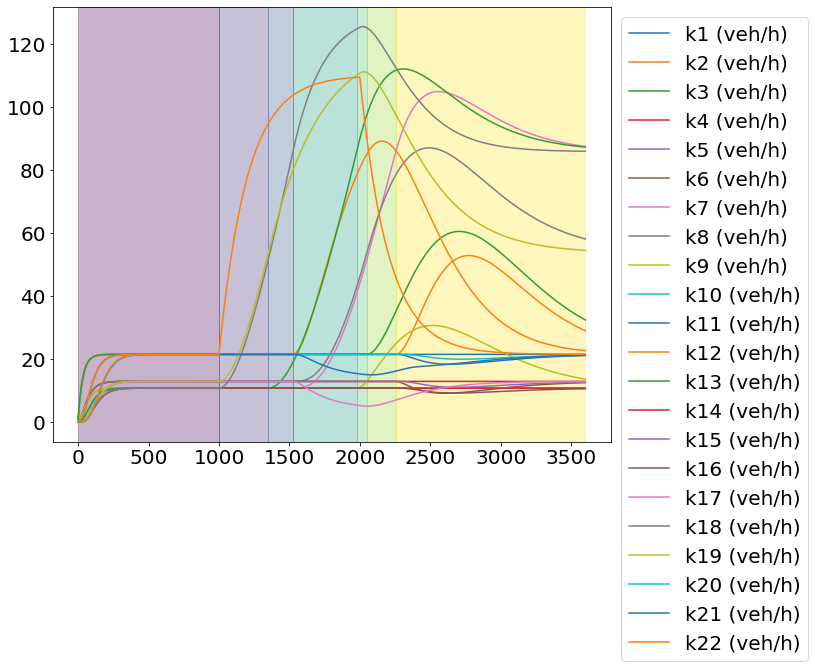

In [12]:

link1 = link(0, l, FD1)
link2 = link(0, l, FD1)
link3 = link(0, l, FD1)
link4 = link(0, l, FD2)
link5 = link(0, l, FD1)
link6 = link(0, l, FD2)
link7 = link(0, l, FD1)
link8 = link(0, l, FD2)
link9 = link(0, l, FD1)
link10 = link(0, l, FD1)
link11 = link(0, l, FD1)
link12 = link(0, l, FD1)
link13 = link(0, l, FD1)
link14 = link(0, l, FD1)
link15 = link(0, l, FD2)
link16 = link(0, l, FD1)
link17 = link(0, l, FD2)
link18 = link(0, l, FD1)
link19 = link(0, l, FD2)
link20 = link(0, l, FD1)
link21 = link(0, l, FD1)
link22 = link(0, l, FD1)

link_list = [link1,link2,link3,link4, link5, link6,link7,link8,link9,link10,
                 link11,link12,link13,link14, link15, link16,link17,link18,link19,link20,link21,link22]


network_geometry = ([[3, 9], [9, 13], [8, 12], [12, 18]],
 [[4, 5, 10], [6, 7, 11], [13, 14, 19], [15, 16, 20], [17, 18, 21]],
 [[0, 3, 4], [1, 5, 6], [2, 7, 8], [10, 14, 15], [11, 16, 17]])

density_list1, boundary_list1, A_list1, u_list1, mode_list1, mode_transition_num1, A_dict1 = LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, WITH_NOISE = False)

plot_density(density_list1, mode_list1)

In [14]:
A_dict1

{0: 1002, 1: 349, 2: 175, 3: 1, 4: 450, 5: 73, 6: 206, 7: 1344}

# Compute NOW

In [23]:
import time
n = 22
p = 19
all_comb = find_combinations(n, p)
PI = compute_PI(A_list1, mode_transition_num1)

MAPE_list = []
observability_score_list = []
counter = 0
# para_num = 3
# para_index = 1
# para_subset_size = len(all_comb)//para_num

# para_start_index = (para_index-1)* para_subset_size
# para_end_index = para_index* para_subset_size
# if para_end_index>=len(all_comb):
#     comb_subset = all_comb[para_start_index:]
# else:
#     comb_subset = all_comb[para_start_index:para_end_index]


for sensor_loc in all_comb:
    counter+=1
    start = time.time()
    vect = np.zeros(n)
    vect[np.array(sensor_loc)]  = 1
    C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

    y_k = list()
    for i in range(T):
        y_k.append(C@density_list[i])

    x_list, mu_list = IMM_filter_reduced(A_list1,PI)
    obs_score = observability_score(A_list, C, w)
    observability_score_list.append(obs_score)
    
    MAPE = np.round(compute_error(x_list, density_list)*100, 4)
    MAPE_list.append(MAPE)
    print("Case", counter, '| MAPE (%) = ', MAPE, 'time(s) =', np.round(time.time()-start,2), "obs_num=", obs_score)

Case 1 | MAPE (%) =  185.3234 time(s) = 12.49 obs_num= 20.558055555555555
Case 2 | MAPE (%) =  113.1335 time(s) = 12.38 obs_num= 20.81861111111111
Case 3 | MAPE (%) =  88.5004 time(s) = 12.71 obs_num= 20.6525
Case 4 | MAPE (%) =  174.6057 time(s) = 12.21 obs_num= 20.525555555555556
Case 5 | MAPE (%) =  115.3559 time(s) = 12.6 obs_num= 20.673611111111114
Case 6 | MAPE (%) =  90.7228 time(s) = 14.29 obs_num= 20.5075
Case 7 | MAPE (%) =  175.5038 time(s) = 14.14 obs_num= 20.326666666666668
Case 8 | MAPE (%) =  19.3341 time(s) = 12.83 obs_num= 20.519166666666667
Case 9 | MAPE (%) =  103.7387 time(s) = 13.41 obs_num= 20.704722222222223
Case 10 | MAPE (%) =  79.1056 time(s) = 13.23 obs_num= 20.538611111111113
Case 11 | MAPE (%) =  84.604 time(s) = 15.06 obs_num= 20.413055555555555
Case 12 | MAPE (%) =  93.685 time(s) = 12.77 obs_num= 20.681944444444444
Case 13 | MAPE (%) =  148.4142 time(s) = 11.7 obs_num= 19.941111111111113
Case 14 | MAPE (%) =  21.1229 time(s) = 12.39 obs_num= 20.942500000

KeyboardInterrupt: 

In [51]:
A0 = np.array(A_list[0])
A = (A0-np.eye(22))*10


C_list = np.array([19,20,21])
C = np.zeros((3,22))
for i in range(3):
    C[i, C_list[i]] = 1

np.linalg.matrix_rank(np.concatenate((C, C@A,C@A@A,C@A@A@A,C@A@A@A@A,C@A@A@A@A@A, C@A@A@A@A@A@A, C@A@A@A@A@A@A@A, C@A@A@A@A@A@A@A@A,C@A@A@A@A@A@A@A@A@A)))

18

In [41]:
import numpy as np

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [118]:
from numpy.linalg import matrix_power
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))
def observability_score(A_list, C, w):
    obs_num_list = []
#     for temp_matrix in A_list:
#         obs_num_list.append(((C2@matrix_power(temp_matrix,21)).sum(axis = 0)>0).sum())
    obs_num_list=[((C@matrix_power(temp_matrix,21)).sum(axis = 0)>0).sum() for temp_matrix in A_list]
    return (np.array(obs_num_list)*w).sum()

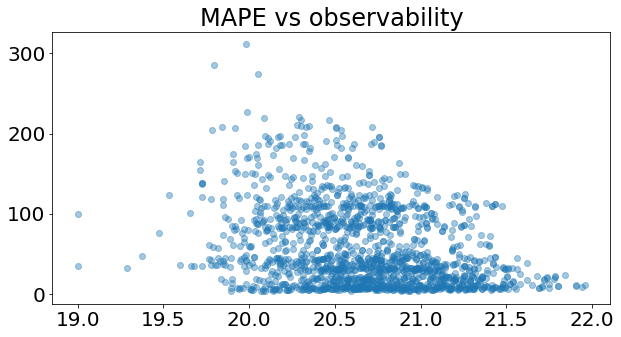

In [117]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10, 5)) 
plt.scatter(observablity_score_list, MAPE_list, alpha=0.4)
plt.title("MAPE vs observability")
plt.xlabel("Number of observable components")
plt.ylabel("MAPE(%)")
plt.show()

In [168]:
bin_num = int((max(observablity_score_list)-min(observablity_score_list))//0.5+1)
bin_x = [None] * bin_num
bin_data = [None] * bin_num

for i in range(bin_num):
    bin_start = min(observablity_score_list) + 0.5*i
    bin_end = min(observablity_score_list) + 0.5*(i+1)
    bin_x[i] = str(bin_start)+'~'+str(bin_end)
    bin_data[i] = np.array(MAPE_list)[(np.array(observablity_score_list)>bin_start) 
                                      & (np.array(observablity_score_list)<bin_end)]
    
    

In [169]:
bin_x

['19.0~19.5', '19.5~20.0', '20.0~20.5', '20.5~21.0', '21.0~21.5', '21.5~22.0']

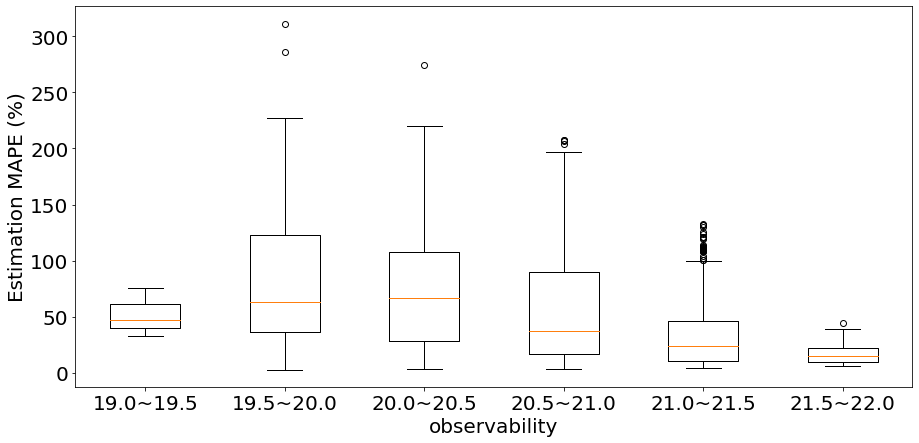

In [175]:
import matplotlib.pyplot as plt
import numpy as np
 
 
# Creating dataset
np.random.seed(10)
 
fig = plt.figure(figsize =(15, 7))
plt.boxplot(bin_data)

plt.xticks([1, 2, 3, 4, 5, 6], bin_x)
plt.xlabel("observability")
plt.ylabel("Estimation MAPE (%)")

# show plot
plt.show()

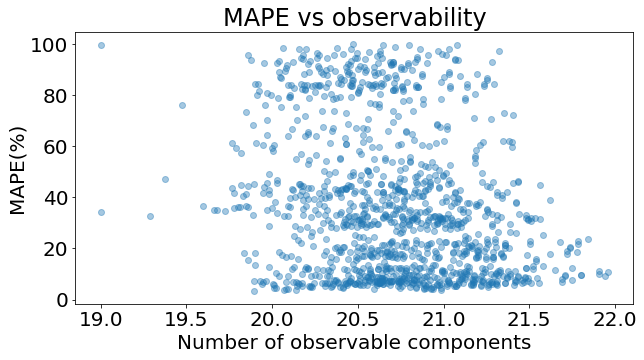

In [178]:
MAPE_list_reduced = np.array(MAPE_list)[np.array(MAPE_list)<100]
observablity_score_list_reduced = np.array(observablity_score_list)[np.array(MAPE_list)<100]
plt.figure(figsize=(10, 5)) 
plt.scatter(observablity_score_list_reduced, MAPE_list_reduced, alpha=0.4)
plt.title("MAPE vs observability")
plt.xlabel("Number of observable components")
plt.ylabel("MAPE(%)")
plt.show()

In [181]:
bin_num = int((max(observablity_score_list)-min(observablity_score_list))//0.5+1)
bin_x1 = [None] * bin_num
bin_data1 = [None] * bin_num

for i in range(bin_num):
    bin_start = min(observablity_score_list) + 0.5*i
    bin_end = min(observablity_score_list) + 0.5*(i+1)
    bin_x1[i] = str(bin_start)+'~'+str(bin_end)
    bin_data1[i] = MAPE_list_reduced[(np.array(observablity_score_list_reduced)>bin_start) 
                                      & (np.array(observablity_score_list_reduced)<bin_end)]
    
    

In [ ]:
import pandas as pd
df = pd.DataFrame({
    'sensor_loc': all_comb_18,
    'MAPE': MAPE_list_18
})

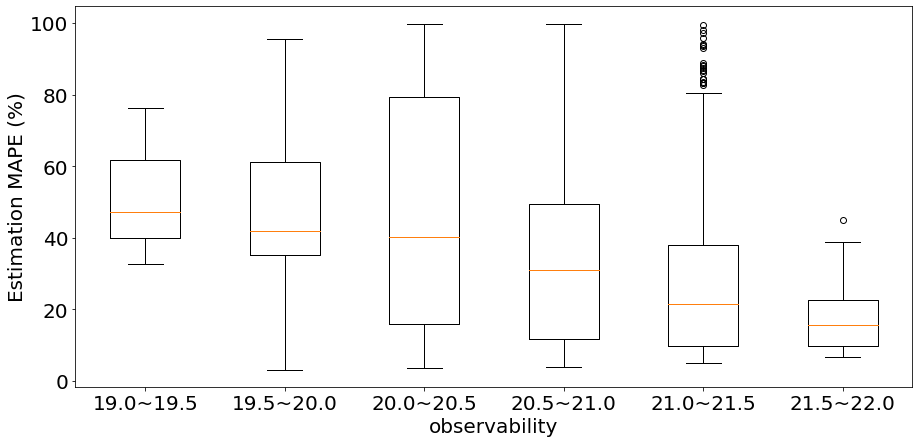

In [182]:
import matplotlib.pyplot as plt
import numpy as np
 
 
# Creating dataset
np.random.seed(10)
 
fig = plt.figure(figsize =(15, 7))
plt.boxplot(bin_data1)

plt.xticks([1, 2, 3, 4, 5, 6], bin_x1)
plt.xlabel("observability")
plt.ylabel("Estimation MAPE (%)")

# show plot
plt.show()

In [183]:
import time
n = 22
p = 18
all_comb_18 = find_combinations(n, p)
PI = compute_PI(A_list1, mode_transition_num1)

MAPE_list_18 = []
observablity_score_list_18 = []
counter = 0
for sensor_loc in all_comb_18:
    counter+=1
    if counter % 73 ==0: 
        print('----------------------', counter//73,"%","-----------------------")
    start = time.time()
    vect = np.zeros(n)
    vect[np.array(sensor_loc)]  = 1
    C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

    y_k = list()
    for i in range(T):
        y_k.append(C@density_list[i])

    x_list, mu_list = IMM_filter_reduced(A_list1,PI)
    obs_score_18 = observablity_score(A_list, C, w)
    observablity_score_list_18.append(obs_score)
    
    MAPE = np.round(compute_error(x_list, density_list)*100, 4)
    MAPE_list_18.append(MAPE)
    print("Case", counter, '| MAPE (%) = ', MAPE, 'time(s) =', np.round(time.time()-start,2), "obs_num=", obs_score)

Case 1 | MAPE (%) =  199.1613 time(s) = 13.76 obs_num= 19.91722222222222
Case 2 | MAPE (%) =  201.2303 time(s) = 12.12 obs_num= 19.91722222222222
Case 3 | MAPE (%) =  124.9623 time(s) = 11.64 obs_num= 19.91722222222222
Case 4 | MAPE (%) =  99.2535 time(s) = 11.52 obs_num= 19.91722222222222
Case 5 | MAPE (%) =  189.635 time(s) = 11.64 obs_num= 19.91722222222222
Case 6 | MAPE (%) =  165.4453 time(s) = 11.58 obs_num= 19.91722222222222
Case 7 | MAPE (%) =  86.5462 time(s) = 11.69 obs_num= 19.91722222222222
Case 8 | MAPE (%) =  100.9939 time(s) = 11.77 obs_num= 19.91722222222222
Case 9 | MAPE (%) =  158.0237 time(s) = 11.47 obs_num= 19.91722222222222
Case 10 | MAPE (%) =  56.1137 time(s) = 11.65 obs_num= 19.91722222222222
Case 11 | MAPE (%) =  99.3808 time(s) = 11.86 obs_num= 19.91722222222222
Case 12 | MAPE (%) =  123.4736 time(s) = 11.59 obs_num= 19.91722222222222
Case 13 | MAPE (%) =  22.9323 time(s) = 11.61 obs_num= 19.91722222222222
Case 14 | MAPE (%) =  61.212 time(s) = 11.63 obs_num=

Case 113 | MAPE (%) =  110.1816 time(s) = 11.62 obs_num= 19.91722222222222
Case 114 | MAPE (%) =  41.5264 time(s) = 11.52 obs_num= 19.91722222222222
Case 115 | MAPE (%) =  8.4046 time(s) = 11.68 obs_num= 19.91722222222222
Case 116 | MAPE (%) =  22.9457 time(s) = 11.69 obs_num= 19.91722222222222
Case 117 | MAPE (%) =  76.8021 time(s) = 11.54 obs_num= 19.91722222222222
Case 118 | MAPE (%) =  45.0404 time(s) = 11.5 obs_num= 19.91722222222222
Case 119 | MAPE (%) =  12.2344 time(s) = 11.73 obs_num= 19.91722222222222
Case 120 | MAPE (%) =  9.574 time(s) = 11.7 obs_num= 19.91722222222222
Case 121 | MAPE (%) =  17.4303 time(s) = 11.65 obs_num= 19.91722222222222
Case 122 | MAPE (%) =  44.4035 time(s) = 11.48 obs_num= 19.91722222222222
Case 123 | MAPE (%) =  35.0099 time(s) = 11.46 obs_num= 19.91722222222222
Case 124 | MAPE (%) =  6.527 time(s) = 11.75 obs_num= 19.91722222222222
Case 125 | MAPE (%) =  6.8282 time(s) = 11.69 obs_num= 19.91722222222222
Case 126 | MAPE (%) =  12.9292 time(s) = 11.6

Case 223 | MAPE (%) =  161.8072 time(s) = 11.49 obs_num= 19.91722222222222
Case 224 | MAPE (%) =  27.9413 time(s) = 11.59 obs_num= 19.91722222222222
Case 225 | MAPE (%) =  83.2452 time(s) = 11.54 obs_num= 19.91722222222222
Case 226 | MAPE (%) =  95.6487 time(s) = 11.67 obs_num= 19.91722222222222
Case 227 | MAPE (%) =  29.0047 time(s) = 11.63 obs_num= 19.91722222222222
Case 228 | MAPE (%) =  58.846 time(s) = 11.4 obs_num= 19.91722222222222
Case 229 | MAPE (%) =  91.4445 time(s) = 11.6 obs_num= 19.91722222222222
Case 230 | MAPE (%) =  15.217 time(s) = 11.56 obs_num= 19.91722222222222
Case 231 | MAPE (%) =  62.7885 time(s) = 11.55 obs_num= 19.91722222222222
Case 232 | MAPE (%) =  99.8277 time(s) = 11.78 obs_num= 19.91722222222222
Case 233 | MAPE (%) =  134.3254 time(s) = 11.48 obs_num= 19.91722222222222
Case 234 | MAPE (%) =  22.4411 time(s) = 11.71 obs_num= 19.91722222222222
Case 235 | MAPE (%) =  52.2729 time(s) = 11.63 obs_num= 19.91722222222222
Case 236 | MAPE (%) =  88.7876 time(s) =

Case 334 | MAPE (%) =  189.6776 time(s) = 11.56 obs_num= 19.91722222222222
Case 335 | MAPE (%) =  125.5957 time(s) = 11.6 obs_num= 19.91722222222222
Case 336 | MAPE (%) =  99.887 time(s) = 11.68 obs_num= 19.91722222222222
Case 337 | MAPE (%) =  189.9766 time(s) = 11.53 obs_num= 19.91722222222222
Case 338 | MAPE (%) =  23.1555 time(s) = 11.66 obs_num= 19.91722222222222
Case 339 | MAPE (%) =  113.7999 time(s) = 11.55 obs_num= 19.91722222222222
Case 340 | MAPE (%) =  88.0911 time(s) = 11.57 obs_num= 19.91722222222222
Case 341 | MAPE (%) =  85.2364 time(s) = 11.79 obs_num= 19.91722222222222
Case 342 | MAPE (%) =  102.7609 time(s) = 11.76 obs_num= 19.91722222222222
Case 343 | MAPE (%) =  155.9338 time(s) = 11.53 obs_num= 19.91722222222222
Case 344 | MAPE (%) =  25.0014 time(s) = 11.75 obs_num= 19.91722222222222
Case 345 | MAPE (%) =  85.5731 time(s) = 11.5 obs_num= 19.91722222222222
Case 346 | MAPE (%) =  91.9559 time(s) = 11.68 obs_num= 19.91722222222222
Case 347 | MAPE (%) =  23.801 time(

/Users/xinyuehu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Case 348 | MAPE (%) =  47.9537 time(s) = 11.6 obs_num= 19.91722222222222
Case 349 | MAPE (%) =  89.3077 time(s) = 11.67 obs_num= 19.91722222222222
Case 350 | MAPE (%) =  12.6752 time(s) = 11.71 obs_num= 19.91722222222222
Case 351 | MAPE (%) =  130.952 time(s) = 11.59 obs_num= 19.91722222222222
Case 352 | MAPE (%) =  98.1536 time(s) = 11.67 obs_num= 19.91722222222222
Case 353 | MAPE (%) =  196.5678 time(s) = 11.48 obs_num= 19.91722222222222
Case 354 | MAPE (%) =  20.5134 time(s) = 11.77 obs_num= 19.91722222222222
Case 355 | MAPE (%) =  118.8781 time(s) = 11.55 obs_num= 19.91722222222222
Case 356 | MAPE (%) =  87.1223 time(s) = 11.45 obs_num= 19.91722222222222
Case 357 | MAPE (%) =  23.2156 time(s) = 11.64 obs_num= 19.91722222222222
Case 358 | MAPE (%) =  120.4397 time(s) = 11.59 obs_num= 19.91722222222222
Case 359 | MAPE (%) =  87.545 time(s) = 11.56 obs_num= 19.91722222222222
Case 360 | MAPE (%) =  11.26 time(s) = 11.68 obs_num= 19.91722222222222
Case 361 | MAPE (%) =  29.0921 time(s) 

Case 458 | MAPE (%) =  119.0343 time(s) = 11.65 obs_num= 19.91722222222222
Case 459 | MAPE (%) =  93.3255 time(s) = 11.58 obs_num= 19.91722222222222
Case 460 | MAPE (%) =  16.2578 time(s) = 11.76 obs_num= 19.91722222222222
Case 461 | MAPE (%) =  29.7749 time(s) = 11.7 obs_num= 19.91722222222222
Case 462 | MAPE (%) =  82.226 time(s) = 11.48 obs_num= 19.91722222222222
Case 463 | MAPE (%) =  96.2602 time(s) = 11.66 obs_num= 19.91722222222222
Case 464 | MAPE (%) =  19.3177 time(s) = 11.66 obs_num= 19.91722222222222
Case 465 | MAPE (%) =  15.911 time(s) = 11.61 obs_num= 19.91722222222222
Case 466 | MAPE (%) =  24.9072 time(s) = 11.82 obs_num= 19.91722222222222
Case 467 | MAPE (%) =  120.797 time(s) = 11.45 obs_num= 19.91722222222222
Case 468 | MAPE (%) =  90.3432 time(s) = 11.58 obs_num= 19.91722222222222
Case 469 | MAPE (%) =  13.7606 time(s) = 11.84 obs_num= 19.91722222222222
Case 470 | MAPE (%) =  17.737 time(s) = 11.95 obs_num= 19.91722222222222
Case 471 | MAPE (%) =  22.6128 time(s) = 

Case 569 | MAPE (%) =  34.2466 time(s) = 11.55 obs_num= 19.91722222222222
Case 570 | MAPE (%) =  6.3315 time(s) = 11.64 obs_num= 19.91722222222222
Case 571 | MAPE (%) =  6.5803 time(s) = 11.75 obs_num= 19.91722222222222
Case 572 | MAPE (%) =  12.6883 time(s) = 11.63 obs_num= 19.91722222222222
Case 573 | MAPE (%) =  16.6089 time(s) = 11.65 obs_num= 19.91722222222222
Case 574 | MAPE (%) =  107.883 time(s) = 11.49 obs_num= 19.91722222222222
Case 575 | MAPE (%) =  33.9665 time(s) = 11.34 obs_num= 19.91722222222222
Case 576 | MAPE (%) =  5.7307 time(s) = 11.6 obs_num= 19.91722222222222
Case 577 | MAPE (%) =  6.144 time(s) = 11.53 obs_num= 19.91722222222222
Case 578 | MAPE (%) =  10.7719 time(s) = 11.5 obs_num= 19.91722222222222
Case 579 | MAPE (%) =  4.574 time(s) = 11.57 obs_num= 19.91722222222222
Case 580 | MAPE (%) =  122.4905 time(s) = 11.81 obs_num= 19.91722222222222
Case 581 | MAPE (%) =  96.7816 time(s) = 11.68 obs_num= 19.91722222222222
Case 582 | MAPE (%) =  188.0517 time(s) = 11.6

Case 679 | MAPE (%) =  9.1989 time(s) = 11.79 obs_num= 19.91722222222222
Case 680 | MAPE (%) =  9.6216 time(s) = 11.69 obs_num= 19.91722222222222
Case 681 | MAPE (%) =  17.3998 time(s) = 11.91 obs_num= 19.91722222222222
Case 682 | MAPE (%) =  20.0166 time(s) = 11.87 obs_num= 19.91722222222222
Case 683 | MAPE (%) =  111.2656 time(s) = 11.63 obs_num= 19.91722222222222
Case 684 | MAPE (%) =  163.6442 time(s) = 11.67 obs_num= 19.91722222222222
Case 685 | MAPE (%) =  9.1454 time(s) = 11.69 obs_num= 19.91722222222222
Case 686 | MAPE (%) =  9.4182 time(s) = 11.67 obs_num= 19.91722222222222
Case 687 | MAPE (%) =  13.9963 time(s) = 11.89 obs_num= 19.91722222222222
Case 688 | MAPE (%) =  8.7555 time(s) = 11.79 obs_num= 19.91722222222222
Case 689 | MAPE (%) =  19.1318 time(s) = 11.67 obs_num= 19.91722222222222
Case 690 | MAPE (%) =  110.3796 time(s) = 11.64 obs_num= 19.91722222222222
Case 691 | MAPE (%) =  36.2049 time(s) = 11.51 obs_num= 19.91722222222222
Case 692 | MAPE (%) =  8.2397 time(s) = 

Case 789 | MAPE (%) =  60.15 time(s) = 11.59 obs_num= 19.91722222222222
Case 790 | MAPE (%) =  30.8211 time(s) = 11.68 obs_num= 19.91722222222222
Case 791 | MAPE (%) =  31.2076 time(s) = 11.9 obs_num= 19.91722222222222
Case 792 | MAPE (%) =  36.5851 time(s) = 11.72 obs_num= 19.91722222222222
Case 793 | MAPE (%) =  42.3446 time(s) = 11.69 obs_num= 19.91722222222222
Case 794 | MAPE (%) =  133.4126 time(s) = 11.63 obs_num= 19.91722222222222
Case 795 | MAPE (%) =  57.7528 time(s) = 11.54 obs_num= 19.91722222222222
Case 796 | MAPE (%) =  30.2402 time(s) = 11.74 obs_num= 19.91722222222222
Case 797 | MAPE (%) =  31.3712 time(s) = 11.65 obs_num= 19.91722222222222
Case 798 | MAPE (%) =  36.0696 time(s) = 11.64 obs_num= 19.91722222222222
Case 799 | MAPE (%) =  29.5909 time(s) = 11.65 obs_num= 19.91722222222222
Case 800 | MAPE (%) =  169.1268 time(s) = 11.52 obs_num= 19.91722222222222
Case 801 | MAPE (%) =  143.418 time(s) = 11.55 obs_num= 19.91722222222222
Case 802 | MAPE (%) =  214.7971 time(s)

Case 899 | MAPE (%) =  63.8631 time(s) = 11.62 obs_num= 19.91722222222222
Case 900 | MAPE (%) =  35.5293 time(s) = 11.74 obs_num= 19.91722222222222
Case 901 | MAPE (%) =  46.6902 time(s) = 11.69 obs_num= 19.91722222222222
Case 902 | MAPE (%) =  45.5888 time(s) = 11.74 obs_num= 19.91722222222222
Case 903 | MAPE (%) =  136.644 time(s) = 11.65 obs_num= 19.91722222222222
Case 904 | MAPE (%) =  189.029 time(s) = 11.69 obs_num= 19.91722222222222
Case 905 | MAPE (%) =  62.7616 time(s) = 11.75 obs_num= 19.91722222222222
Case 906 | MAPE (%) =  34.6064 time(s) = 11.75 obs_num= 19.91722222222222
Case 907 | MAPE (%) =  39.0678 time(s) = 11.82 obs_num= 19.91722222222222
Case 908 | MAPE (%) =  34.1101 time(s) = 11.9 obs_num= 19.91722222222222
Case 909 | MAPE (%) =  46.0355 time(s) = 11.78 obs_num= 19.91722222222222
Case 910 | MAPE (%) =  137.1102 time(s) = 11.77 obs_num= 19.91722222222222
Case 911 | MAPE (%) =  63.9767 time(s) = 11.59 obs_num= 19.91722222222222
Case 912 | MAPE (%) =  63.1739 time(s)

Case 1009 | MAPE (%) =  48.5553 time(s) = 11.78 obs_num= 19.91722222222222
Case 1010 | MAPE (%) =  138.9874 time(s) = 11.54 obs_num= 19.91722222222222
Case 1011 | MAPE (%) =  113.2786 time(s) = 11.94 obs_num= 19.91722222222222
Case 1012 | MAPE (%) =  106.9849 time(s) = 11.81 obs_num= 19.91722222222222
Case 1013 | MAPE (%) =  124.3322 time(s) = 11.78 obs_num= 19.91722222222222
Case 1014 | MAPE (%) =  150.6956 time(s) = 11.37 obs_num= 19.91722222222222
Case 1015 | MAPE (%) =  49.896 time(s) = 11.75 obs_num= 19.91722222222222
Case 1016 | MAPE (%) =  108.6523 time(s) = 11.62 obs_num= 19.91722222222222
Case 1017 | MAPE (%) =  116.8501 time(s) = 11.66 obs_num= 19.91722222222222
Case 1018 | MAPE (%) =  22.4494 time(s) = 11.74 obs_num= 19.91722222222222
Case 1019 | MAPE (%) =  48.615 time(s) = 11.59 obs_num= 19.91722222222222
Case 1020 | MAPE (%) =  90.0193 time(s) = 11.62 obs_num= 19.91722222222222
Case 1021 | MAPE (%) =  37.995 time(s) = 11.75 obs_num= 19.91722222222222
---------------------

Case 1117 | MAPE (%) =  49.1082 time(s) = 11.59 obs_num= 19.91722222222222
Case 1118 | MAPE (%) =  62.7505 time(s) = 11.96 obs_num= 19.91722222222222
Case 1119 | MAPE (%) =  79.9561 time(s) = 11.76 obs_num= 19.91722222222222
Case 1120 | MAPE (%) =  47.1457 time(s) = 11.67 obs_num= 19.91722222222222
Case 1121 | MAPE (%) =  46.8647 time(s) = 11.49 obs_num= 19.91722222222222
Case 1122 | MAPE (%) =  165.0694 time(s) = 11.62 obs_num= 19.91722222222222
Case 1123 | MAPE (%) =  139.3607 time(s) = 11.65 obs_num= 19.91722222222222
Case 1124 | MAPE (%) =  229.1143 time(s) = 11.49 obs_num= 19.91722222222222
Case 1125 | MAPE (%) =  65.2718 time(s) = 11.61 obs_num= 19.91722222222222
Case 1126 | MAPE (%) =  158.2653 time(s) = 11.66 obs_num= 19.91722222222222
Case 1127 | MAPE (%) =  132.5566 time(s) = 11.48 obs_num= 19.91722222222222
Case 1128 | MAPE (%) =  31.2713 time(s) = 11.82 obs_num= 19.91722222222222
Case 1129 | MAPE (%) =  116.6483 time(s) = 11.66 obs_num= 19.91722222222222
Case 1130 | MAPE (%

Case 1226 | MAPE (%) =  136.0289 time(s) = 11.69 obs_num= 19.91722222222222
Case 1227 | MAPE (%) =  110.32 time(s) = 11.68 obs_num= 19.91722222222222
Case 1228 | MAPE (%) =  43.3598 time(s) = 11.7 obs_num= 19.91722222222222
Case 1229 | MAPE (%) =  111.129 time(s) = 11.64 obs_num= 19.91722222222222
Case 1230 | MAPE (%) =  85.4202 time(s) = 11.6 obs_num= 19.91722222222222
Case 1231 | MAPE (%) =  35.3553 time(s) = 11.77 obs_num= 19.91722222222222
Case 1232 | MAPE (%) =  46.4089 time(s) = 11.7 obs_num= 19.91722222222222
Case 1233 | MAPE (%) =  72.7722 time(s) = 11.55 obs_num= 19.91722222222222
Case 1234 | MAPE (%) =  111.0048 time(s) = 11.71 obs_num= 19.91722222222222
Case 1235 | MAPE (%) =  38.9267 time(s) = 11.81 obs_num= 19.91722222222222
Case 1236 | MAPE (%) =  12.096 time(s) = 11.62 obs_num= 19.91722222222222
Case 1237 | MAPE (%) =  41.1967 time(s) = 11.79 obs_num= 19.91722222222222
Case 1238 | MAPE (%) =  60.3474 time(s) = 11.64 obs_num= 19.91722222222222
Case 1239 | MAPE (%) =  106.

Case 1334 | MAPE (%) =  201.7551 time(s) = 11.62 obs_num= 19.91722222222222
Case 1335 | MAPE (%) =  176.0464 time(s) = 11.57 obs_num= 19.91722222222222
Case 1336 | MAPE (%) =  53.6972 time(s) = 11.67 obs_num= 19.91722222222222
Case 1337 | MAPE (%) =  48.5342 time(s) = 11.63 obs_num= 19.91722222222222
Case 1338 | MAPE (%) =  98.8535 time(s) = 11.81 obs_num= 19.91722222222222
Case 1339 | MAPE (%) =  52.9107 time(s) = 11.62 obs_num= 19.91722222222222
Case 1340 | MAPE (%) =  51.8415 time(s) = 11.72 obs_num= 19.91722222222222
Case 1341 | MAPE (%) =  98.6458 time(s) = 11.68 obs_num= 19.91722222222222
Case 1342 | MAPE (%) =  66.4665 time(s) = 11.63 obs_num= 19.91722222222222
Case 1343 | MAPE (%) =  43.3365 time(s) = 11.8 obs_num= 19.91722222222222
Case 1344 | MAPE (%) =  136.4818 time(s) = 11.62 obs_num= 19.91722222222222
Case 1345 | MAPE (%) =  110.7729 time(s) = 11.74 obs_num= 19.91722222222222
Case 1346 | MAPE (%) =  71.5081 time(s) = 11.6 obs_num= 19.91722222222222
Case 1347 | MAPE (%) = 

Case 1443 | MAPE (%) =  19.9693 time(s) = 11.65 obs_num= 19.91722222222222
Case 1444 | MAPE (%) =  110.9255 time(s) = 11.51 obs_num= 19.91722222222222
Case 1445 | MAPE (%) =  73.1677 time(s) = 11.54 obs_num= 19.91722222222222
Case 1446 | MAPE (%) =  8.128 time(s) = 11.72 obs_num= 19.91722222222222
Case 1447 | MAPE (%) =  11.2504 time(s) = 11.62 obs_num= 19.91722222222222
Case 1448 | MAPE (%) =  16.5018 time(s) = 11.68 obs_num= 19.91722222222222
Case 1449 | MAPE (%) =  8.7269 time(s) = 11.62 obs_num= 19.91722222222222
Case 1450 | MAPE (%) =  175.5798 time(s) = 11.69 obs_num= 19.91722222222222
Case 1451 | MAPE (%) =  149.8711 time(s) = 11.71 obs_num= 19.91722222222222
Case 1452 | MAPE (%) =  242.4514 time(s) = 11.45 obs_num= 19.91722222222222
Case 1453 | MAPE (%) =  20.121 time(s) = 11.57 obs_num= 19.91722222222222
Case 1454 | MAPE (%) =  112.6333 time(s) = 11.58 obs_num= 19.91722222222222
Case 1455 | MAPE (%) =  86.9246 time(s) = 11.57 obs_num= 19.91722222222222
Case 1456 | MAPE (%) =  

Case 1551 | MAPE (%) =  45.5195 time(s) = 11.67 obs_num= 19.91722222222222
Case 1552 | MAPE (%) =  35.5019 time(s) = 11.77 obs_num= 19.91722222222222
Case 1553 | MAPE (%) =  127.3583 time(s) = 11.54 obs_num= 19.91722222222222
Case 1554 | MAPE (%) =  183.535 time(s) = 11.98 obs_num= 19.91722222222222
Case 1555 | MAPE (%) =  24.7159 time(s) = 11.66 obs_num= 19.91722222222222
Case 1556 | MAPE (%) =  33.2098 time(s) = 11.76 obs_num= 19.91722222222222
Case 1557 | MAPE (%) =  41.6453 time(s) = 11.69 obs_num= 19.91722222222222
Case 1558 | MAPE (%) =  25.0572 time(s) = 11.64 obs_num= 19.91722222222222
Case 1559 | MAPE (%) =  35.0826 time(s) = 11.64 obs_num= 19.91722222222222
Case 1560 | MAPE (%) =  126.925 time(s) = 11.63 obs_num= 19.91722222222222
Case 1561 | MAPE (%) =  53.7916 time(s) = 11.66 obs_num= 19.91722222222222
Case 1562 | MAPE (%) =  24.0997 time(s) = 11.66 obs_num= 19.91722222222222
Case 1563 | MAPE (%) =  32.8938 time(s) = 11.85 obs_num= 19.91722222222222
Case 1564 | MAPE (%) =  

Case 1660 | MAPE (%) =  117.8929 time(s) = 11.57 obs_num= 19.91722222222222
Case 1661 | MAPE (%) =  40.8608 time(s) = 11.51 obs_num= 19.91722222222222
Case 1662 | MAPE (%) =  78.4804 time(s) = 11.65 obs_num= 19.91722222222222
Case 1663 | MAPE (%) =  142.2178 time(s) = 11.58 obs_num= 19.91722222222222
Case 1664 | MAPE (%) =  144.761 time(s) = 11.58 obs_num= 19.91722222222222
Case 1665 | MAPE (%) =  41.997 time(s) = 11.63 obs_num= 19.91722222222222
Case 1666 | MAPE (%) =  62.3477 time(s) = 11.74 obs_num= 19.91722222222222
Case 1667 | MAPE (%) =  49.0688 time(s) = 11.75 obs_num= 19.91722222222222
Case 1668 | MAPE (%) =  107.4618 time(s) = 11.55 obs_num= 19.91722222222222
Case 1669 | MAPE (%) =  118.1009 time(s) = 11.69 obs_num= 19.91722222222222
Case 1670 | MAPE (%) =  36.7498 time(s) = 11.54 obs_num= 19.91722222222222
Case 1671 | MAPE (%) =  39.4081 time(s) = 11.63 obs_num= 19.91722222222222
Case 1672 | MAPE (%) =  55.4543 time(s) = 11.67 obs_num= 19.91722222222222
Case 1673 | MAPE (%) =

Case 1768 | MAPE (%) =  177.0592 time(s) = 11.56 obs_num= 19.91722222222222
Case 1769 | MAPE (%) =  63.2636 time(s) = 11.56 obs_num= 19.91722222222222
Case 1770 | MAPE (%) =  90.6617 time(s) = 11.71 obs_num= 19.91722222222222
Case 1771 | MAPE (%) =  108.7926 time(s) = 11.57 obs_num= 19.91722222222222
Case 1772 | MAPE (%) =  99.4677 time(s) = 11.71 obs_num= 19.91722222222222
Case 1773 | MAPE (%) =  99.5622 time(s) = 11.63 obs_num= 19.91722222222222
Case 1774 | MAPE (%) =  99.6586 time(s) = 11.76 obs_num= 19.91722222222222
Case 1775 | MAPE (%) =  55.4167 time(s) = 11.64 obs_num= 19.91722222222222
Case 1776 | MAPE (%) =  121.746 time(s) = 11.44 obs_num= 19.91722222222222
Case 1777 | MAPE (%) =  96.0373 time(s) = 11.41 obs_num= 19.91722222222222
Case 1778 | MAPE (%) =  15.0814 time(s) = 11.58 obs_num= 19.91722222222222
Case 1779 | MAPE (%) =  34.0585 time(s) = 11.76 obs_num= 19.91722222222222
Case 1780 | MAPE (%) =  93.0201 time(s) = 11.58 obs_num= 19.91722222222222
Case 1781 | MAPE (%) = 

Case 1877 | MAPE (%) =  121.7424 time(s) = 11.72 obs_num= 19.91722222222222
Case 1878 | MAPE (%) =  48.609 time(s) = 11.58 obs_num= 19.91722222222222
Case 1879 | MAPE (%) =  139.8117 time(s) = 11.46 obs_num= 19.91722222222222
Case 1880 | MAPE (%) =  18.7963 time(s) = 11.77 obs_num= 19.91722222222222
Case 1881 | MAPE (%) =  110.7588 time(s) = 11.69 obs_num= 19.91722222222222
Case 1882 | MAPE (%) =  37.6254 time(s) = 11.66 obs_num= 19.91722222222222
Case 1883 | MAPE (%) =  21.1618 time(s) = 11.7 obs_num= 19.91722222222222
Case 1884 | MAPE (%) =  111.1212 time(s) = 11.72 obs_num= 19.91722222222222
Case 1885 | MAPE (%) =  37.9878 time(s) = 11.56 obs_num= 19.91722222222222
Case 1886 | MAPE (%) =  9.2808 time(s) = 11.67 obs_num= 19.91722222222222
Case 1887 | MAPE (%) =  23.9549 time(s) = 11.92 obs_num= 19.91722222222222
Case 1888 | MAPE (%) =  77.0357 time(s) = 11.54 obs_num= 19.91722222222222
Case 1889 | MAPE (%) =  42.5735 time(s) = 11.59 obs_num= 19.91722222222222
Case 1890 | MAPE (%) =  

Case 1986 | MAPE (%) =  123.0362 time(s) = 12.42 obs_num= 19.91722222222222
Case 1987 | MAPE (%) =  97.3274 time(s) = 11.55 obs_num= 19.91722222222222
Case 1988 | MAPE (%) =  188.5588 time(s) = 11.87 obs_num= 19.91722222222222
Case 1989 | MAPE (%) =  19.9286 time(s) = 11.63 obs_num= 19.91722222222222
Case 1990 | MAPE (%) =  111.9871 time(s) = 11.58 obs_num= 19.91722222222222
Case 1991 | MAPE (%) =  86.2783 time(s) = 11.52 obs_num= 19.91722222222222
Case 1992 | MAPE (%) =  22.318 time(s) = 11.66 obs_num= 19.91722222222222
Case 1993 | MAPE (%) =  112.4191 time(s) = 11.64 obs_num= 19.91722222222222
Case 1994 | MAPE (%) =  86.7103 time(s) = 11.56 obs_num= 19.91722222222222
Case 1995 | MAPE (%) =  10.4607 time(s) = 11.69 obs_num= 19.91722222222222
Case 1996 | MAPE (%) =  25.2053 time(s) = 11.77 obs_num= 19.91722222222222
Case 1997 | MAPE (%) =  78.3302 time(s) = 11.57 obs_num= 19.91722222222222
Case 1998 | MAPE (%) =  91.2769 time(s) = 11.59 obs_num= 19.91722222222222
Case 1999 | MAPE (%) =

Case 2095 | MAPE (%) =  11.5613 time(s) = 11.67 obs_num= 19.91722222222222
Case 2096 | MAPE (%) =  19.4041 time(s) = 11.84 obs_num= 19.91722222222222
Case 2097 | MAPE (%) =  110.6354 time(s) = 11.66 obs_num= 19.91722222222222
Case 2098 | MAPE (%) =  84.9265 time(s) = 11.62 obs_num= 19.91722222222222
Case 2099 | MAPE (%) =  8.355 time(s) = 11.61 obs_num= 19.91722222222222
Case 2100 | MAPE (%) =  8.7869 time(s) = 11.71 obs_num= 19.91722222222222
Case 2101 | MAPE (%) =  13.3535 time(s) = 11.81 obs_num= 19.91722222222222
Case 2102 | MAPE (%) =  8.1024 time(s) = 11.76 obs_num= 19.91722222222222
Case 2103 | MAPE (%) =  7.8186 time(s) = 11.75 obs_num= 19.91722222222222
Case 2104 | MAPE (%) =  7.1208 time(s) = 11.57 obs_num= 19.91722222222222
Case 2105 | MAPE (%) =  24.4351 time(s) = 11.69 obs_num= 19.91722222222222
Case 2106 | MAPE (%) =  12.9161 time(s) = 11.63 obs_num= 19.91722222222222
Case 2107 | MAPE (%) =  146.7806 time(s) = 11.64 obs_num= 19.91722222222222
Case 2108 | MAPE (%) =  121.0

Case 2203 | MAPE (%) =  36.2215 time(s) = 11.78 obs_num= 19.91722222222222
Case 2204 | MAPE (%) =  44.289 time(s) = 11.83 obs_num= 19.91722222222222
Case 2205 | MAPE (%) =  14.4948 time(s) = 11.51 obs_num= 19.91722222222222
Case 2206 | MAPE (%) =  44.1588 time(s) = 11.87 obs_num= 19.91722222222222
Case 2207 | MAPE (%) =  135.6836 time(s) = 11.61 obs_num= 19.91722222222222
Case 2208 | MAPE (%) =  100.5756 time(s) = 11.58 obs_num= 19.91722222222222
Case 2209 | MAPE (%) =  36.2452 time(s) = 11.76 obs_num= 19.91722222222222
Case 2210 | MAPE (%) =  43.8004 time(s) = 11.82 obs_num= 19.91722222222222
Case 2211 | MAPE (%) =  37.4668 time(s) = 11.96 obs_num= 19.91722222222222
Case 2212 | MAPE (%) =  32.3476 time(s) = 12.02 obs_num= 19.91722222222222
Case 2213 | MAPE (%) =  44.2163 time(s) = 11.74 obs_num= 19.91722222222222
Case 2214 | MAPE (%) =  135.7761 time(s) = 11.8 obs_num= 19.91722222222222
Case 2215 | MAPE (%) =  62.6427 time(s) = 11.71 obs_num= 19.91722222222222
Case 2216 | MAPE (%) =  

Case 2312 | MAPE (%) =  74.0547 time(s) = 11.75 obs_num= 19.91722222222222
Case 2313 | MAPE (%) =  167.0053 time(s) = 11.58 obs_num= 19.91722222222222
Case 2314 | MAPE (%) =  141.2966 time(s) = 11.63 obs_num= 19.91722222222222
Case 2315 | MAPE (%) =  40.7889 time(s) = 11.67 obs_num= 19.91722222222222
Case 2316 | MAPE (%) =  55.185 time(s) = 11.8 obs_num= 19.91722222222222
Case 2317 | MAPE (%) =  70.9279 time(s) = 11.66 obs_num= 19.91722222222222
Case 2318 | MAPE (%) =  63.7216 time(s) = 11.88 obs_num= 19.91722222222222
Case 2319 | MAPE (%) =  63.7841 time(s) = 11.75 obs_num= 19.91722222222222
Case 2320 | MAPE (%) =  63.896 time(s) = 11.78 obs_num= 19.91722222222222
Case 2321 | MAPE (%) =  25.586 time(s) = 11.74 obs_num= 19.91722222222222
Case 2322 | MAPE (%) =  139.25 time(s) = 11.56 obs_num= 19.91722222222222
Case 2323 | MAPE (%) =  113.5416 time(s) = 11.62 obs_num= 19.91722222222222
Case 2324 | MAPE (%) =  34.3093 time(s) = 11.68 obs_num= 19.91722222222222
Case 2325 | MAPE (%) =  26.

Case 2420 | MAPE (%) =  111.8762 time(s) = 11.87 obs_num= 19.91722222222222
Case 2421 | MAPE (%) =  75.62 time(s) = 11.62 obs_num= 19.91722222222222
Case 2422 | MAPE (%) =  46.6495 time(s) = 11.8 obs_num= 19.91722222222222
Case 2423 | MAPE (%) =  148.0657 time(s) = 11.63 obs_num= 19.91722222222222
Case 2424 | MAPE (%) =  109.3534 time(s) = 11.59 obs_num= 19.91722222222222
Case 2425 | MAPE (%) =  9.987 time(s) = 11.66 obs_num= 19.91722222222222
Case 2426 | MAPE (%) =  24.2329 time(s) = 11.82 obs_num= 19.91722222222222
Case 2427 | MAPE (%) =  71.8369 time(s) = 11.71 obs_num= 19.91722222222222
Case 2428 | MAPE (%) =  80.183 time(s) = 11.66 obs_num= 19.91722222222222
Case 2429 | MAPE (%) =  13.8095 time(s) = 11.87 obs_num= 19.91722222222222
Case 2430 | MAPE (%) =  50.3022 time(s) = 11.66 obs_num= 19.91722222222222
Case 2431 | MAPE (%) =  19.6999 time(s) = 11.82 obs_num= 19.91722222222222
Case 2432 | MAPE (%) =  36.2624 time(s) = 11.58 obs_num= 19.91722222222222
Case 2433 | MAPE (%) =  74.9

Case 2529 | MAPE (%) =  23.774 time(s) = 11.82 obs_num= 19.91722222222222
Case 2530 | MAPE (%) =  115.0507 time(s) = 11.59 obs_num= 19.91722222222222
Case 2531 | MAPE (%) =  41.9174 time(s) = 11.52 obs_num= 19.91722222222222
Case 2532 | MAPE (%) =  12.5491 time(s) = 11.62 obs_num= 19.91722222222222
Case 2533 | MAPE (%) =  17.2637 time(s) = 11.74 obs_num= 19.91722222222222
Case 2534 | MAPE (%) =  17.0806 time(s) = 11.74 obs_num= 19.91722222222222
Case 2535 | MAPE (%) =  11.8417 time(s) = 11.85 obs_num= 19.91722222222222
Case 2536 | MAPE (%) =  11.2573 time(s) = 11.63 obs_num= 19.91722222222222
Case 2537 | MAPE (%) =  49.1844 time(s) = 11.69 obs_num= 19.91722222222222
Case 2538 | MAPE (%) =  142.3895 time(s) = 11.74 obs_num= 19.91722222222222
Case 2539 | MAPE (%) =  116.6808 time(s) = 11.77 obs_num= 19.91722222222222
Case 2540 | MAPE (%) =  31.5973 time(s) = 11.66 obs_num= 19.91722222222222
Case 2541 | MAPE (%) =  104.8247 time(s) = 11.54 obs_num= 19.91722222222222
Case 2542 | MAPE (%) =

Case 2637 | MAPE (%) =  47.7755 time(s) = 11.8 obs_num= 19.91722222222222
Case 2638 | MAPE (%) =  141.2524 time(s) = 11.52 obs_num= 19.91722222222222
Case 2639 | MAPE (%) =  115.5435 time(s) = 11.58 obs_num= 19.91722222222222
Case 2640 | MAPE (%) =  31.8603 time(s) = 11.98 obs_num= 19.91722222222222
Case 2641 | MAPE (%) =  73.0718 time(s) = 11.55 obs_num= 19.91722222222222
Case 2642 | MAPE (%) =  43.195 time(s) = 11.66 obs_num= 19.91722222222222
Case 2643 | MAPE (%) =  37.9394 time(s) = 11.73 obs_num= 19.91722222222222
Case 2644 | MAPE (%) =  37.8888 time(s) = 11.64 obs_num= 19.91722222222222
Case 2645 | MAPE (%) =  37.738 time(s) = 11.55 obs_num= 19.91722222222222
Case 2646 | MAPE (%) =  23.2512 time(s) = 11.65 obs_num= 19.91722222222222
Case 2647 | MAPE (%) =  114.528 time(s) = 11.75 obs_num= 19.91722222222222
Case 2648 | MAPE (%) =  88.8192 time(s) = 11.58 obs_num= 19.91722222222222
Case 2649 | MAPE (%) =  12.0263 time(s) = 11.75 obs_num= 19.91722222222222
Case 2650 | MAPE (%) =  16

Case 2746 | MAPE (%) =  97.0026 time(s) = 11.68 obs_num= 19.91722222222222
Case 2747 | MAPE (%) =  188.6169 time(s) = 11.52 obs_num= 19.91722222222222
Case 2748 | MAPE (%) =  45.2406 time(s) = 11.79 obs_num= 19.91722222222222
Case 2749 | MAPE (%) =  137.8013 time(s) = 11.71 obs_num= 19.91722222222222
Case 2750 | MAPE (%) =  112.0926 time(s) = 11.69 obs_num= 19.91722222222222
Case 2751 | MAPE (%) =  47.5935 time(s) = 11.77 obs_num= 19.91722222222222
Case 2752 | MAPE (%) =  149.2072 time(s) = 11.54 obs_num= 19.91722222222222
Case 2753 | MAPE (%) =  123.4985 time(s) = 11.58 obs_num= 19.91722222222222
Case 2754 | MAPE (%) =  36.6445 time(s) = 11.73 obs_num= 19.91722222222222
Case 2755 | MAPE (%) =  23.7652 time(s) = 11.87 obs_num= 19.91722222222222
Case 2756 | MAPE (%) =  71.1661 time(s) = 11.58 obs_num= 19.91722222222222
Case 2757 | MAPE (%) =  90.5312 time(s) = 11.57 obs_num= 19.91722222222222
Case 2758 | MAPE (%) =  39.9943 time(s) = 11.78 obs_num= 19.91722222222222
Case 2759 | MAPE (%)

Case 2854 | MAPE (%) =  22.7664 time(s) = 11.76 obs_num= 19.91722222222222
Case 2855 | MAPE (%) =  45.6932 time(s) = 11.82 obs_num= 19.91722222222222
Case 2856 | MAPE (%) =  27.812 time(s) = 11.78 obs_num= 19.91722222222222
Case 2857 | MAPE (%) =  32.8411 time(s) = 11.86 obs_num= 19.91722222222222
Case 2858 | MAPE (%) =  125.3565 time(s) = 11.75 obs_num= 19.91722222222222
Case 2859 | MAPE (%) =  86.5752 time(s) = 11.82 obs_num= 19.91722222222222
Case 2860 | MAPE (%) =  22.8734 time(s) = 11.71 obs_num= 19.91722222222222
Case 2861 | MAPE (%) =  45.7873 time(s) = 11.84 obs_num= 19.91722222222222
Case 2862 | MAPE (%) =  26.8122 time(s) = 11.86 obs_num= 19.91722222222222
Case 2863 | MAPE (%) =  21.9837 time(s) = 11.87 obs_num= 19.91722222222222
Case 2864 | MAPE (%) =  32.9669 time(s) = 11.71 obs_num= 19.91722222222222
Case 2865 | MAPE (%) =  125.4797 time(s) = 11.79 obs_num= 19.91722222222222
Case 2866 | MAPE (%) =  52.3464 time(s) = 11.57 obs_num= 19.91722222222222
Case 2867 | MAPE (%) =  

Case 2963 | MAPE (%) =  111.5444 time(s) = 11.53 obs_num= 19.91722222222222
Case 2964 | MAPE (%) =  76.4727 time(s) = 11.58 obs_num= 19.91722222222222
Case 2965 | MAPE (%) =  8.9328 time(s) = 11.64 obs_num= 19.91722222222222
Case 2966 | MAPE (%) =  46.7101 time(s) = 11.45 obs_num= 19.91722222222222
Case 2967 | MAPE (%) =  13.4052 time(s) = 11.86 obs_num= 19.91722222222222
Case 2968 | MAPE (%) =  8.1946 time(s) = 11.69 obs_num= 19.91722222222222
Case 2969 | MAPE (%) =  20.3019 time(s) = 11.64 obs_num= 19.91722222222222
Case 2970 | MAPE (%) =  111.7385 time(s) = 11.63 obs_num= 19.91722222222222
Case 2971 | MAPE (%) =  38.6052 time(s) = 11.6 obs_num= 19.91722222222222
Case 2972 | MAPE (%) =  9.1155 time(s) = 11.59 obs_num= 19.91722222222222
Case 2973 | MAPE (%) =  46.8431 time(s) = 11.54 obs_num= 19.91722222222222
Case 2974 | MAPE (%) =  13.5987 time(s) = 11.69 obs_num= 19.91722222222222
Case 2975 | MAPE (%) =  8.3991 time(s) = 11.74 obs_num= 19.91722222222222
Case 2976 | MAPE (%) =  7.90

Case 3072 | MAPE (%) =  101.3016 time(s) = 11.68 obs_num= 19.91722222222222
Case 3073 | MAPE (%) =  155.4478 time(s) = 11.55 obs_num= 19.91722222222222
Case 3074 | MAPE (%) =  23.8675 time(s) = 11.81 obs_num= 19.91722222222222
Case 3075 | MAPE (%) =  81.0835 time(s) = 11.52 obs_num= 19.91722222222222
Case 3076 | MAPE (%) =  90.5814 time(s) = 11.61 obs_num= 19.91722222222222
Case 3077 | MAPE (%) =  22.2382 time(s) = 11.71 obs_num= 19.91722222222222
Case 3078 | MAPE (%) =  46.2653 time(s) = 11.58 obs_num= 19.91722222222222
Case 3079 | MAPE (%) =  87.8426 time(s) = 11.65 obs_num= 19.91722222222222
Case 3080 | MAPE (%) =  11.3291 time(s) = 11.71 obs_num= 19.91722222222222
Case 3081 | MAPE (%) =  54.7403 time(s) = 11.6 obs_num= 19.91722222222222
Case 3082 | MAPE (%) =  95.7258 time(s) = 11.63 obs_num= 19.91722222222222
Case 3083 | MAPE (%) =  122.3782 time(s) = 11.59 obs_num= 19.91722222222222
Case 3084 | MAPE (%) =  18.6742 time(s) = 11.95 obs_num= 19.91722222222222
Case 3085 | MAPE (%) = 

Case 3181 | MAPE (%) =  125.2761 time(s) = 11.57 obs_num= 19.91722222222222
Case 3182 | MAPE (%) =  99.5675 time(s) = 11.71 obs_num= 19.91722222222222
Case 3183 | MAPE (%) =  191.2893 time(s) = 11.51 obs_num= 19.91722222222222
Case 3184 | MAPE (%) =  22.193 time(s) = 11.62 obs_num= 19.91722222222222
Case 3185 | MAPE (%) =  114.2446 time(s) = 11.68 obs_num= 19.91722222222222
Case 3186 | MAPE (%) =  88.5359 time(s) = 11.67 obs_num= 19.91722222222222
Case 3187 | MAPE (%) =  31.2798 time(s) = 11.69 obs_num= 19.91722222222222
Case 3188 | MAPE (%) =  117.2612 time(s) = 11.57 obs_num= 19.91722222222222
Case 3189 | MAPE (%) =  91.5525 time(s) = 11.77 obs_num= 19.91722222222222
Case 3190 | MAPE (%) =  15.4195 time(s) = 11.81 obs_num= 19.91722222222222
Case 3191 | MAPE (%) =  28.0129 time(s) = 11.66 obs_num= 19.91722222222222
Case 3192 | MAPE (%) =  86.2602 time(s) = 11.54 obs_num= 19.91722222222222
Case 3193 | MAPE (%) =  94.9983 time(s) = 11.7 obs_num= 19.91722222222222
Case 3194 | MAPE (%) = 

Case 3289 | MAPE (%) =  87.3606 time(s) = 11.59 obs_num= 19.91722222222222
Case 3290 | MAPE (%) =  11.2194 time(s) = 11.66 obs_num= 19.91722222222222
Case 3291 | MAPE (%) =  25.8544 time(s) = 11.77 obs_num= 19.91722222222222
Case 3292 | MAPE (%) =  80.2734 time(s) = 11.8 obs_num= 19.91722222222222
Case 3293 | MAPE (%) =  92.0043 time(s) = 11.57 obs_num= 19.91722222222222
Case 3294 | MAPE (%) =  15.1915 time(s) = 11.6 obs_num= 19.91722222222222
Case 3295 | MAPE (%) =  12.4753 time(s) = 11.66 obs_num= 19.91722222222222
Case 3296 | MAPE (%) =  20.2605 time(s) = 11.76 obs_num= 19.91722222222222
Case 3297 | MAPE (%) =  45.6844 time(s) = 11.46 obs_num= 19.91722222222222
Case 3298 | MAPE (%) =  85.7088 time(s) = 11.62 obs_num= 19.91722222222222
Case 3299 | MAPE (%) =  9.2849 time(s) = 11.65 obs_num= 19.91722222222222
Case 3300 | MAPE (%) =  9.7919 time(s) = 11.61 obs_num= 19.91722222222222
Case 3301 | MAPE (%) =  15.722 time(s) = 11.61 obs_num= 19.91722222222222
Case 3302 | MAPE (%) =  20.105

Case 3398 | MAPE (%) =  32.6637 time(s) = 11.79 obs_num= 19.91722222222222
Case 3399 | MAPE (%) =  32.854 time(s) = 11.83 obs_num= 19.91722222222222
Case 3400 | MAPE (%) =  33.0676 time(s) = 11.79 obs_num= 19.91722222222222
Case 3401 | MAPE (%) =  34.2075 time(s) = 11.75 obs_num= 19.91722222222222
Case 3402 | MAPE (%) =  46.8872 time(s) = 11.79 obs_num= 19.91722222222222
Case 3403 | MAPE (%) =  137.7968 time(s) = 11.68 obs_num= 19.91722222222222
Case 3404 | MAPE (%) =  112.088 time(s) = 11.65 obs_num= 19.91722222222222
Case 3405 | MAPE (%) =  63.6638 time(s) = 11.89 obs_num= 19.91722222222222
Case 3406 | MAPE (%) =  35.7895 time(s) = 11.83 obs_num= 19.91722222222222
Case 3407 | MAPE (%) =  40.3768 time(s) = 11.87 obs_num= 19.91722222222222
Case 3408 | MAPE (%) =  35.1707 time(s) = 11.84 obs_num= 19.91722222222222
Case 3409 | MAPE (%) =  34.3683 time(s) = 11.8 obs_num= 19.91722222222222
Case 3410 | MAPE (%) =  34.6872 time(s) = 11.79 obs_num= 19.91722222222222
Case 3411 | MAPE (%) =  42

Case 3506 | MAPE (%) =  32.9329 time(s) = 16.77 obs_num= 19.91722222222222
Case 3507 | MAPE (%) =  89.275 time(s) = 15.89 obs_num= 19.91722222222222
Case 3508 | MAPE (%) =  88.4843 time(s) = 14.05 obs_num= 19.91722222222222
Case 3509 | MAPE (%) =  31.6711 time(s) = 14.87 obs_num= 19.91722222222222
Case 3510 | MAPE (%) =  31.825 time(s) = 14.26 obs_num= 19.91722222222222
Case 3511 | MAPE (%) =  31.7397 time(s) = 14.69 obs_num= 19.91722222222222
Case 3512 | MAPE (%) =  48.5391 time(s) = 15.45 obs_num= 19.91722222222222
Case 3513 | MAPE (%) =  97.691 time(s) = 15.04 obs_num= 19.91722222222222
Case 3514 | MAPE (%) =  33.5201 time(s) = 14.95 obs_num= 19.91722222222222
Case 3515 | MAPE (%) =  34.1934 time(s) = 14.85 obs_num= 19.91722222222222
Case 3516 | MAPE (%) =  122.6726 time(s) = 14.89 obs_num= 19.91722222222222
Case 3517 | MAPE (%) =  96.9639 time(s) = 15.18 obs_num= 19.91722222222222
Case 3518 | MAPE (%) =  187.9299 time(s) = 15.15 obs_num= 19.91722222222222
Case 3519 | MAPE (%) =  19

Case 3615 | MAPE (%) =  69.4304 time(s) = 15.3 obs_num= 19.91722222222222
Case 3616 | MAPE (%) =  101.4476 time(s) = 14.92 obs_num= 19.91722222222222
Case 3617 | MAPE (%) =  52.0235 time(s) = 14.81 obs_num= 19.91722222222222
Case 3618 | MAPE (%) =  70.8664 time(s) = 15.32 obs_num= 19.91722222222222
Case 3619 | MAPE (%) =  72.2969 time(s) = 15.35 obs_num= 19.91722222222222
Case 3620 | MAPE (%) =  70.2842 time(s) = 14.91 obs_num= 19.91722222222222
Case 3621 | MAPE (%) =  121.946 time(s) = 15.13 obs_num= 19.91722222222222
Case 3622 | MAPE (%) =  96.2373 time(s) = 14.96 obs_num= 19.91722222222222
Case 3623 | MAPE (%) =  187.3964 time(s) = 14.91 obs_num= 19.91722222222222
Case 3624 | MAPE (%) =  18.9106 time(s) = 15.22 obs_num= 19.91722222222222
Case 3625 | MAPE (%) =  110.8895 time(s) = 15.12 obs_num= 19.91722222222222
Case 3626 | MAPE (%) =  85.1808 time(s) = 14.85 obs_num= 19.91722222222222
Case 3627 | MAPE (%) =  21.2087 time(s) = 15.44 obs_num= 19.91722222222222
Case 3628 | MAPE (%) = 

Case 3724 | MAPE (%) =  35.4145 time(s) = 11.62 obs_num= 19.91722222222222
Case 3725 | MAPE (%) =  33.4981 time(s) = 11.72 obs_num= 19.91722222222222
Case 3726 | MAPE (%) =  33.6417 time(s) = 12.07 obs_num= 19.91722222222222
Case 3727 | MAPE (%) =  125.0886 time(s) = 11.68 obs_num= 19.91722222222222
Case 3728 | MAPE (%) =  99.3798 time(s) = 11.76 obs_num= 19.91722222222222
Case 3729 | MAPE (%) =  22.7704 time(s) = 11.71 obs_num= 19.91722222222222
Case 3730 | MAPE (%) =  31.3723 time(s) = 11.78 obs_num= 19.91722222222222
Case 3731 | MAPE (%) =  40.3624 time(s) = 11.88 obs_num= 19.91722222222222
Case 3732 | MAPE (%) =  21.795 time(s) = 11.79 obs_num= 19.91722222222222
Case 3733 | MAPE (%) =  21.8863 time(s) = 11.82 obs_num= 19.91722222222222
Case 3734 | MAPE (%) =  21.9791 time(s) = 11.83 obs_num= 19.91722222222222
Case 3735 | MAPE (%) =  65.2729 time(s) = 11.76 obs_num= 19.91722222222222
Case 3736 | MAPE (%) =  37.5352 time(s) = 11.75 obs_num= 19.91722222222222
Case 3737 | MAPE (%) =  2

Case 3833 | MAPE (%) =  134.9 time(s) = 11.74 obs_num= 19.91722222222222
Case 3834 | MAPE (%) =  109.1913 time(s) = 11.71 obs_num= 19.91722222222222
Case 3835 | MAPE (%) =  35.2676 time(s) = 11.69 obs_num= 19.91722222222222
Case 3836 | MAPE (%) =  44.9927 time(s) = 11.83 obs_num= 19.91722222222222
Case 3837 | MAPE (%) =  37.1784 time(s) = 11.79 obs_num= 19.91722222222222
Case 3838 | MAPE (%) =  31.5643 time(s) = 11.9 obs_num= 19.91722222222222
Case 3839 | MAPE (%) =  31.5999 time(s) = 11.88 obs_num= 19.91722222222222
Case 3840 | MAPE (%) =  31.7906 time(s) = 11.94 obs_num= 19.91722222222222
Case 3841 | MAPE (%) =  63.2453 time(s) = 11.81 obs_num= 19.91722222222222
Case 3842 | MAPE (%) =  12.482 time(s) = 11.7 obs_num= 19.91722222222222
Case 3843 | MAPE (%) =  9.0531 time(s) = 11.64 obs_num= 19.91722222222222
Case 3844 | MAPE (%) =  34.0001 time(s) = 11.65 obs_num= 19.91722222222222
Case 3845 | MAPE (%) =  193.1714 time(s) = 11.7 obs_num= 19.91722222222222
Case 3846 | MAPE (%) =  33.533

Case 3942 | MAPE (%) =  49.8248 time(s) = 11.86 obs_num= 19.91722222222222
Case 3943 | MAPE (%) =  61.4093 time(s) = 11.86 obs_num= 19.91722222222222
Case 3944 | MAPE (%) =  119.5669 time(s) = 11.66 obs_num= 19.91722222222222
Case 3945 | MAPE (%) =  86.3956 time(s) = 11.64 obs_num= 19.91722222222222
Case 3946 | MAPE (%) =  52.2173 time(s) = 11.85 obs_num= 19.91722222222222
Case 3947 | MAPE (%) =  67.5768 time(s) = 11.76 obs_num= 19.91722222222222
Case 3948 | MAPE (%) =  51.6968 time(s) = 11.79 obs_num= 19.91722222222222
Case 3949 | MAPE (%) =  103.1566 time(s) = 11.66 obs_num= 19.91722222222222
Case 3950 | MAPE (%) =  77.1644 time(s) = 11.78 obs_num= 19.91722222222222
Case 3951 | MAPE (%) =  46.6009 time(s) = 11.92 obs_num= 19.91722222222222
Case 3952 | MAPE (%) =  41.0618 time(s) = 12.06 obs_num= 19.91722222222222
Case 3953 | MAPE (%) =  59.8275 time(s) = 11.77 obs_num= 19.91722222222222
Case 3954 | MAPE (%) =  49.3488 time(s) = 11.81 obs_num= 19.91722222222222
Case 3955 | MAPE (%) = 

Case 4051 | MAPE (%) =  23.8706 time(s) = 11.69 obs_num= 19.91722222222222
Case 4052 | MAPE (%) =  39.2856 time(s) = 11.96 obs_num= 19.91722222222222
Case 4053 | MAPE (%) =  87.7453 time(s) = 11.72 obs_num= 19.91722222222222
Case 4054 | MAPE (%) =  105.1912 time(s) = 11.78 obs_num= 19.91722222222222
Case 4055 | MAPE (%) =  28.2114 time(s) = 12.0 obs_num= 19.91722222222222
Case 4056 | MAPE (%) =  49.3656 time(s) = 11.85 obs_num= 19.91722222222222
Case 4057 | MAPE (%) =  34.9498 time(s) = 11.78 obs_num= 19.91722222222222
Case 4058 | MAPE (%) =  129.031 time(s) = 11.74 obs_num= 19.91722222222222
Case 4059 | MAPE (%) =  100.3241 time(s) = 11.75 obs_num= 19.91722222222222
Case 4060 | MAPE (%) =  23.6347 time(s) = 11.8 obs_num= 19.91722222222222
Case 4061 | MAPE (%) =  45.6484 time(s) = 11.95 obs_num= 19.91722222222222
Case 4062 | MAPE (%) =  28.3541 time(s) = 11.71 obs_num= 19.91722222222222
Case 4063 | MAPE (%) =  35.1458 time(s) = 11.75 obs_num= 19.91722222222222
Case 4064 | MAPE (%) =  1

Case 4160 | MAPE (%) =  21.4238 time(s) = 11.81 obs_num= 19.91722222222222
---------------------- 57 % -----------------------
Case 4161 | MAPE (%) =  23.5556 time(s) = 11.96 obs_num= 19.91722222222222
Case 4162 | MAPE (%) =  32.1345 time(s) = 11.71 obs_num= 19.91722222222222
Case 4163 | MAPE (%) =  195.5184 time(s) = 11.84 obs_num= 19.91722222222222
Case 4164 | MAPE (%) =  169.8096 time(s) = 11.8 obs_num= 19.91722222222222
Case 4165 | MAPE (%) =  265.9776 time(s) = 11.58 obs_num= 19.91722222222222
Case 4166 | MAPE (%) =  88.5593 time(s) = 11.71 obs_num= 19.91722222222222
Case 4167 | MAPE (%) =  186.5105 time(s) = 11.59 obs_num= 19.91722222222222
Case 4168 | MAPE (%) =  160.8018 time(s) = 11.66 obs_num= 19.91722222222222
Case 4169 | MAPE (%) =  103.6488 time(s) = 11.79 obs_num= 19.91722222222222
Case 4170 | MAPE (%) =  144.4686 time(s) = 11.69 obs_num= 19.91722222222222
Case 4171 | MAPE (%) =  118.7598 time(s) = 11.53 obs_num= 19.91722222222222
Case 4172 | MAPE (%) =  87.9248 time(s) =

Case 4268 | MAPE (%) =  61.9335 time(s) = 11.73 obs_num= 19.91722222222222
Case 4269 | MAPE (%) =  67.0914 time(s) = 11.75 obs_num= 19.91722222222222
Case 4270 | MAPE (%) =  165.994 time(s) = 11.6 obs_num= 19.91722222222222
Case 4271 | MAPE (%) =  92.8606 time(s) = 11.88 obs_num= 19.91722222222222
Case 4272 | MAPE (%) =  37.2137 time(s) = 11.77 obs_num= 19.91722222222222
Case 4273 | MAPE (%) =  42.8617 time(s) = 11.82 obs_num= 19.91722222222222
Case 4274 | MAPE (%) =  61.8821 time(s) = 11.81 obs_num= 19.91722222222222
Case 4275 | MAPE (%) =  62.6916 time(s) = 11.62 obs_num= 19.91722222222222
Case 4276 | MAPE (%) =  62.0867 time(s) = 11.62 obs_num= 19.91722222222222
Case 4277 | MAPE (%) =  93.2852 time(s) = 11.77 obs_num= 19.91722222222222
Case 4278 | MAPE (%) =  142.1223 time(s) = 11.79 obs_num= 19.91722222222222
Case 4279 | MAPE (%) =  116.4135 time(s) = 11.6 obs_num= 19.91722222222222
Case 4280 | MAPE (%) =  40.7914 time(s) = 11.71 obs_num= 19.91722222222222
Case 4281 | MAPE (%) =  4

Case 4377 | MAPE (%) =  76.3622 time(s) = 11.67 obs_num= 19.91722222222222
Case 4378 | MAPE (%) =  178.4076 time(s) = 11.54 obs_num= 19.91722222222222
Case 4379 | MAPE (%) =  152.6989 time(s) = 11.6 obs_num= 19.91722222222222
---------------------- 60 % -----------------------
Case 4380 | MAPE (%) =  65.644 time(s) = 11.67 obs_num= 19.91722222222222
Case 4381 | MAPE (%) =  73.2504 time(s) = 11.61 obs_num= 19.91722222222222
Case 4382 | MAPE (%) =  90.9877 time(s) = 11.68 obs_num= 19.91722222222222
Case 4383 | MAPE (%) =  70.8617 time(s) = 11.71 obs_num= 19.91722222222222
Case 4384 | MAPE (%) =  74.0026 time(s) = 11.59 obs_num= 19.91722222222222
Case 4385 | MAPE (%) =  75.2983 time(s) = 11.66 obs_num= 19.91722222222222
Case 4386 | MAPE (%) =  67.2361 time(s) = 11.67 obs_num= 19.91722222222222
Case 4387 | MAPE (%) =  41.6227 time(s) = 11.84 obs_num= 19.91722222222222
Case 4388 | MAPE (%) =  133.6568 time(s) = 11.83 obs_num= 19.91722222222222
Case 4389 | MAPE (%) =  107.948 time(s) = 11.67

Case 4485 | MAPE (%) =  51.3745 time(s) = 11.68 obs_num= 19.91722222222222
Case 4486 | MAPE (%) =  46.5111 time(s) = 11.77 obs_num= 19.91722222222222
Case 4487 | MAPE (%) =  66.7367 time(s) = 11.75 obs_num= 19.91722222222222
Case 4488 | MAPE (%) =  54.0973 time(s) = 11.8 obs_num= 19.91722222222222
Case 4489 | MAPE (%) =  50.9503 time(s) = 11.77 obs_num= 19.91722222222222
Case 4490 | MAPE (%) =  52.7546 time(s) = 11.96 obs_num= 19.91722222222222
Case 4491 | MAPE (%) =  44.796 time(s) = 11.62 obs_num= 19.91722222222222
Case 4492 | MAPE (%) =  37.9962 time(s) = 11.79 obs_num= 19.91722222222222
Case 4493 | MAPE (%) =  129.1052 time(s) = 11.77 obs_num= 19.91722222222222
Case 4494 | MAPE (%) =  103.3964 time(s) = 11.69 obs_num= 19.91722222222222
Case 4495 | MAPE (%) =  25.0768 time(s) = 11.69 obs_num= 19.91722222222222
Case 4496 | MAPE (%) =  45.6848 time(s) = 11.81 obs_num= 19.91722222222222
Case 4497 | MAPE (%) =  31.4047 time(s) = 11.66 obs_num= 19.91722222222222
Case 4498 | MAPE (%) =  2

Case 4594 | MAPE (%) =  125.3865 time(s) = 11.74 obs_num= 19.91722222222222
Case 4595 | MAPE (%) =  99.6778 time(s) = 11.68 obs_num= 19.91722222222222
Case 4596 | MAPE (%) =  20.2522 time(s) = 11.6 obs_num= 19.91722222222222
Case 4597 | MAPE (%) =  72.0314 time(s) = 11.55 obs_num= 19.91722222222222
Case 4598 | MAPE (%) =  16.926 time(s) = 11.82 obs_num= 19.91722222222222
---------------------- 63 % -----------------------
Case 4599 | MAPE (%) =  22.5167 time(s) = 11.83 obs_num= 19.91722222222222
Case 4600 | MAPE (%) =  22.5419 time(s) = 11.87 obs_num= 19.91722222222222
Case 4601 | MAPE (%) =  22.2772 time(s) = 11.91 obs_num= 19.91722222222222
Case 4602 | MAPE (%) =  49.3553 time(s) = 11.82 obs_num= 19.91722222222222
Case 4603 | MAPE (%) =  129.2346 time(s) = 11.65 obs_num= 19.91722222222222
Case 4604 | MAPE (%) =  103.5481 time(s) = 11.61 obs_num= 19.91722222222222
Case 4605 | MAPE (%) =  27.3677 time(s) = 11.74 obs_num= 19.91722222222222
Case 4606 | MAPE (%) =  81.237 time(s) = 11.84 

Case 4702 | MAPE (%) =  48.9427 time(s) = 11.74 obs_num= 19.91722222222222
Case 4703 | MAPE (%) =  60.5867 time(s) = 11.78 obs_num= 19.91722222222222
Case 4704 | MAPE (%) =  118.5083 time(s) = 11.66 obs_num= 19.91722222222222
Case 4705 | MAPE (%) =  132.7854 time(s) = 11.8 obs_num= 19.91722222222222
Case 4706 | MAPE (%) =  51.5108 time(s) = 11.71 obs_num= 19.91722222222222
Case 4707 | MAPE (%) =  66.8504 time(s) = 11.62 obs_num= 19.91722222222222
Case 4708 | MAPE (%) =  50.5641 time(s) = 11.71 obs_num= 19.91722222222222
Case 4709 | MAPE (%) =  101.9886 time(s) = 11.69 obs_num= 19.91722222222222
Case 4710 | MAPE (%) =  123.8572 time(s) = 11.73 obs_num= 19.91722222222222
Case 4711 | MAPE (%) =  45.842 time(s) = 11.74 obs_num= 19.91722222222222
Case 4712 | MAPE (%) =  40.0257 time(s) = 11.94 obs_num= 19.91722222222222
Case 4713 | MAPE (%) =  58.9067 time(s) = 11.57 obs_num= 19.91722222222222
Case 4714 | MAPE (%) =  30.6019 time(s) = 11.76 obs_num= 19.91722222222222
Case 4715 | MAPE (%) = 

Case 4811 | MAPE (%) =  88.7469 time(s) = 11.69 obs_num= 19.91722222222222
Case 4812 | MAPE (%) =  71.8951 time(s) = 11.71 obs_num= 19.91722222222222
Case 4813 | MAPE (%) =  32.564 time(s) = 11.7 obs_num= 19.91722222222222
Case 4814 | MAPE (%) =  146.6474 time(s) = 11.77 obs_num= 19.91722222222222
Case 4815 | MAPE (%) =  120.9387 time(s) = 11.63 obs_num= 19.91722222222222
Case 4816 | MAPE (%) =  42.6838 time(s) = 11.72 obs_num= 19.91722222222222
Case 4817 | MAPE (%) =  41.275 time(s) = 11.9 obs_num= 19.91722222222222
---------------------- 66 % -----------------------
Case 4818 | MAPE (%) =  26.1933 time(s) = 11.79 obs_num= 19.91722222222222
Case 4819 | MAPE (%) =  20.7104 time(s) = 11.83 obs_num= 19.91722222222222
Case 4820 | MAPE (%) =  20.0508 time(s) = 11.87 obs_num= 19.91722222222222
Case 4821 | MAPE (%) =  43.538 time(s) = 11.77 obs_num= 19.91722222222222
Case 4822 | MAPE (%) =  17.5162 time(s) = 11.82 obs_num= 19.91722222222222
Case 4823 | MAPE (%) =  51.1179 time(s) = 11.64 obs

Case 4919 | MAPE (%) =  123.2482 time(s) = 11.49 obs_num= 19.91722222222222
Case 4920 | MAPE (%) =  91.6486 time(s) = 11.78 obs_num= 19.91722222222222
Case 4921 | MAPE (%) =  117.4456 time(s) = 11.83 obs_num= 19.91722222222222
Case 4922 | MAPE (%) =  103.6898 time(s) = 11.59 obs_num= 19.91722222222222
Case 4923 | MAPE (%) =  102.2004 time(s) = 11.72 obs_num= 19.91722222222222
Case 4924 | MAPE (%) =  198.3644 time(s) = 11.37 obs_num= 19.91722222222222
Case 4925 | MAPE (%) =  159.3422 time(s) = 11.42 obs_num= 19.91722222222222
Case 4926 | MAPE (%) =  91.1117 time(s) = 11.62 obs_num= 19.91722222222222
Case 4927 | MAPE (%) =  116.7373 time(s) = 11.72 obs_num= 19.91722222222222
Case 4928 | MAPE (%) =  119.523 time(s) = 11.54 obs_num= 19.91722222222222
Case 4929 | MAPE (%) =  93.5168 time(s) = 11.52 obs_num= 19.91722222222222
Case 4930 | MAPE (%) =  197.4511 time(s) = 11.79 obs_num= 19.91722222222222
Case 4931 | MAPE (%) =  171.7423 time(s) = 11.61 obs_num= 19.91722222222222
Case 4932 | MAPE

Case 5027 | MAPE (%) =  152.0604 time(s) = 11.44 obs_num= 19.91722222222222
Case 5028 | MAPE (%) =  86.2308 time(s) = 11.87 obs_num= 19.91722222222222
Case 5029 | MAPE (%) =  51.3781 time(s) = 11.76 obs_num= 19.91722222222222
Case 5030 | MAPE (%) =  10.0834 time(s) = 11.82 obs_num= 19.91722222222222
Case 5031 | MAPE (%) =  18.0014 time(s) = 11.64 obs_num= 19.91722222222222
Case 5032 | MAPE (%) =  20.2944 time(s) = 11.76 obs_num= 19.91722222222222
Case 5033 | MAPE (%) =  111.5543 time(s) = 11.75 obs_num= 19.91722222222222
Case 5034 | MAPE (%) =  167.0835 time(s) = 11.57 obs_num= 19.91722222222222
Case 5035 | MAPE (%) =  9.5145 time(s) = 11.82 obs_num= 19.91722222222222
Case 5036 | MAPE (%) =  9.7435 time(s) = 11.64 obs_num= 19.91722222222222
---------------------- 69 % -----------------------
Case 5037 | MAPE (%) =  14.2781 time(s) = 11.76 obs_num= 19.91722222222222
Case 5038 | MAPE (%) =  9.2379 time(s) = 11.62 obs_num= 19.91722222222222
Case 5039 | MAPE (%) =  63.5604 time(s) = 11.71 

Case 5135 | MAPE (%) =  118.9684 time(s) = 11.61 obs_num= 19.91722222222222
Case 5136 | MAPE (%) =  218.1344 time(s) = 11.43 obs_num= 19.91722222222222
Case 5137 | MAPE (%) =  192.4256 time(s) = 11.5 obs_num= 19.91722222222222
Case 5138 | MAPE (%) =  133.9358 time(s) = 11.76 obs_num= 19.91722222222222
Case 5139 | MAPE (%) =  245.1488 time(s) = 11.7 obs_num= 19.91722222222222
Case 5140 | MAPE (%) =  219.4401 time(s) = 11.62 obs_num= 19.91722222222222
Case 5141 | MAPE (%) =  117.0674 time(s) = 11.68 obs_num= 19.91722222222222
Case 5142 | MAPE (%) =  132.3209 time(s) = 11.76 obs_num= 19.91722222222222
Case 5143 | MAPE (%) =  196.0314 time(s) = 11.67 obs_num= 19.91722222222222
Case 5144 | MAPE (%) =  205.1273 time(s) = 11.6 obs_num= 19.91722222222222
Case 5145 | MAPE (%) =  120.6086 time(s) = 11.7 obs_num= 19.91722222222222
Case 5146 | MAPE (%) =  143.8026 time(s) = 11.65 obs_num= 19.91722222222222
Case 5147 | MAPE (%) =  126.8694 time(s) = 11.77 obs_num= 19.91722222222222
Case 5148 | MAPE

Case 5243 | MAPE (%) =  136.1075 time(s) = 11.89 obs_num= 19.91722222222222
Case 5244 | MAPE (%) =  96.1108 time(s) = 11.81 obs_num= 19.91722222222222
Case 5245 | MAPE (%) =  150.6774 time(s) = 11.61 obs_num= 19.91722222222222
Case 5246 | MAPE (%) =  137.1143 time(s) = 11.74 obs_num= 19.91722222222222
Case 5247 | MAPE (%) =  197.8351 time(s) = 11.57 obs_num= 19.91722222222222
Case 5248 | MAPE (%) =  172.1264 time(s) = 11.5 obs_num= 19.91722222222222
Case 5249 | MAPE (%) =  92.9018 time(s) = 11.52 obs_num= 19.91722222222222
Case 5250 | MAPE (%) =  119.9677 time(s) = 11.59 obs_num= 19.91722222222222
Case 5251 | MAPE (%) =  130.2834 time(s) = 11.76 obs_num= 19.91722222222222
Case 5252 | MAPE (%) =  94.1262 time(s) = 11.67 obs_num= 19.91722222222222
Case 5253 | MAPE (%) =  93.6431 time(s) = 11.64 obs_num= 19.91722222222222
Case 5254 | MAPE (%) =  94.7258 time(s) = 11.63 obs_num= 19.91722222222222
Case 5255 | MAPE (%) =  161.3812 time(s) = 11.58 obs_num= 19.91722222222222
------------------

Case 5351 | MAPE (%) =  58.3447 time(s) = 11.92 obs_num= 19.91722222222222
Case 5352 | MAPE (%) =  42.0483 time(s) = 11.82 obs_num= 19.91722222222222
Case 5353 | MAPE (%) =  46.2741 time(s) = 11.89 obs_num= 19.91722222222222
Case 5354 | MAPE (%) =  43.3145 time(s) = 11.76 obs_num= 19.91722222222222
Case 5355 | MAPE (%) =  92.5042 time(s) = 11.62 obs_num= 19.91722222222222
Case 5356 | MAPE (%) =  29.0182 time(s) = 11.66 obs_num= 19.91722222222222
Case 5357 | MAPE (%) =  120.897 time(s) = 11.61 obs_num= 19.91722222222222
Case 5358 | MAPE (%) =  95.1881 time(s) = 11.54 obs_num= 19.91722222222222
Case 5359 | MAPE (%) =  19.7283 time(s) = 11.78 obs_num= 19.91722222222222
Case 5360 | MAPE (%) =  28.4799 time(s) = 11.7 obs_num= 19.91722222222222
Case 5361 | MAPE (%) =  36.7381 time(s) = 11.78 obs_num= 19.91722222222222
Case 5362 | MAPE (%) =  18.3923 time(s) = 11.92 obs_num= 19.91722222222222
Case 5363 | MAPE (%) =  18.0278 time(s) = 11.64 obs_num= 19.91722222222222
Case 5364 | MAPE (%) =  17

Case 5460 | MAPE (%) =  97.7092 time(s) = 11.63 obs_num= 19.91722222222222
Case 5461 | MAPE (%) =  107.3423 time(s) = 11.78 obs_num= 19.91722222222222
Case 5462 | MAPE (%) =  201.7187 time(s) = 11.43 obs_num= 19.91722222222222
Case 5463 | MAPE (%) =  176.0099 time(s) = 11.44 obs_num= 19.91722222222222
Case 5464 | MAPE (%) =  97.01 time(s) = 11.65 obs_num= 19.91722222222222
Case 5465 | MAPE (%) =  97.9578 time(s) = 11.67 obs_num= 19.91722222222222
Case 5466 | MAPE (%) =  104.5265 time(s) = 11.61 obs_num= 19.91722222222222
Case 5467 | MAPE (%) =  98.654 time(s) = 11.48 obs_num= 19.91722222222222
Case 5468 | MAPE (%) =  100.6981 time(s) = 11.56 obs_num= 19.91722222222222
Case 5469 | MAPE (%) =  98.6092 time(s) = 11.59 obs_num= 19.91722222222222
Case 5470 | MAPE (%) =  93.8217 time(s) = 11.79 obs_num= 19.91722222222222
Case 5471 | MAPE (%) =  108.7558 time(s) = 12.18 obs_num= 19.91722222222222
Case 5472 | MAPE (%) =  102.1416 time(s) = 11.76 obs_num= 19.91722222222222
Case 5473 | MAPE (%) 

Case 5568 | MAPE (%) =  37.798 time(s) = 12.05 obs_num= 19.91722222222222
Case 5569 | MAPE (%) =  37.9191 time(s) = 12.07 obs_num= 19.91722222222222
Case 5570 | MAPE (%) =  38.063 time(s) = 12.09 obs_num= 19.91722222222222
Case 5571 | MAPE (%) =  24.5737 time(s) = 11.84 obs_num= 19.91722222222222
Case 5572 | MAPE (%) =  188.7809 time(s) = 11.76 obs_num= 19.91722222222222
Case 5573 | MAPE (%) =  163.0722 time(s) = 11.65 obs_num= 19.91722222222222
Case 5574 | MAPE (%) =  13.3523 time(s) = 11.8 obs_num= 19.91722222222222
Case 5575 | MAPE (%) =  73.4813 time(s) = 11.82 obs_num= 19.91722222222222
Case 5576 | MAPE (%) =  90.7663 time(s) = 11.82 obs_num= 19.91722222222222
Case 5577 | MAPE (%) =  86.9657 time(s) = 11.76 obs_num= 19.91722222222222
Case 5578 | MAPE (%) =  12.5351 time(s) = 11.86 obs_num= 19.91722222222222
Case 5579 | MAPE (%) =  85.6716 time(s) = 11.92 obs_num= 19.91722222222222
Case 5580 | MAPE (%) =  40.9108 time(s) = 12.04 obs_num= 19.91722222222222
Case 5581 | MAPE (%) =  20

Case 5677 | MAPE (%) =  102.02 time(s) = 11.87 obs_num= 19.91722222222222
Case 5678 | MAPE (%) =  164.4374 time(s) = 11.39 obs_num= 19.91722222222222
Case 5679 | MAPE (%) =  169.3334 time(s) = 11.57 obs_num= 19.91722222222222
Case 5680 | MAPE (%) =  90.5474 time(s) = 11.62 obs_num= 19.91722222222222
Case 5681 | MAPE (%) =  116.1393 time(s) = 11.84 obs_num= 19.91722222222222
Case 5682 | MAPE (%) =  102.848 time(s) = 11.59 obs_num= 19.91722222222222
Case 5683 | MAPE (%) =  101.4742 time(s) = 11.92 obs_num= 19.91722222222222
Case 5684 | MAPE (%) =  196.5814 time(s) = 11.7 obs_num= 19.91722222222222
Case 5685 | MAPE (%) =  205.4652 time(s) = 11.39 obs_num= 19.91722222222222
Case 5686 | MAPE (%) =  89.458 time(s) = 11.78 obs_num= 19.91722222222222
Case 5687 | MAPE (%) =  114.7899 time(s) = 11.85 obs_num= 19.91722222222222
Case 5688 | MAPE (%) =  97.7942 time(s) = 11.83 obs_num= 19.91722222222222
Case 5689 | MAPE (%) =  91.1341 time(s) = 11.86 obs_num= 19.91722222222222
Case 5690 | MAPE (%) 

Case 5785 | MAPE (%) =  92.0604 time(s) = 11.66 obs_num= 19.91722222222222
Case 5786 | MAPE (%) =  93.9755 time(s) = 11.88 obs_num= 19.91722222222222
Case 5787 | MAPE (%) =  100.7176 time(s) = 11.76 obs_num= 19.91722222222222
Case 5788 | MAPE (%) =  94.269 time(s) = 11.69 obs_num= 19.91722222222222
Case 5789 | MAPE (%) =  93.6406 time(s) = 11.73 obs_num= 19.91722222222222
Case 5790 | MAPE (%) =  93.7796 time(s) = 11.85 obs_num= 19.91722222222222
Case 5791 | MAPE (%) =  89.8319 time(s) = 11.96 obs_num= 19.91722222222222
Case 5792 | MAPE (%) =  109.0914 time(s) = 11.75 obs_num= 19.91722222222222
Case 5793 | MAPE (%) =  96.7771 time(s) = 11.63 obs_num= 19.91722222222222
Case 5794 | MAPE (%) =  94.1105 time(s) = 11.66 obs_num= 19.91722222222222
Case 5795 | MAPE (%) =  119.4897 time(s) = 11.58 obs_num= 19.91722222222222
Case 5796 | MAPE (%) =  96.6609 time(s) = 11.75 obs_num= 19.91722222222222
Case 5797 | MAPE (%) =  15.7061 time(s) = 11.9 obs_num= 19.91722222222222
Case 5798 | MAPE (%) =  

Case 5893 | MAPE (%) =  243.7962 time(s) = 11.6 obs_num= 19.91722222222222
Case 5894 | MAPE (%) =  279.1611 time(s) = 11.36 obs_num= 19.91722222222222
Case 5895 | MAPE (%) =  253.4523 time(s) = 11.41 obs_num= 19.91722222222222
Case 5896 | MAPE (%) =  165.4875 time(s) = 11.37 obs_num= 19.91722222222222
Case 5897 | MAPE (%) =  216.6611 time(s) = 11.58 obs_num= 19.91722222222222
Case 5898 | MAPE (%) =  245.1895 time(s) = 11.58 obs_num= 19.91722222222222
Case 5899 | MAPE (%) =  175.3785 time(s) = 11.52 obs_num= 19.91722222222222
Case 5900 | MAPE (%) =  236.1574 time(s) = 11.64 obs_num= 19.91722222222222
Case 5901 | MAPE (%) =  176.0517 time(s) = 11.54 obs_num= 19.91722222222222
Case 5902 | MAPE (%) =  144.1725 time(s) = 11.47 obs_num= 19.91722222222222
Case 5903 | MAPE (%) =  206.7052 time(s) = 11.65 obs_num= 19.91722222222222
Case 5904 | MAPE (%) =  85.879 time(s) = 11.72 obs_num= 19.91722222222222
Case 5905 | MAPE (%) =  175.529 time(s) = 11.51 obs_num= 19.91722222222222
Case 5906 | MAPE

Case 6000 | MAPE (%) =  87.8964 time(s) = 11.55 obs_num= 19.91722222222222
Case 6001 | MAPE (%) =  91.4059 time(s) = 11.61 obs_num= 19.91722222222222
Case 6002 | MAPE (%) =  22.6535 time(s) = 11.76 obs_num= 19.91722222222222
Case 6003 | MAPE (%) =  45.8787 time(s) = 11.55 obs_num= 19.91722222222222
Case 6004 | MAPE (%) =  88.3541 time(s) = 11.71 obs_num= 19.91722222222222
Case 6005 | MAPE (%) =  11.9276 time(s) = 11.63 obs_num= 19.91722222222222
Case 6006 | MAPE (%) =  50.9896 time(s) = 11.67 obs_num= 19.91722222222222
Case 6007 | MAPE (%) =  95.854 time(s) = 11.71 obs_num= 19.91722222222222
Case 6008 | MAPE (%) =  120.1063 time(s) = 11.54 obs_num= 19.91722222222222
Case 6009 | MAPE (%) =  19.1637 time(s) = 11.99 obs_num= 19.91722222222222
Case 6010 | MAPE (%) =  42.8212 time(s) = 11.57 obs_num= 19.91722222222222
Case 6011 | MAPE (%) =  85.4686 time(s) = 11.69 obs_num= 19.91722222222222
Case 6012 | MAPE (%) =  20.9702 time(s) = 11.74 obs_num= 19.91722222222222
Case 6013 | MAPE (%) =  4

Case 6109 | MAPE (%) =  22.645 time(s) = 11.59 obs_num= 19.91722222222222
Case 6110 | MAPE (%) =  115.3056 time(s) = 11.61 obs_num= 19.91722222222222
Case 6111 | MAPE (%) =  89.5969 time(s) = 11.55 obs_num= 19.91722222222222
Case 6112 | MAPE (%) =  32.3017 time(s) = 11.68 obs_num= 19.91722222222222
Case 6113 | MAPE (%) =  118.4167 time(s) = 11.55 obs_num= 19.91722222222222
Case 6114 | MAPE (%) =  92.708 time(s) = 11.61 obs_num= 19.91722222222222
Case 6115 | MAPE (%) =  16.1929 time(s) = 11.66 obs_num= 19.91722222222222
Case 6116 | MAPE (%) =  29.1398 time(s) = 11.65 obs_num= 19.91722222222222
Case 6117 | MAPE (%) =  92.6333 time(s) = 11.56 obs_num= 19.91722222222222
Case 6118 | MAPE (%) =  95.72 time(s) = 11.61 obs_num= 19.91722222222222
Case 6119 | MAPE (%) =  19.3534 time(s) = 11.64 obs_num= 19.91722222222222
Case 6120 | MAPE (%) =  15.8072 time(s) = 11.65 obs_num= 19.91722222222222
Case 6121 | MAPE (%) =  22.1577 time(s) = 11.7 obs_num= 19.91722222222222
Case 6122 | MAPE (%) =  48.6

Case 6217 | MAPE (%) =  80.0856 time(s) = 11.61 obs_num= 19.91722222222222
Case 6218 | MAPE (%) =  90.0553 time(s) = 11.86 obs_num= 19.91722222222222
Case 6219 | MAPE (%) =  13.4822 time(s) = 12.23 obs_num= 19.91722222222222
Case 6220 | MAPE (%) =  10.4305 time(s) = 11.84 obs_num= 19.91722222222222
Case 6221 | MAPE (%) =  17.9304 time(s) = 11.8 obs_num= 19.91722222222222
Case 6222 | MAPE (%) =  42.1826 time(s) = 11.6 obs_num= 19.91722222222222
Case 6223 | MAPE (%) =  83.4912 time(s) = 11.74 obs_num= 19.91722222222222
Case 6224 | MAPE (%) =  7.5449 time(s) = 11.83 obs_num= 19.91722222222222
Case 6225 | MAPE (%) =  7.5981 time(s) = 11.83 obs_num= 19.91722222222222
Case 6226 | MAPE (%) =  13.7189 time(s) = 11.81 obs_num= 19.91722222222222
Case 6227 | MAPE (%) =  17.8481 time(s) = 11.88 obs_num= 19.91722222222222
Case 6228 | MAPE (%) =  109.1713 time(s) = 11.71 obs_num= 19.91722222222222
Case 6229 | MAPE (%) =  81.0599 time(s) = 11.6 obs_num= 19.91722222222222
Case 6230 | MAPE (%) =  7.430

Case 6326 | MAPE (%) =  61.1181 time(s) = 11.6 obs_num= 19.91722222222222
Case 6327 | MAPE (%) =  47.7561 time(s) = 11.79 obs_num= 19.91722222222222
Case 6328 | MAPE (%) =  138.9611 time(s) = 11.61 obs_num= 19.91722222222222
Case 6329 | MAPE (%) =  113.2523 time(s) = 11.85 obs_num= 19.91722222222222
Case 6330 | MAPE (%) =  63.8033 time(s) = 11.66 obs_num= 19.91722222222222
Case 6331 | MAPE (%) =  37.2027 time(s) = 11.83 obs_num= 19.91722222222222
Case 6332 | MAPE (%) =  41.9934 time(s) = 11.7 obs_num= 19.91722222222222
Case 6333 | MAPE (%) =  36.1614 time(s) = 11.74 obs_num= 19.91722222222222
Case 6334 | MAPE (%) =  35.5831 time(s) = 11.82 obs_num= 19.91722222222222
Case 6335 | MAPE (%) =  35.8516 time(s) = 11.81 obs_num= 19.91722222222222
Case 6336 | MAPE (%) =  65.5224 time(s) = 11.63 obs_num= 19.91722222222222
Case 6337 | MAPE (%) =  37.1338 time(s) = 11.93 obs_num= 19.91722222222222
Case 6338 | MAPE (%) =  40.2696 time(s) = 11.78 obs_num= 19.91722222222222
Case 6339 | MAPE (%) =  1

Case 6434 | MAPE (%) =  33.2913 time(s) = 11.76 obs_num= 19.91722222222222
Case 6435 | MAPE (%) =  32.9717 time(s) = 11.64 obs_num= 19.91722222222222
Case 6436 | MAPE (%) =  33.0375 time(s) = 11.69 obs_num= 19.91722222222222
Case 6437 | MAPE (%) =  77.1714 time(s) = 11.56 obs_num= 19.91722222222222
Case 6438 | MAPE (%) =  60.9271 time(s) = 11.58 obs_num= 19.91722222222222
Case 6439 | MAPE (%) =  34.9529 time(s) = 11.91 obs_num= 19.91722222222222
Case 6440 | MAPE (%) =  32.5144 time(s) = 11.78 obs_num= 19.91722222222222
Case 6441 | MAPE (%) =  147.7162 time(s) = 11.64 obs_num= 19.91722222222222
Case 6442 | MAPE (%) =  122.0075 time(s) = 11.58 obs_num= 19.91722222222222
Case 6443 | MAPE (%) =  199.3699 time(s) = 11.59 obs_num= 19.91722222222222
Case 6444 | MAPE (%) =  33.8001 time(s) = 11.59 obs_num= 19.91722222222222
Case 6445 | MAPE (%) =  122.7275 time(s) = 11.55 obs_num= 19.91722222222222
Case 6446 | MAPE (%) =  97.0188 time(s) = 11.57 obs_num= 19.91722222222222
Case 6447 | MAPE (%) 

Case 6543 | MAPE (%) =  75.7903 time(s) = 11.82 obs_num= 19.91722222222222
Case 6544 | MAPE (%) =  74.1529 time(s) = 11.82 obs_num= 19.91722222222222
Case 6545 | MAPE (%) =  74.6381 time(s) = 11.61 obs_num= 19.91722222222222
Case 6546 | MAPE (%) =  121.9201 time(s) = 11.7 obs_num= 19.91722222222222
Case 6547 | MAPE (%) =  96.2114 time(s) = 11.66 obs_num= 19.91722222222222
Case 6548 | MAPE (%) =  187.5143 time(s) = 11.63 obs_num= 19.91722222222222
Case 6549 | MAPE (%) =  19.523 time(s) = 11.71 obs_num= 19.91722222222222
Case 6550 | MAPE (%) =  111.4698 time(s) = 11.68 obs_num= 19.91722222222222
Case 6551 | MAPE (%) =  85.7611 time(s) = 11.66 obs_num= 19.91722222222222
Case 6552 | MAPE (%) =  21.3645 time(s) = 11.7 obs_num= 19.91722222222222
Case 6553 | MAPE (%) =  111.6916 time(s) = 11.57 obs_num= 19.91722222222222
Case 6554 | MAPE (%) =  85.9829 time(s) = 11.63 obs_num= 19.91722222222222
Case 6555 | MAPE (%) =  9.9723 time(s) = 11.68 obs_num= 19.91722222222222
Case 6556 | MAPE (%) =  2

Case 6652 | MAPE (%) =  138.062 time(s) = 11.64 obs_num= 19.91722222222222
Case 6653 | MAPE (%) =  112.3533 time(s) = 11.56 obs_num= 19.91722222222222
Case 6654 | MAPE (%) =  24.7149 time(s) = 11.71 obs_num= 19.91722222222222
Case 6655 | MAPE (%) =  31.8632 time(s) = 11.68 obs_num= 19.91722222222222
Case 6656 | MAPE (%) =  42.5053 time(s) = 11.77 obs_num= 19.91722222222222
Case 6657 | MAPE (%) =  34.9124 time(s) = 11.71 obs_num= 19.91722222222222
Case 6658 | MAPE (%) =  24.1674 time(s) = 11.7 obs_num= 19.91722222222222
Case 6659 | MAPE (%) =  34.9527 time(s) = 11.78 obs_num= 19.91722222222222
Case 6660 | MAPE (%) =  67.8329 time(s) = 11.62 obs_num= 19.91722222222222
Case 6661 | MAPE (%) =  55.1936 time(s) = 11.47 obs_num= 19.91722222222222
Case 6662 | MAPE (%) =  37.8136 time(s) = 11.6 obs_num= 19.91722222222222
Case 6663 | MAPE (%) =  34.4296 time(s) = 11.76 obs_num= 19.91722222222222
Case 6664 | MAPE (%) =  65.4205 time(s) = 11.78 obs_num= 19.91722222222222
Case 6665 | MAPE (%) =  76

Case 6761 | MAPE (%) =  44.8185 time(s) = 11.66 obs_num= 19.91722222222222
Case 6762 | MAPE (%) =  16.695 time(s) = 11.64 obs_num= 19.91722222222222
Case 6763 | MAPE (%) =  10.7077 time(s) = 11.62 obs_num= 19.91722222222222
Case 6764 | MAPE (%) =  10.8751 time(s) = 11.66 obs_num= 19.91722222222222
Case 6765 | MAPE (%) =  10.9665 time(s) = 11.71 obs_num= 19.91722222222222
Case 6766 | MAPE (%) =  62.8611 time(s) = 11.76 obs_num= 19.91722222222222
Case 6767 | MAPE (%) =  48.547 time(s) = 11.74 obs_num= 19.91722222222222
Case 6768 | MAPE (%) =  10.8215 time(s) = 11.61 obs_num= 19.91722222222222
Case 6769 | MAPE (%) =  10.4434 time(s) = 11.69 obs_num= 19.91722222222222
Case 6770 | MAPE (%) =  76.8246 time(s) = 11.68 obs_num= 19.91722222222222
Case 6771 | MAPE (%) =  36.5597 time(s) = 11.68 obs_num= 19.91722222222222
Case 6772 | MAPE (%) =  128.4688 time(s) = 11.86 obs_num= 19.91722222222222
Case 6773 | MAPE (%) =  102.7601 time(s) = 11.61 obs_num= 19.91722222222222
Case 6774 | MAPE (%) =  2

Case 6870 | MAPE (%) =  84.5329 time(s) = 11.54 obs_num= 19.91722222222222
Case 6871 | MAPE (%) =  8.3939 time(s) = 11.63 obs_num= 19.91722222222222
Case 6872 | MAPE (%) =  8.4583 time(s) = 11.66 obs_num= 19.91722222222222
Case 6873 | MAPE (%) =  13.4681 time(s) = 11.78 obs_num= 19.91722222222222
Case 6874 | MAPE (%) =  6.9124 time(s) = 11.57 obs_num= 19.91722222222222
Case 6875 | MAPE (%) =  6.9185 time(s) = 12.05 obs_num= 19.91722222222222
Case 6876 | MAPE (%) =  5.9878 time(s) = 11.57 obs_num= 19.91722222222222
Case 6877 | MAPE (%) =  37.4386 time(s) = 11.56 obs_num= 19.91722222222222
Case 6878 | MAPE (%) =  10.9227 time(s) = 11.63 obs_num= 19.91722222222222
Case 6879 | MAPE (%) =  9.0873 time(s) = 11.63 obs_num= 19.91722222222222
Case 6880 | MAPE (%) =  42.6964 time(s) = 11.75 obs_num= 19.91722222222222
Case 6881 | MAPE (%) =  133.9036 time(s) = 11.7 obs_num= 19.91722222222222
Case 6882 | MAPE (%) =  108.1949 time(s) = 11.65 obs_num= 19.91722222222222
Case 6883 | MAPE (%) =  31.056

Case 6979 | MAPE (%) =  42.6992 time(s) = 11.76 obs_num= 19.91722222222222
Case 6980 | MAPE (%) =  40.6125 time(s) = 11.82 obs_num= 19.91722222222222
Case 6981 | MAPE (%) =  54.7421 time(s) = 11.92 obs_num= 19.91722222222222
Case 6982 | MAPE (%) =  17.2213 time(s) = 11.71 obs_num= 19.91722222222222
Case 6983 | MAPE (%) =  30.7341 time(s) = 11.68 obs_num= 19.91722222222222
Case 6984 | MAPE (%) =  150.4288 time(s) = 11.71 obs_num= 19.91722222222222
Case 6985 | MAPE (%) =  77.2955 time(s) = 11.66 obs_num= 19.91722222222222
Case 6986 | MAPE (%) =  44.54 time(s) = 11.69 obs_num= 19.91722222222222
Case 6987 | MAPE (%) =  40.6943 time(s) = 11.72 obs_num= 19.91722222222222
Case 6988 | MAPE (%) =  56.3054 time(s) = 11.82 obs_num= 19.91722222222222
Case 6989 | MAPE (%) =  18.5718 time(s) = 11.83 obs_num= 19.91722222222222
Case 6990 | MAPE (%) =  50.1507 time(s) = 11.73 obs_num= 19.91722222222222
Case 6991 | MAPE (%) =  47.295 time(s) = 11.85 obs_num= 19.91722222222222
Case 6992 | MAPE (%) =  126

Case 7088 | MAPE (%) =  8.9966 time(s) = 11.66 obs_num= 19.91722222222222
Case 7089 | MAPE (%) =  38.456 time(s) = 11.79 obs_num= 19.91722222222222
Case 7090 | MAPE (%) =  28.5857 time(s) = 11.54 obs_num= 19.91722222222222
Case 7091 | MAPE (%) =  36.835 time(s) = 11.74 obs_num= 19.91722222222222
Case 7092 | MAPE (%) =  133.5185 time(s) = 11.65 obs_num= 19.91722222222222
Case 7093 | MAPE (%) =  107.8098 time(s) = 11.84 obs_num= 19.91722222222222
Case 7094 | MAPE (%) =  25.826 time(s) = 11.74 obs_num= 19.91722222222222
Case 7095 | MAPE (%) =  43.7682 time(s) = 11.84 obs_num= 19.91722222222222
Case 7096 | MAPE (%) =  35.8669 time(s) = 11.86 obs_num= 19.91722222222222
Case 7097 | MAPE (%) =  30.4077 time(s) = 11.77 obs_num= 19.91722222222222
Case 7098 | MAPE (%) =  29.3072 time(s) = 11.81 obs_num= 19.91722222222222
Case 7099 | MAPE (%) =  30.4092 time(s) = 11.72 obs_num= 19.91722222222222
Case 7100 | MAPE (%) =  24.5684 time(s) = 11.82 obs_num= 19.91722222222222
Case 7101 | MAPE (%) =  31.

Case 7197 | MAPE (%) =  118.6108 time(s) = 11.87 obs_num= 19.91722222222222
Case 7198 | MAPE (%) =  95.455 time(s) = 11.82 obs_num= 19.91722222222222
Case 7199 | MAPE (%) =  93.2166 time(s) = 11.82 obs_num= 19.91722222222222
Case 7200 | MAPE (%) =  93.3933 time(s) = 11.73 obs_num= 19.91722222222222
Case 7201 | MAPE (%) =  34.8557 time(s) = 12.0 obs_num= 19.91722222222222
Case 7202 | MAPE (%) =  104.5643 time(s) = 11.71 obs_num= 19.91722222222222
Case 7203 | MAPE (%) =  8.3788 time(s) = 11.79 obs_num= 19.91722222222222
Case 7204 | MAPE (%) =  124.6621 time(s) = 11.55 obs_num= 19.91722222222222
Case 7205 | MAPE (%) =  220.6761 time(s) = 11.61 obs_num= 19.91722222222222
Case 7206 | MAPE (%) =  194.9674 time(s) = 11.62 obs_num= 19.91722222222222
Case 7207 | MAPE (%) =  113.932 time(s) = 11.96 obs_num= 19.91722222222222
Case 7208 | MAPE (%) =  143.6098 time(s) = 11.71 obs_num= 19.91722222222222
Case 7209 | MAPE (%) =  127.565 time(s) = 11.68 obs_num= 19.91722222222222
Case 7210 | MAPE (%) =

Case 7305 | MAPE (%) =  208.8684 time(s) = 11.76 obs_num= 19.91722222222222
Case 7306 | MAPE (%) =  209.8766 time(s) = 11.54 obs_num= 19.91722222222222
Case 7307 | MAPE (%) =  217.6497 time(s) = 11.57 obs_num= 19.91722222222222
Case 7308 | MAPE (%) =  75.6359 time(s) = 11.7 obs_num= 19.91722222222222
Case 7309 | MAPE (%) =  208.3453 time(s) = 11.63 obs_num= 19.91722222222222
Case 7310 | MAPE (%) =  174.9521 time(s) = 11.6 obs_num= 19.91722222222222
Case 7311 | MAPE (%) =  155.3343 time(s) = 11.59 obs_num= 19.91722222222222
Case 7312 | MAPE (%) =  120.3683 time(s) = 11.54 obs_num= 19.91722222222222
Case 7313 | MAPE (%) =  151.1577 time(s) = 12.55 obs_num= 19.91722222222222
Case 7314 | MAPE (%) =  22.5636 time(s) = 11.51 obs_num= 19.91722222222222
Case 7315 | MAPE (%) =  208.1025 time(s) = 11.5 obs_num= 19.91722222222222


In [190]:
import pandas as pd
df = pd.DataFrame({
    'sensor_loc': all_comb_18,
    'MAPE': MAPE_list_18
})

In [193]:
df.to_csv("18sensors.csv")

In [194]:

observablity_score_list_18 = []
for sensor_loc in all_comb_18:
    vect = np.zeros(n)
    vect[np.array(sensor_loc)]  = 1
    C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

    obs_score_18 = observablity_score(A_list, C, w)
    observablity_score_list_18.append(obs_score_18)
    

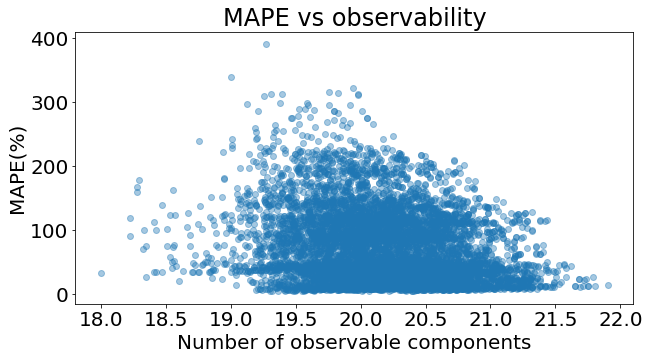

In [195]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5)) 
plt.scatter(observablity_score_list_18, MAPE_list_18, alpha=0.4)
plt.title("MAPE vs observability")
plt.xlabel("Number of observable components")
plt.ylabel("MAPE(%)")
plt.show()

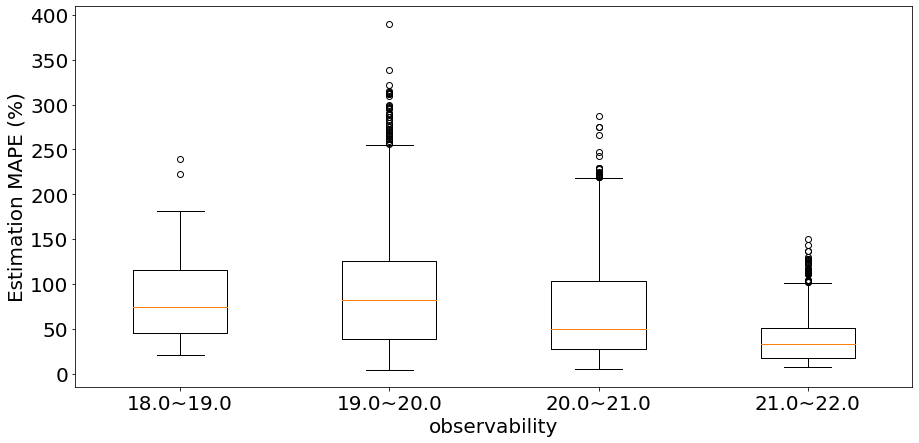

In [218]:
bin_num = int((max(observablity_score_list_18)-min(observablity_score_list_18))//1+1)
bin_x = [None] * bin_num
bin_data = [None] * bin_num

for i in range(bin_num):
    bin_start = min(observablity_score_list_18) + i
    bin_end = min(observablity_score_list_18) + (i+1)
    bin_x[i] = str(bin_start)+'~'+str(bin_end)
    bin_data[i] = np.array(MAPE_list_18)[(np.array(observablity_score_list_18)>bin_start) 
                                      & (np.array(observablity_score_list_18)<bin_end)]
    
fig = plt.figure(figsize =(15, 7))
plt.boxplot(bin_data)

plt.xticks(list(np.arange(bin_num)+1), bin_x)
plt.xlabel("observability")
plt.ylabel("Estimation MAPE (%)")

# show plot
plt.show()    

In [202]:
bin_data[7]

array([46.1804, 26.4193, 45.8923, 23.7161, 12.6468, 13.5795, 40.6185,
       47.1811, 24.3095, 13.2422, 13.1749, 44.017 , 23.7737, 12.7613,
       19.3083, 13.087 , 22.5666, 11.4512, 16.8589, 26.8939, 14.7492,
       35.9717, 26.8912])

In [221]:
df["Observability"] = observablity_score_list_18

In [223]:
df.to_csv("18sensors.csv")

In [216]:
np.where(np.array(MAPE_list_18)==max(MAPE_list_18))


(array([5816]),)

In [229]:
max(MAPE_list_18)

390.2199

In [243]:
    PI = compute_PI(A_list1, mode_transition_num1)

    sensor_loc = (0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21)
    vect = np.zeros(n)
    vect[np.array(sensor_loc)]  = 1
    C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

    y_k = list()
    for i in range(T):
        y_k.append(C@density_list[i])

    x_list, mu_list = IMM_filter_reduced(A_list1,PI)
    obs_score_18 = observablity_score(A_list, C, w)
    
    print(compute_error(x_list, density_list))

19.271944444444443


In [245]:
print(compute_error(x_list, density_list))

3.902198079136372


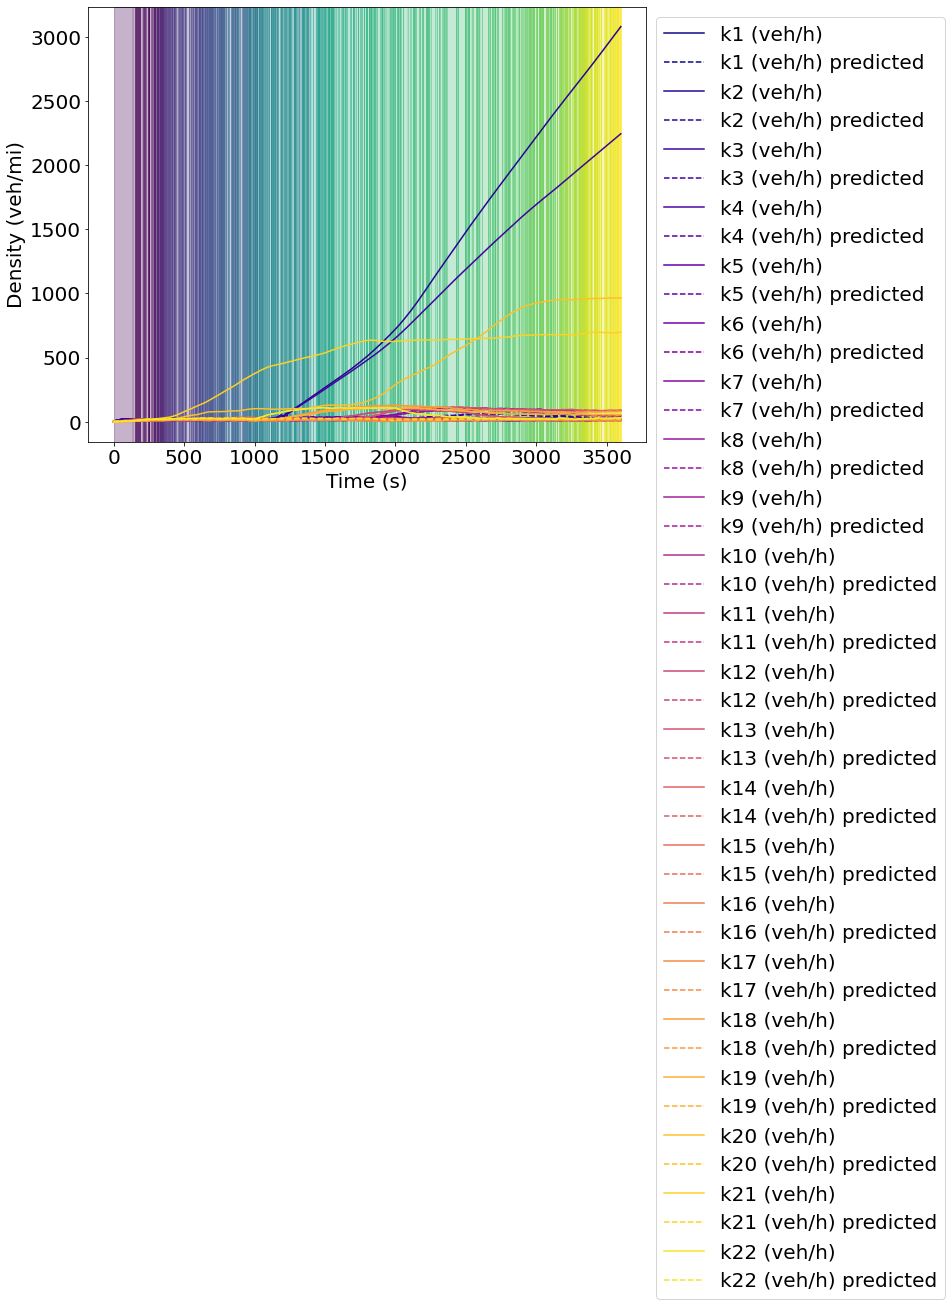

In [228]:
plot_2densities(x_list, density_list)

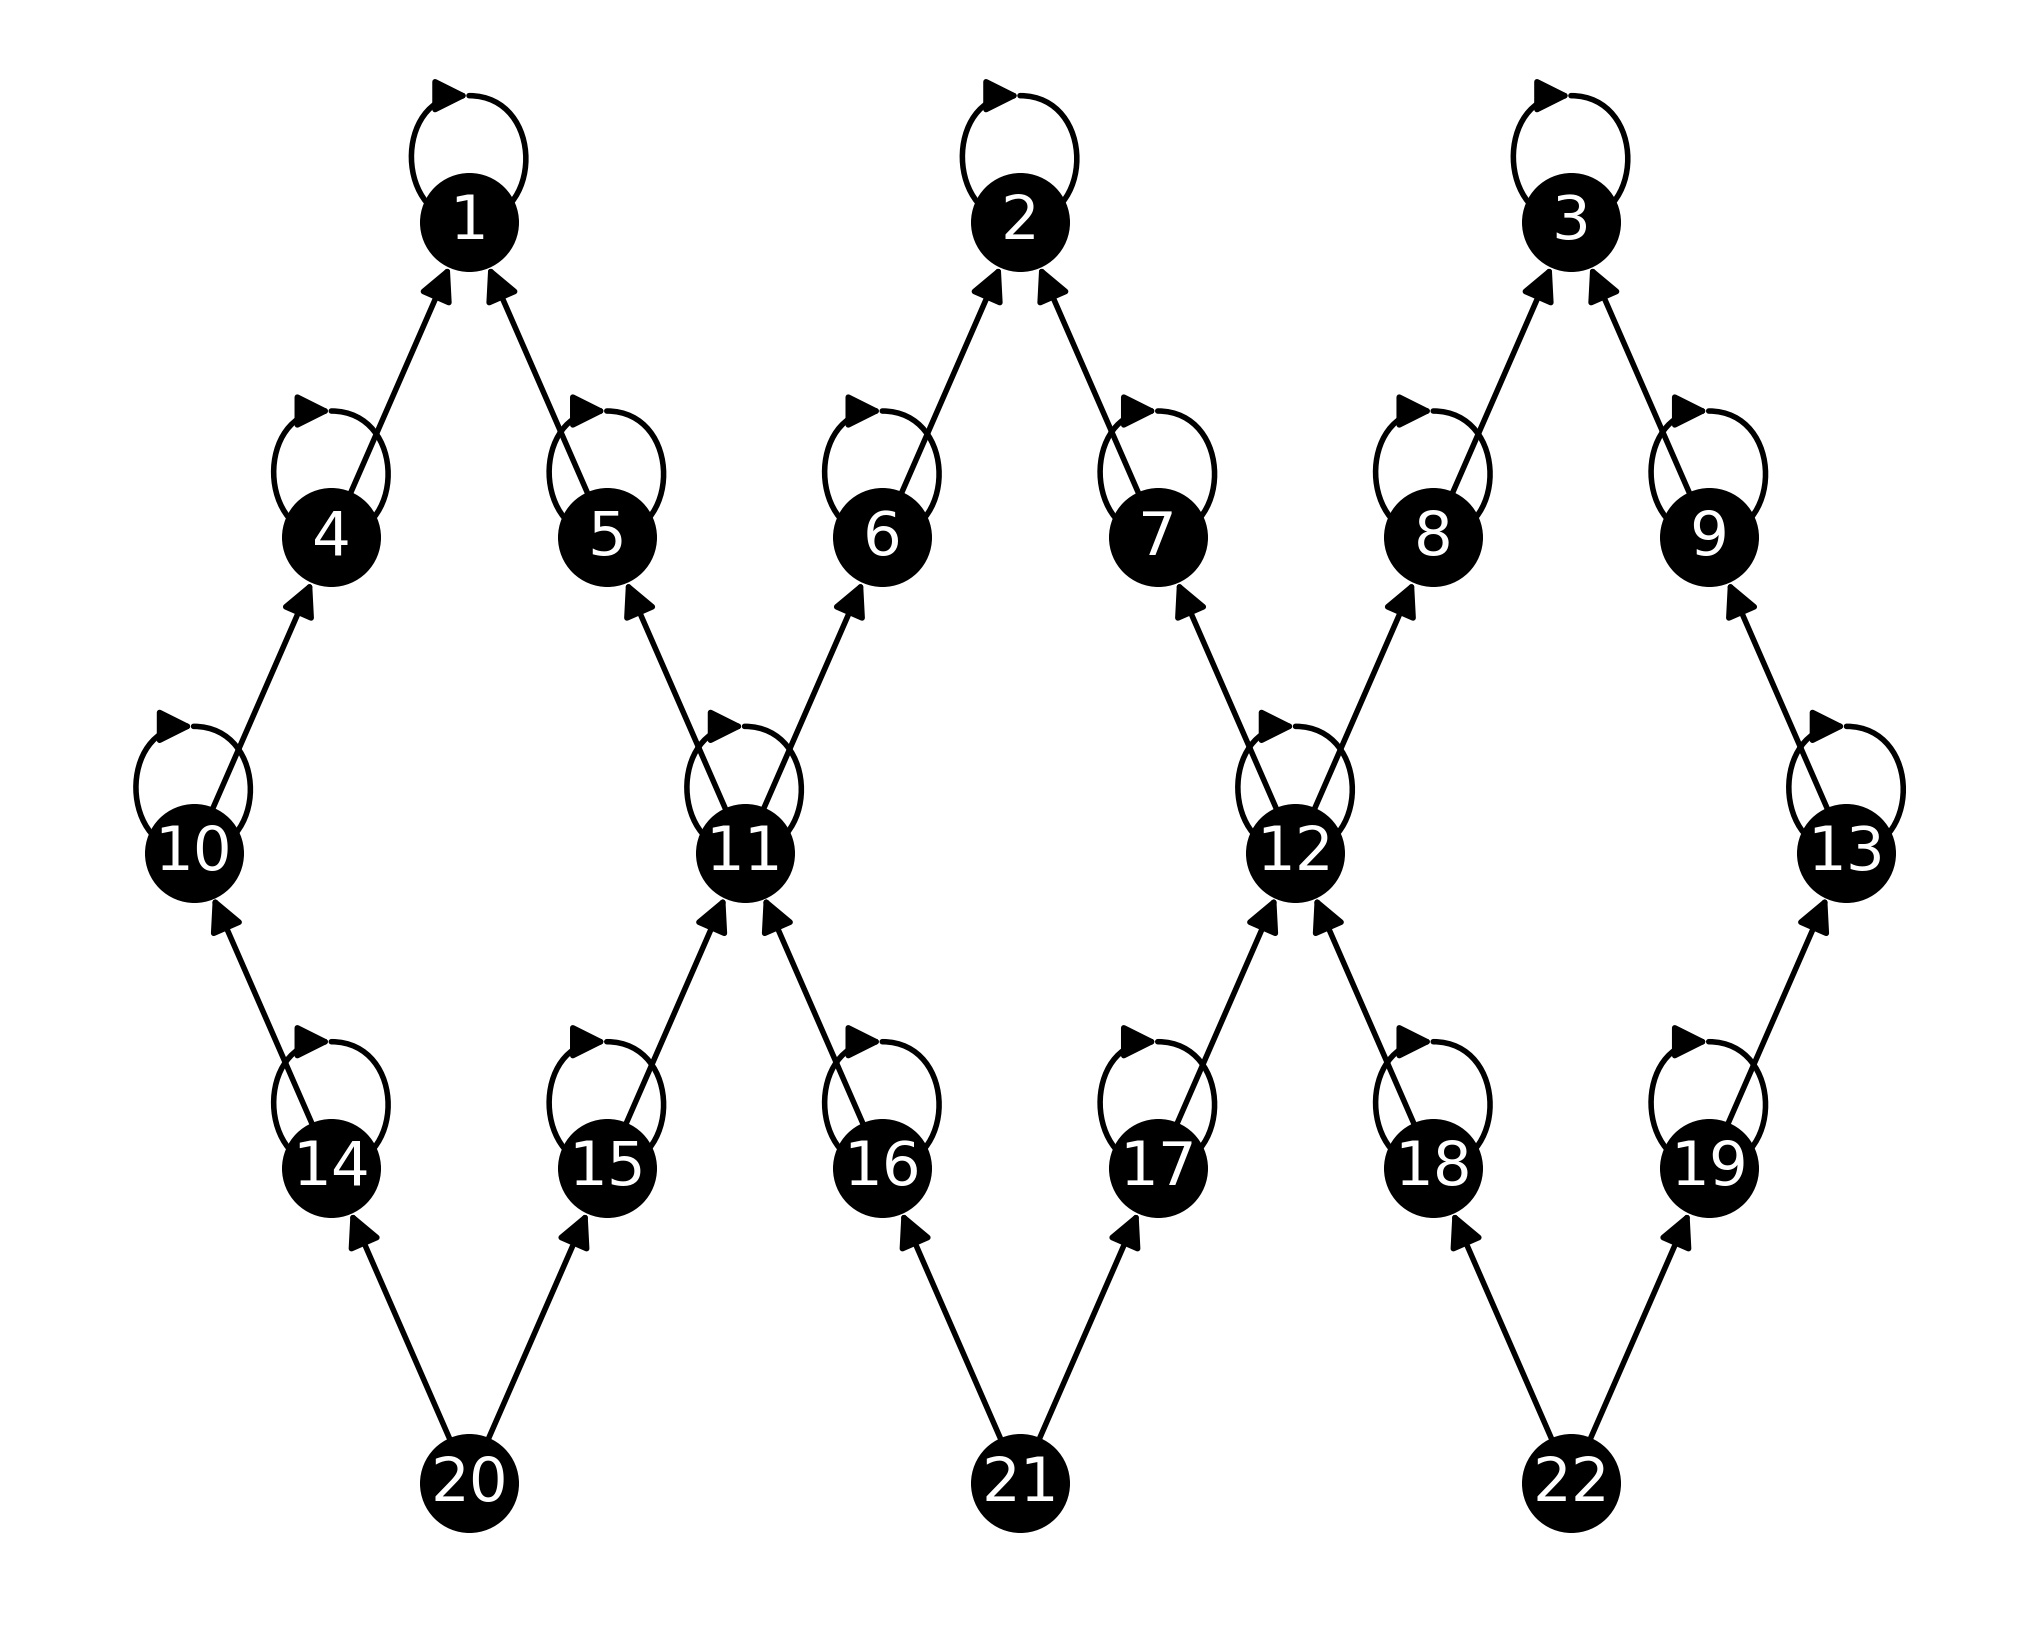

In [48]:
import matplotlib.pyplot as plt
import networkx as nx
plt.figure(figsize=(10,8), dpi=200)

G = nx.DiGraph() 

adjacent = A

for i in range(22): 
    for j in range(22): 
        if adjacent[i][j] != 0: 
            G.add_edge(i,j) 
            

pos = nx.planar_layout(G,scale=0.2)

mapping = {}
for i in range(22):
    mapping[i] = i+1
mapping
G = nx.relabel_nodes(G, mapping)
pos[1] = [0.09090909,1]
pos[2] = [0.45454545,1]
pos[3] = [0.81818182,1]
pos[4] = [0, 0.75]
pos[5] = [0.18181818, 0.75]
pos[6] = [0.36363636, 0.75]
pos[7] = [0.54545455, 0.75]
pos[8] = [0.72727273, 0.75]
pos[9] = [0.90909091, 0.75]

pos[10]  = [-0.09090909, 0.5]
pos[11] = [0.27272727, 0.5]
pos[12] = [0.63636364, 0.5]
pos[13] = [1, 0.5]

pos[14] = [0, 0.25]
pos[15] = [0.18181818, 0.25]
pos[16] = [0.36363636, 0.25]
pos[17] = [0.54545455, 0.25]
pos[18] = [0.72727273, 0.25]
pos[19] = [0.90909091, 0.25]

pos[20] = [0.09090909,0]
pos[21] = [0.45454545,0]
pos[22] = [0.81818182,0]



nx.draw(G, pos,with_labels = True, node_size = 1200,node_color="black",
        width=2, font_color='white',font_size=22, arrowsize=25) 

plt.show() 

In [43]:
# sensor location optimization
import numpy as np
import pandas as pd
import cvxpy as cp
K = 8 # number of modes
p = 4# number of sensors to place
n = 22 # number of total states
# define variables
z = cp.Variable(n, boolean=True)
x = cp.Variable((K,n))

In [54]:
A = []
for matrix in A_list1:
    temp_matrix = np.zeros((22,22))
    temp_matrix[matrix>0] =1 
    A.append(temp_matrix - np.diag(np.diagonal(temp_matrix)))
A = np.array(A)
w = np.fromiter(A_dict1.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))

In [57]:
# define constraints & objectives
constraints = []
ones = np.ones(n).reshape(n,1)
for k in range(K):
    constraints += [ones.T @ z >= p, ones.T @ z <= p]
    constraints += [z<=1]
    constraints += [z>=0]
    constraints += [x[k]>=0]
    
    #constraints += [x[k]>=z]
    constraints += [x[k]<=1]
    #constraints += [A_start[k]@x[k] <= A_end[k]@x[k]]
    constraints += [x[k] <= (A[k].T)@x[k] + z]
constraints += [z>=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]
# constraints += [z<=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]

objective = cp.Maximize(w.T@(x@ones))

In [58]:
prob = cp.Problem(objective, constraints)
prob.solve()

12.398888888888889

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   ],
       [0.015, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   ],
       [0.015, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.015, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   

In [92]:
x_opt = x.value
w_opt = (x_opt * w.reshape(8,1).round(2)).sum(axis = 0)

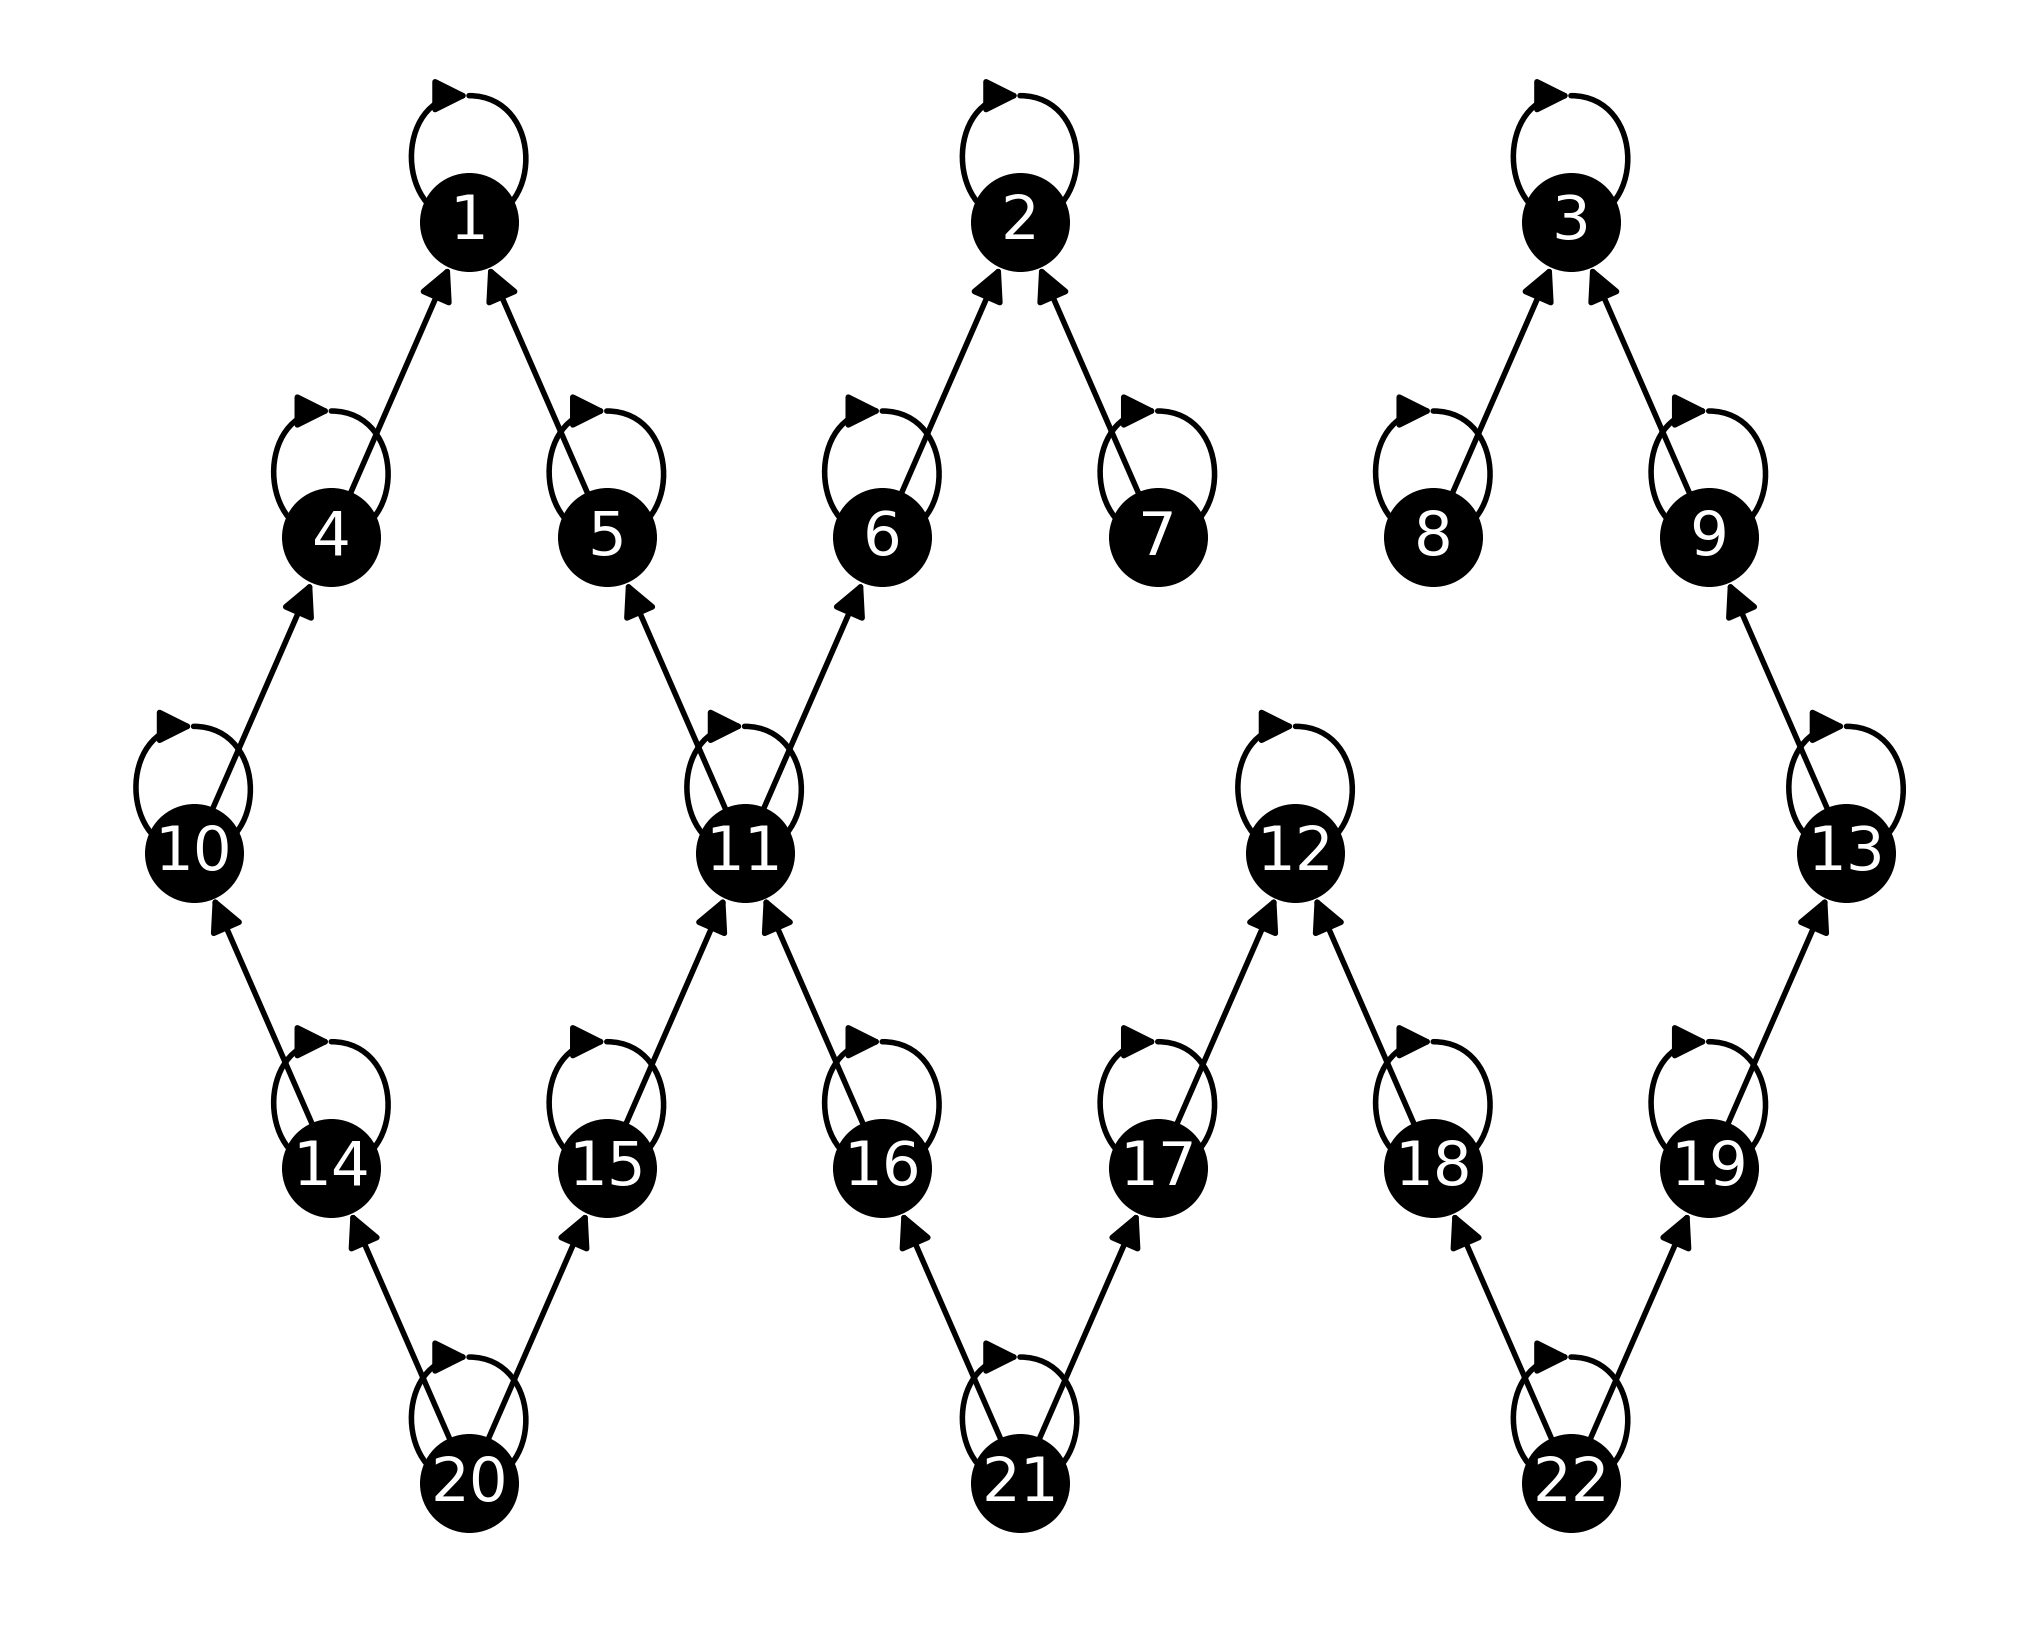

In [77]:
import matplotlib.pyplot as plt
import networkx as nx
plt.figure(figsize=(10,8), dpi=200)

G = nx.DiGraph() 

adjacent = A_list[12]

for i in range(22): 
    for j in range(22): 
        if adjacent[i][j] != 0: 
            G.add_edge(i,j) 
            

pos = nx.planar_layout(G,scale=0.2)

mapping = {}
for i in range(22):
    mapping[i] = i+1
mapping
G = nx.relabel_nodes(G, mapping)
pos[1] = [0.09090909,1]
pos[2] = [0.45454545,1]
pos[3] = [0.81818182,1]
pos[4] = [0, 0.75]
pos[5] = [0.18181818, 0.75]
pos[6] = [0.36363636, 0.75]
pos[7] = [0.54545455, 0.75]
pos[8] = [0.72727273, 0.75]
pos[9] = [0.90909091, 0.75]

pos[10]  = [-0.09090909, 0.5]
pos[11] = [0.27272727, 0.5]
pos[12] = [0.63636364, 0.5]
pos[13] = [1, 0.5]

pos[14] = [0, 0.25]
pos[15] = [0.18181818, 0.25]
pos[16] = [0.36363636, 0.25]
pos[17] = [0.54545455, 0.25]
pos[18] = [0.72727273, 0.25]
pos[19] = [0.90909091, 0.25]

pos[20] = [0.09090909,0]
pos[21] = [0.45454545,0]
pos[22] = [0.81818182,0]



nx.draw(G, pos,with_labels = True, node_size = 1200,node_color="black",
        width=2, font_color='white',font_size=22, arrowsize=25) 

plt.show() 

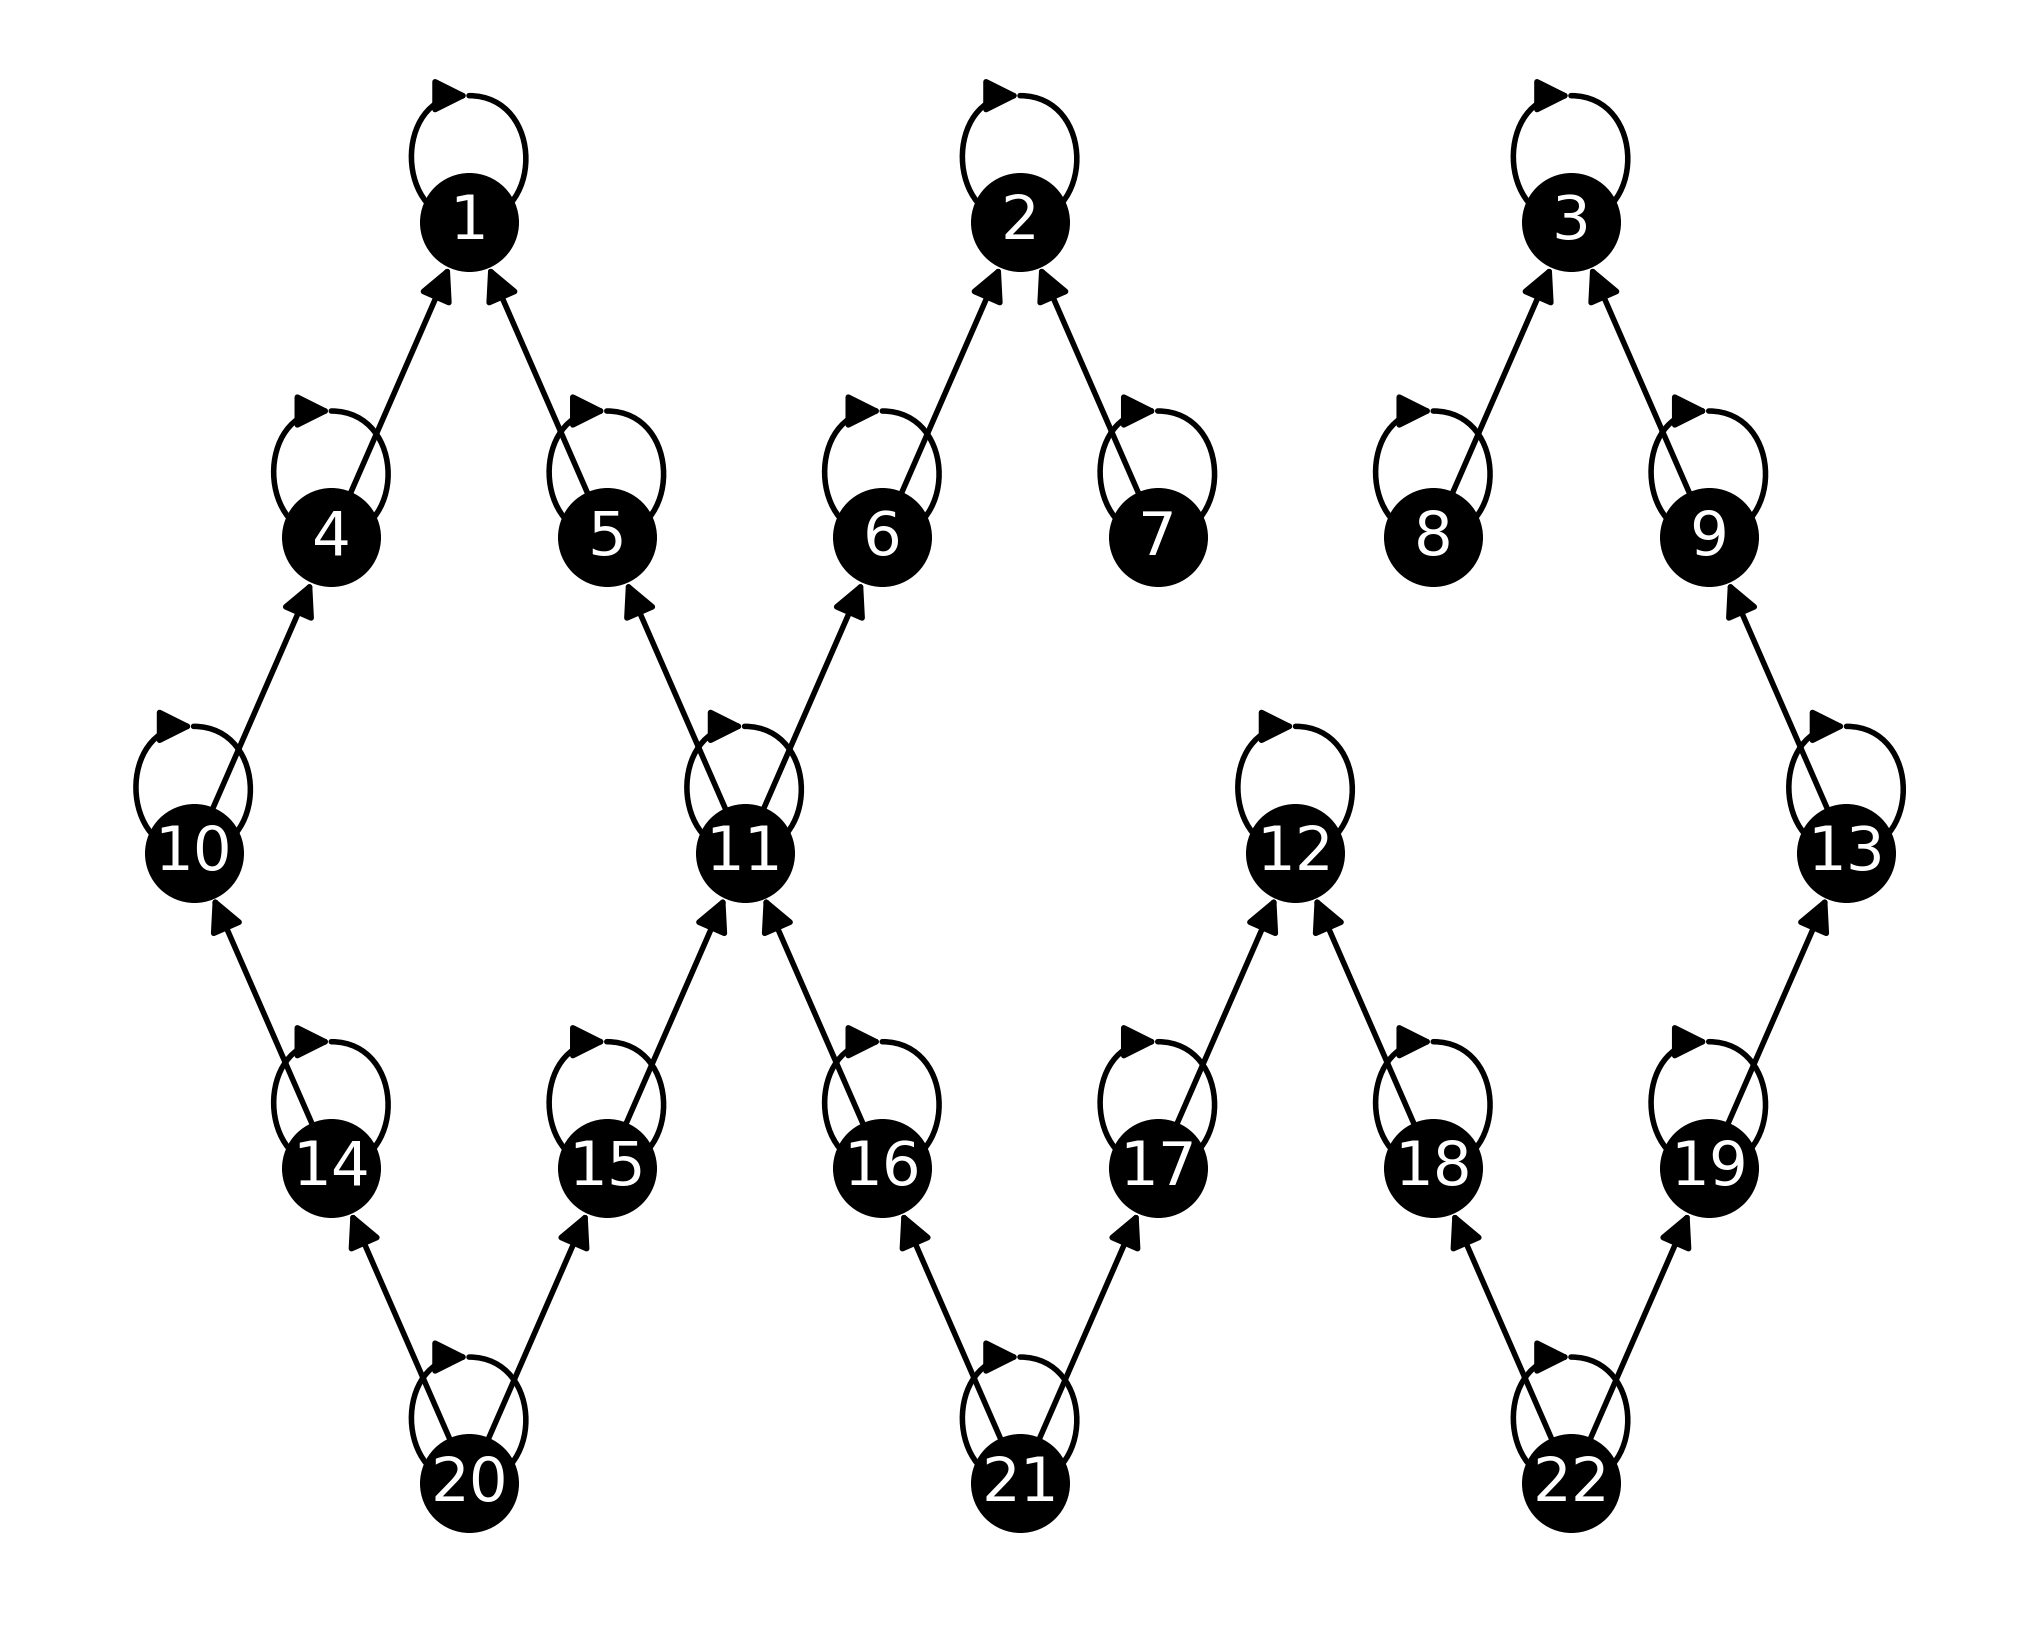

In [72]:
import matplotlib.pyplot as plt
import networkx as nx
plt.figure(figsize=(10,8), dpi=200)

G = nx.DiGraph() 

adjacent = A_list[12]

for i in range(22): 
    for j in range(22): 
        if adjacent[i][j] != 0: 
            G.add_edge(i,j) 
            

pos = nx.planar_layout(G,scale=0.2)

mapping = {}
for i in range(22):
    mapping[i] = i+1
mapping
G = nx.relabel_nodes(G, mapping)
pos[1] = [0.09090909,1]
pos[2] = [0.45454545,1]
pos[3] = [0.81818182,1]
pos[4] = [0, 0.75]
pos[5] = [0.18181818, 0.75]
pos[6] = [0.36363636, 0.75]
pos[7] = [0.54545455, 0.75]
pos[8] = [0.72727273, 0.75]
pos[9] = [0.90909091, 0.75]

pos[10]  = [-0.09090909, 0.5]
pos[11] = [0.27272727, 0.5]
pos[12] = [0.63636364, 0.5]
pos[13] = [1, 0.5]

pos[14] = [0, 0.25]
pos[15] = [0.18181818, 0.25]
pos[16] = [0.36363636, 0.25]
pos[17] = [0.54545455, 0.25]
pos[18] = [0.72727273, 0.25]
pos[19] = [0.90909091, 0.25]

pos[20] = [0.09090909,0]
pos[21] = [0.45454545,0]
pos[22] = [0.81818182,0]



nx.draw(G, pos,with_labels = True, node_size = 1200,node_color="black",
        width=2, font_color='white',font_size=22, arrowsize=25) 

plt.show() 

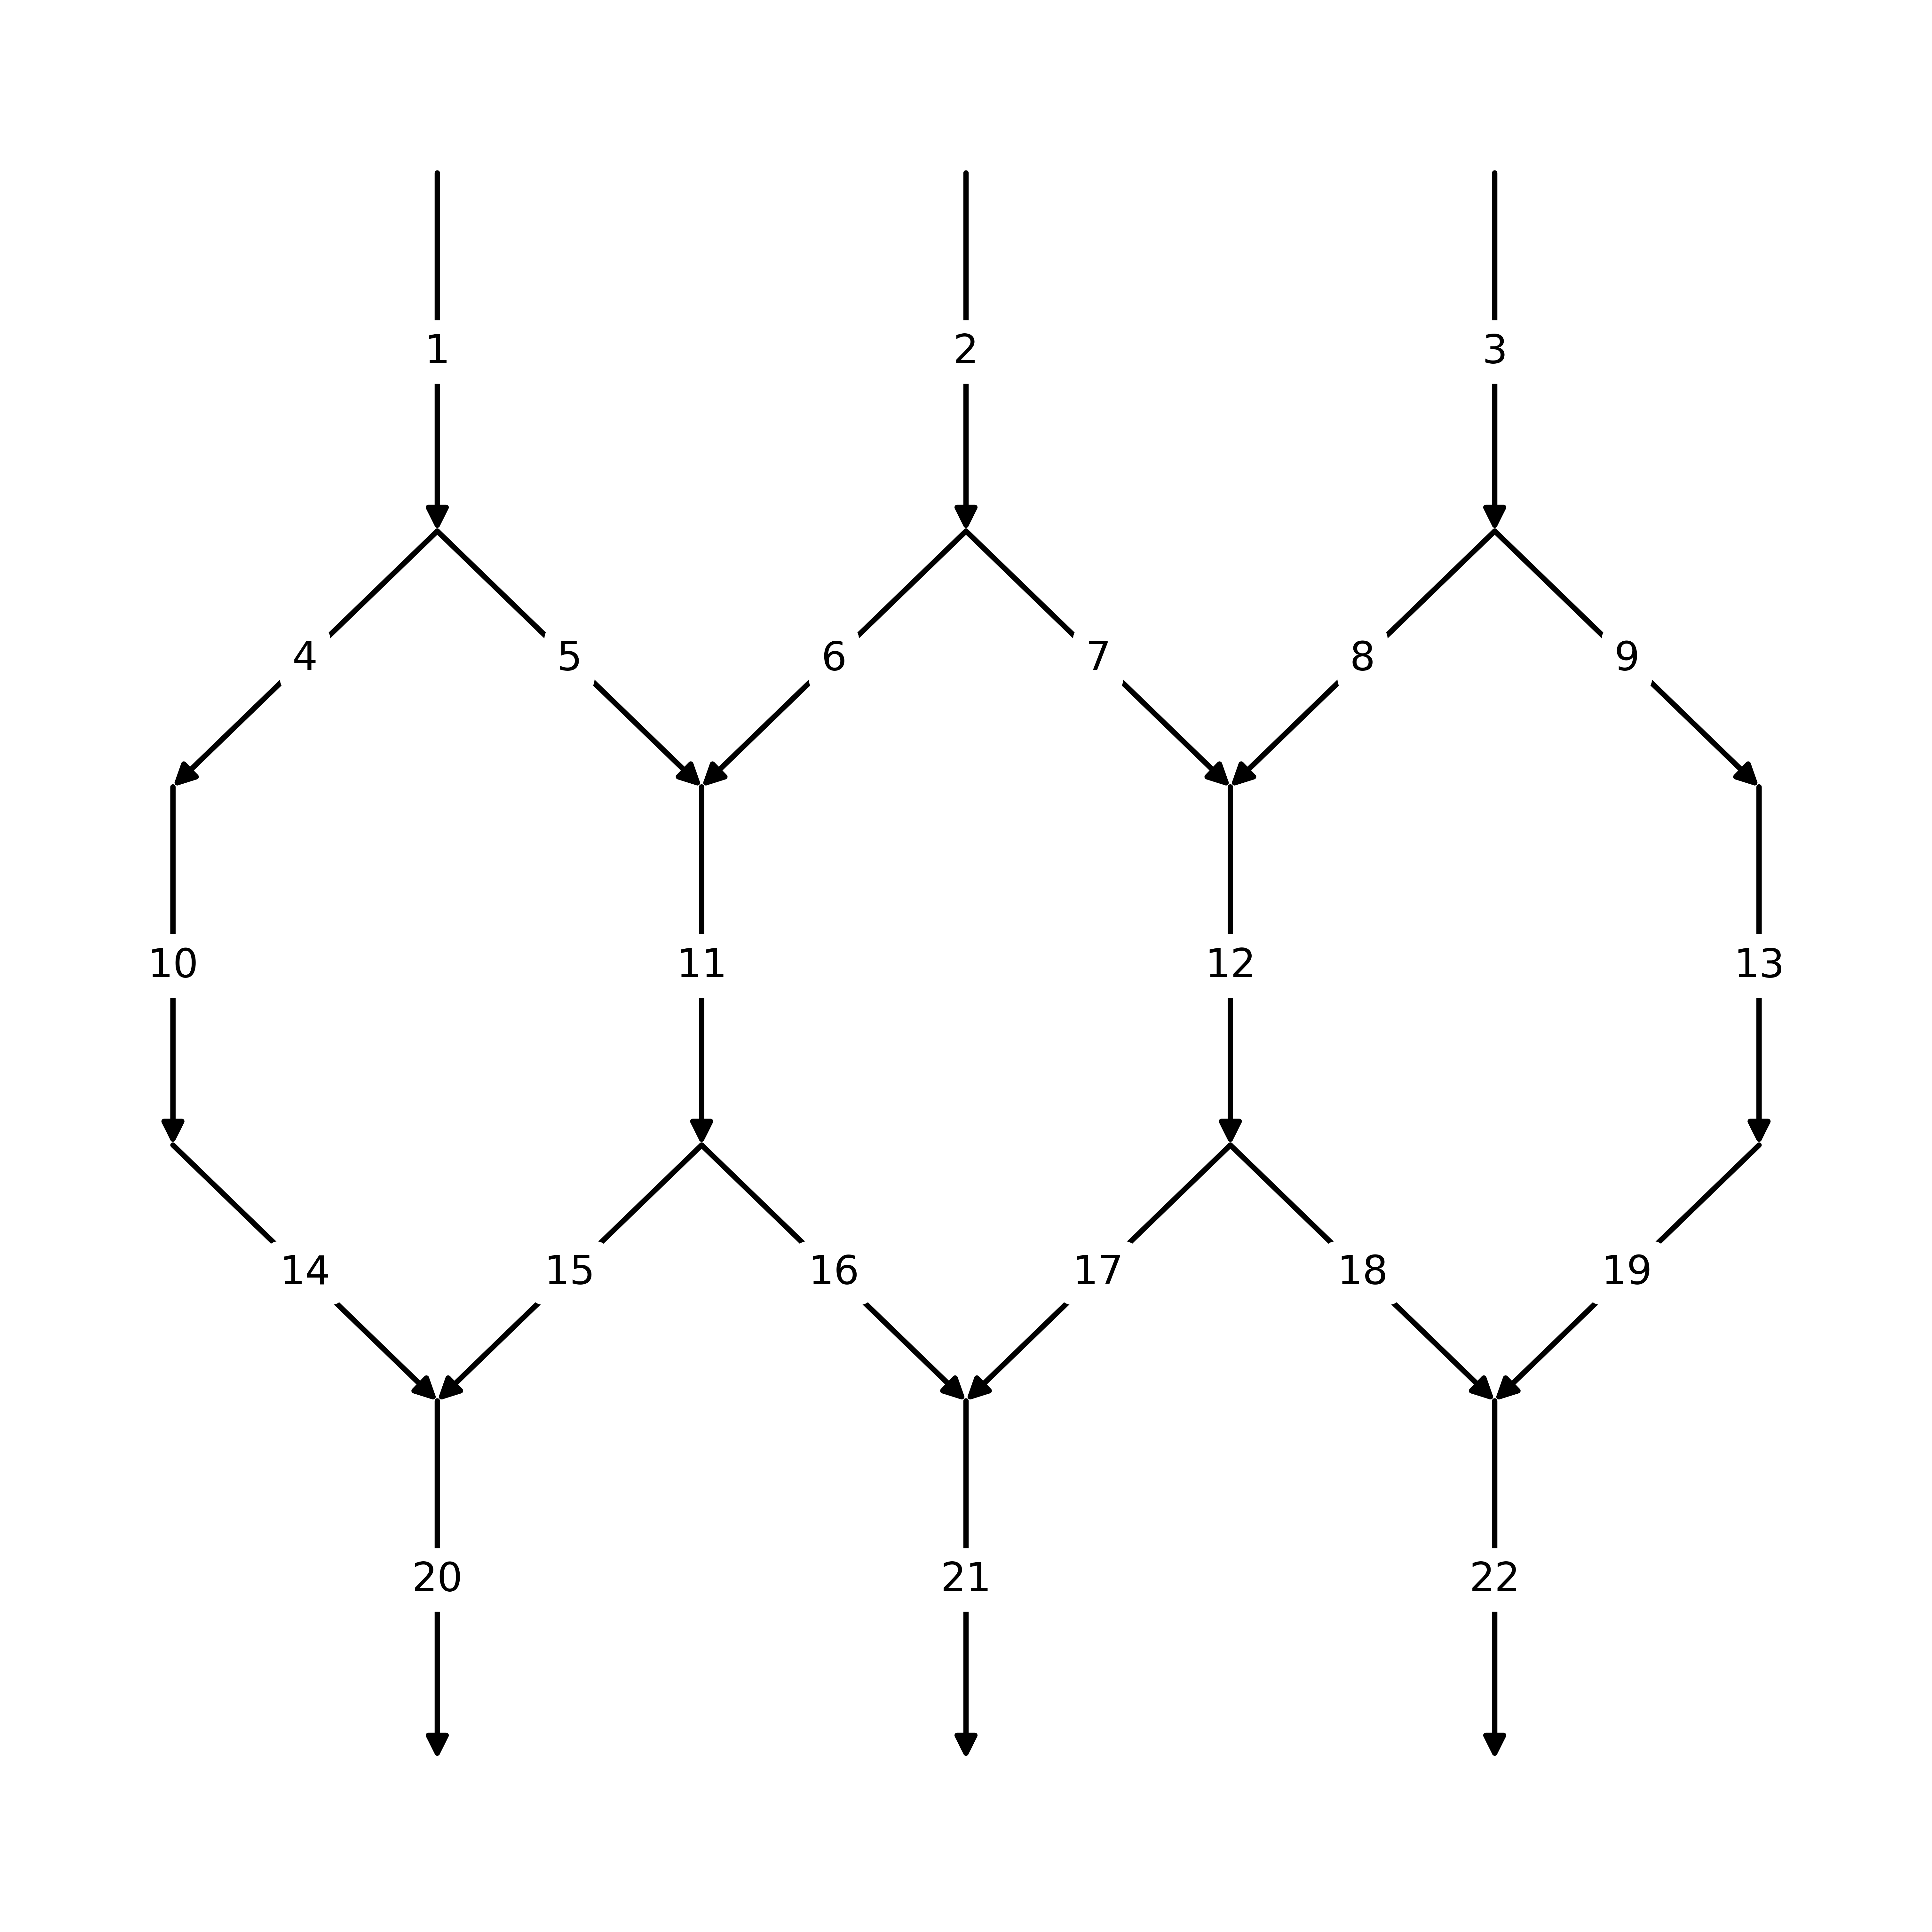

In [204]:
G = nx.DiGraph() 
graph_links = [(1,4),(2,5),(3,6),(4,7),(4,8),(5,8),(5,9),(6,9),(6,10),(7,11),(8,12),(9,13),(10,14),
              (11,15),(12,15),(12,16),(13,16),(13,17),(14,17),(15,18),(16,19),(17,20)]
for i,j in graph_links: 
    G.add_edge(i,j) 
            
pos = nx.planar_layout(G,scale=0.2)
pos[1] = [1,6.2]
pos[2] = [3,6.2]
pos[3] = [5,6.2]
pos[4] = [1,4.8]
pos[5] = [3,4.8]
pos[6] = [5,4.8]
pos[7] = [0, 3.8]
pos[8] = [2, 3.8]
pos[9] = [4, 3.8]
pos[10]  = [6, 3.8]

pos[11] = [0, 2.4]
pos[12] = [2, 2.4]
pos[13] = [4, 2.4]
pos[14] = [6, 2.4]

pos[15] = [1, 1.4]
pos[16] = [3, 1.4]
pos[17] = [5, 1.4]

pos[18] = [1, 0]
pos[19] = [3, 0]
pos[20] = [5, 0]

edge_labels = {
    (1,4):1,(2,5):2,(3,6):3,
    (4,7):4,(4,8):5,(5,8):6,(5,9):7,(6,9):8,(6,10):9,
    (7,11):10,(8,12):11,(9,13):12,(10,14):13,
    (11,15):14,(12,15):15,(12,16):16,(13,16):17,(13,17):18,(14,17):19,
    (15,18):20,(16,19):21,(17,20):22
}

# myKeys = list(pos.keys())
# myKeys.sort()
# sorted_dict = {i: pos[i] for i in myKeys}
# pos = sorted_dict

plt.figure(figsize=(30,30), dpi=200)
nx.draw(G, pos,width = 6, with_labels = False, node_size = 0, arrowsize=50) 
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels,font_size=45,rotate =False,clip_on=False)
plt.show() 

In [207]:
edges = G.edges()
reorder_index_list = [edge_labels[(u,v)] for u,v in edges]


[1, 4, 5, 2, 6, 7, 3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

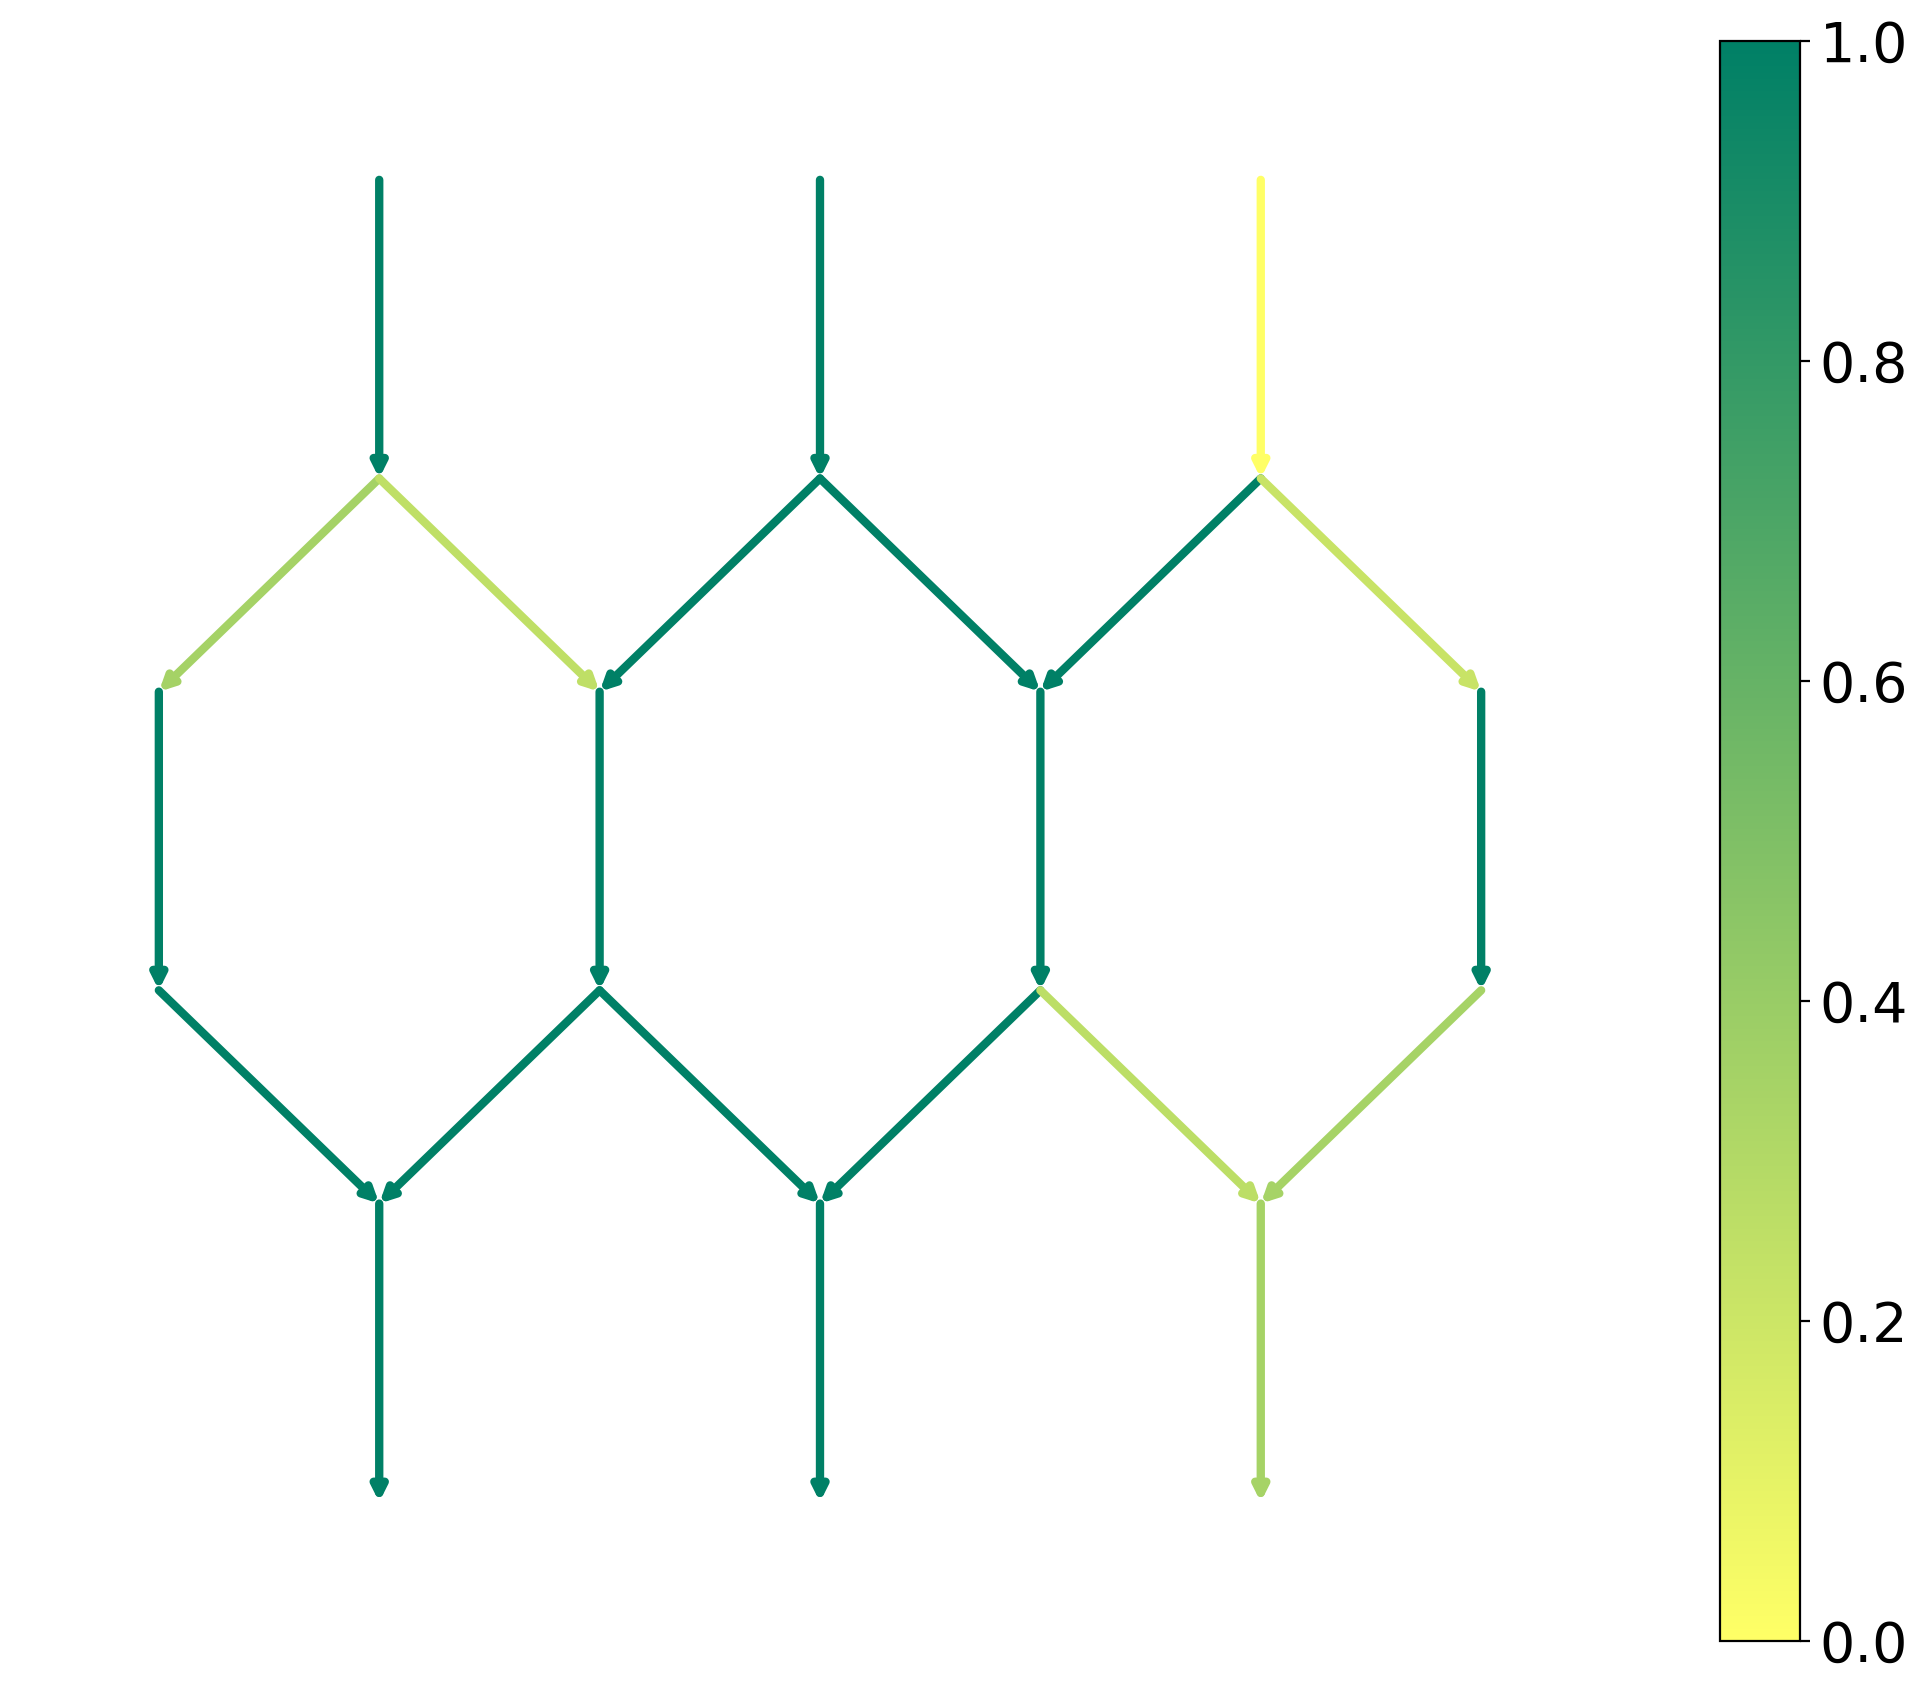

In [174]:
import matplotlib
plt.figure(figsize=(10,8), dpi=200)
cmap = matplotlib.cm.get_cmap('summer_r')
GnRd = colors.LinearSegmentedColormap('GnRd', cdict)
nx.draw(G, pos,with_labels = False,width=3, node_size = 0,edge_cmap=cmap,edge_color =w_opt) 
# nx.draw_networkx_edge_labels(G, pos, edge_labels = dict(zip(list(edge_labels),w_opt.round(2))))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm)

In [258]:
# sensor location optimization
import numpy as np
import pandas as pd
import cvxpy as cp
K = 8 # number of modes
p = 4# number of sensors to place
n = 22 # number of total states
# define variables
z = cp.Variable(n, boolean=True)
x = cp.Variable((K,n))

A = []
for matrix in A_list1:
    temp_matrix = np.zeros((22,22))
    temp_matrix[matrix>0] =1 
    A.append(temp_matrix - np.diag(np.diagonal(temp_matrix)))
A = np.array(A)
w = np.fromiter(A_dict1.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))

# define constraints & objectives
constraints = []
ones = np.ones(n).reshape(n,1)
for k in range(K):
    constraints += [ones.T @ z >= p, ones.T @ z <= p]
    constraints += [z<=1]
    constraints += [z>=0]
    constraints += [x[k]>=0]
    
    #constraints += [x[k]>=z]
    constraints += [x[k]<=1]
    #constraints += [A_start[k]@x[k] <= A_end[k]@x[k]]
    constraints += [x[k] <= (A[k].T)@x[k] + z]
# constraints += [z>=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]
# constraints += [z<=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]

objective = cp.Maximize(w.T@(x@ones))

prob = cp.Problem(objective, constraints)
prob.solve()

z.value

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0.])

In [259]:
np.where(z.value>0)

(array([ 7, 12, 19, 20], dtype=int64),)

In [260]:
w_opt

array([1.        , 1.        , 1.        , 0.62666667, 1.        ,
       0.42416667, 0.54916667, 0.42416667, 0.54916667, 1.        ,
       1.        , 1.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.57611111, 0.62472222, 0.        ,
       0.        , 0.62472222])

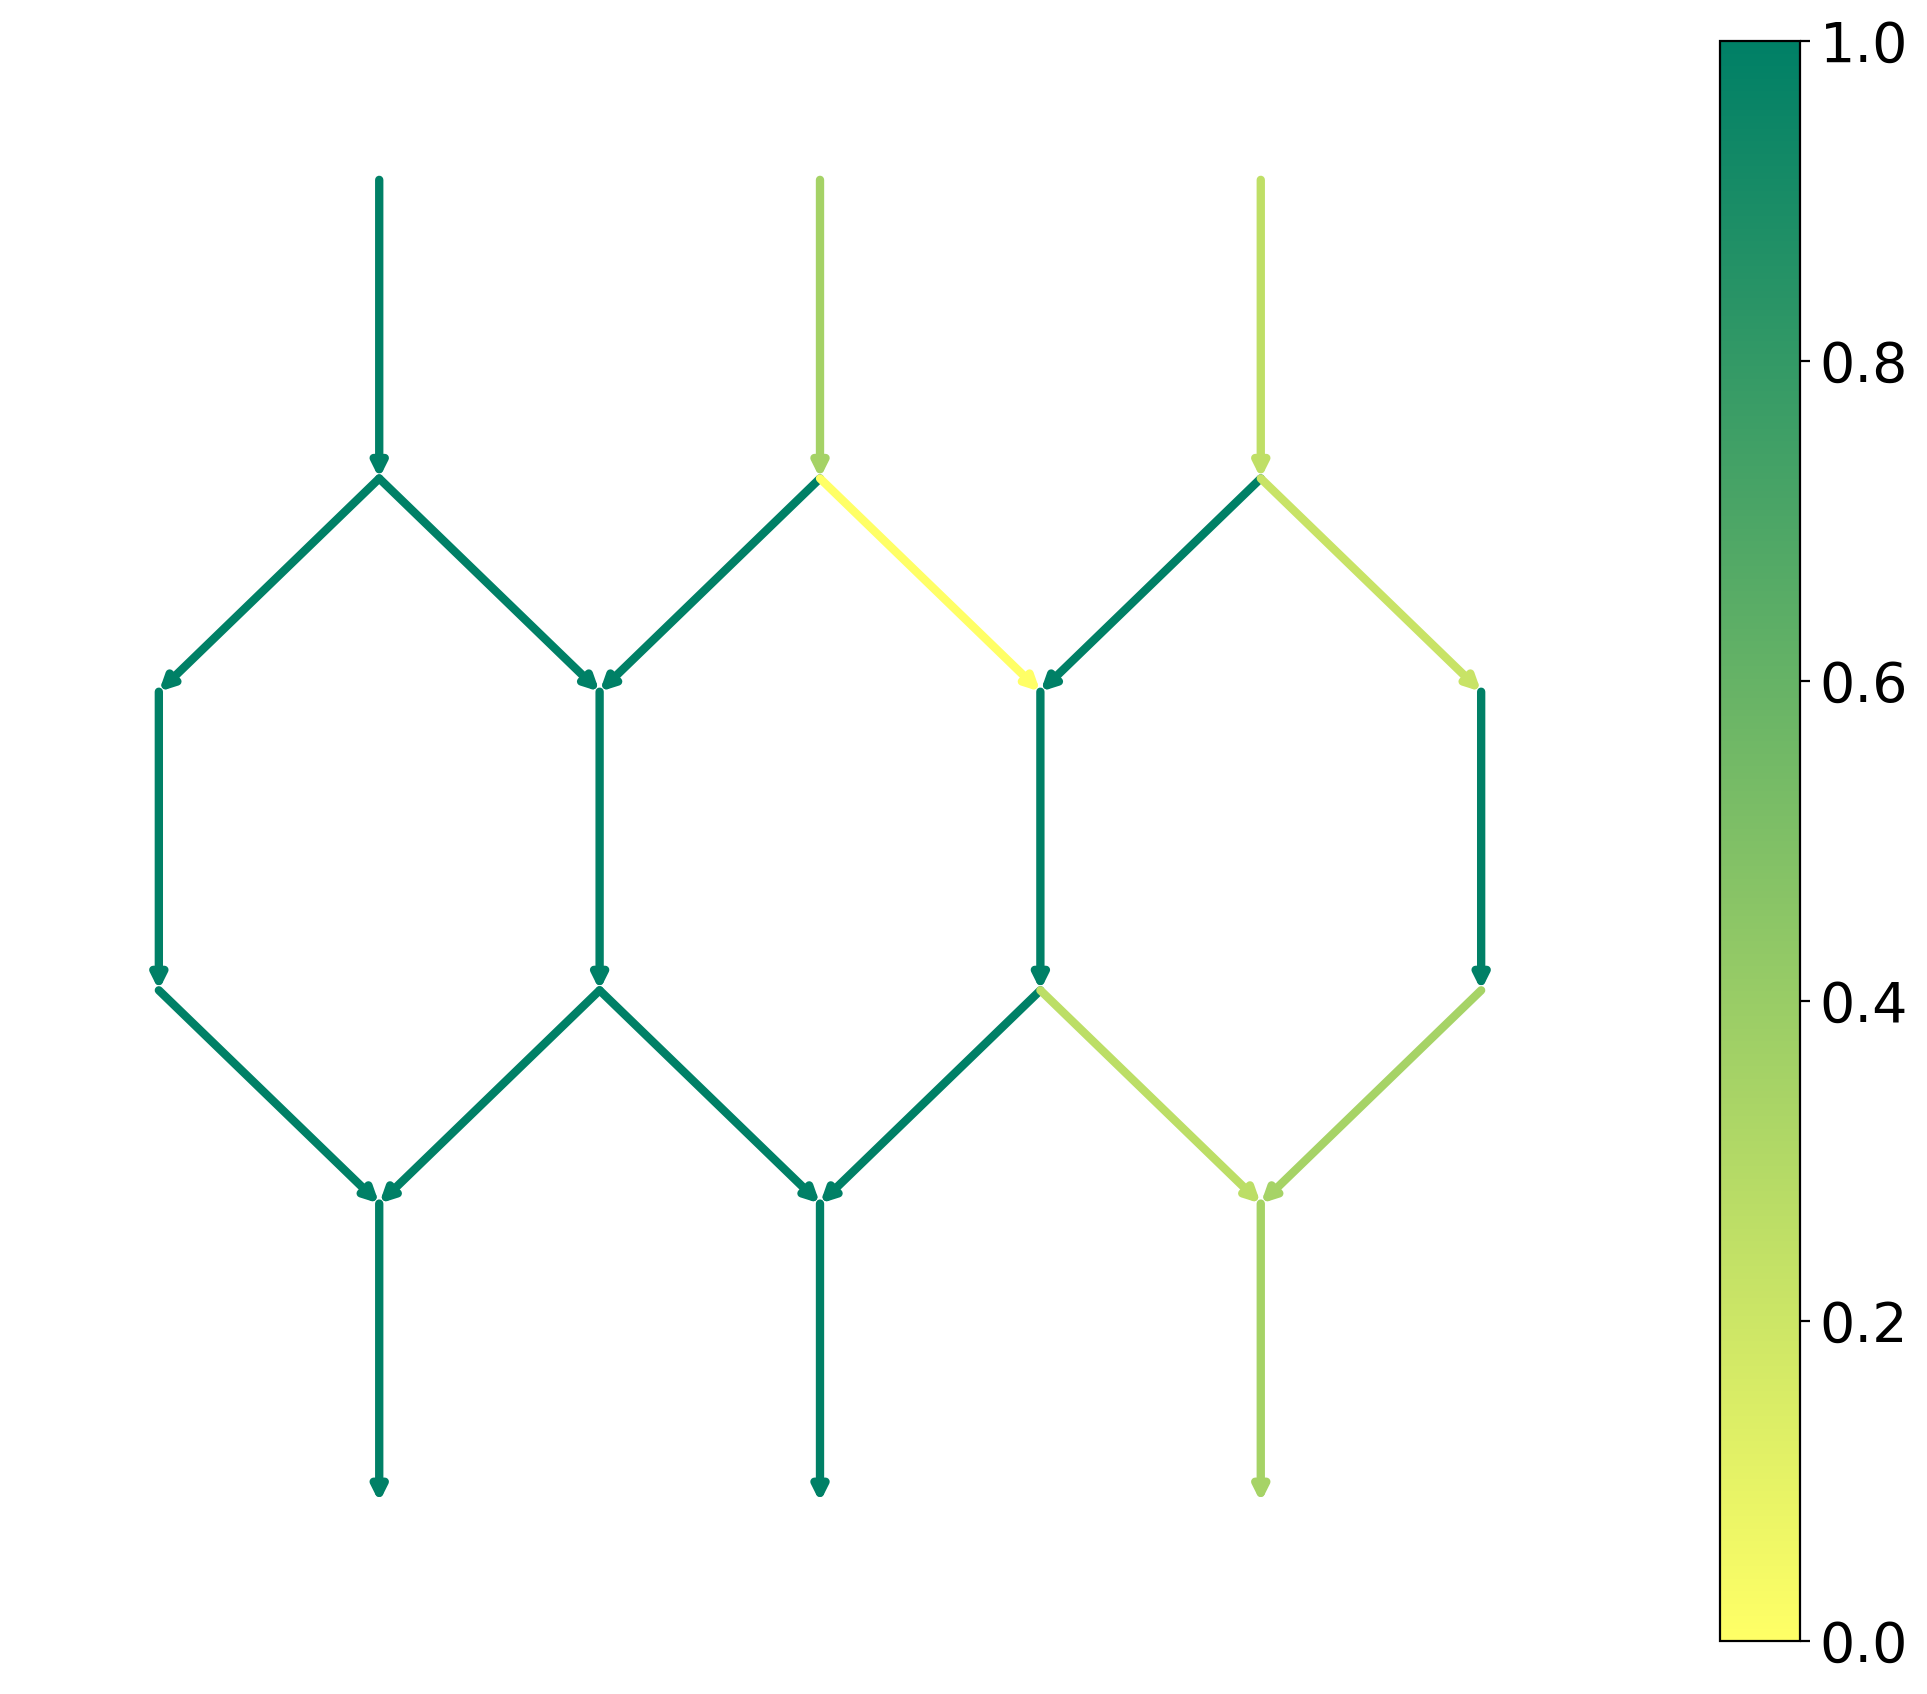

In [261]:
x_opt = x.value
w_opt = np.zeros(22)
w_unordered = (x_opt * w.reshape(8,1)).sum(axis = 0)
edges = G.edges()
reorder_index_list = [edge_labels[(u,v)] for u,v in edges]
for i,index in enumerate(reorder_index_list):
    w_opt[i] = w_unordered[index-1]


import matplotlib
plt.figure(figsize=(10,8), dpi=200)
cmap = matplotlib.cm.get_cmap('summer_r')
GnRd = colors.LinearSegmentedColormap('GnRd', cdict)

nx.draw(G, pos,with_labels = False,width=3, node_size = 0,edge_cmap=cmap,edge_color =w_opt) 
# nx.draw_networkx_edge_labels(G, pos, edge_labels = dict(zip(list(edge_labels),w_opt.round(2))))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm)

In [262]:
w_opt

array([1.        , 1.        , 1.        , 0.62666667, 1.        ,
       0.42388889, 0.56944444, 1.        , 0.54916667, 1.        ,
       1.        , 0.99972222, 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.57583333, 0.62472222, 1.        ,
       1.        , 0.62472222])

In [263]:
z.value

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0.])

## Find best sensor location for 16, 17, 18, 19


In [264]:
# sensor location optimization
import numpy as np
import pandas as pd
import cvxpy as cp
K = 585 # number of modes
p = 16# number of sensors to place
n = 22 # number of total states
# define variables
z = cp.Variable(n, boolean=True)
x = cp.Variable((K,n))

A = []
for matrix in A_list:
    temp_matrix = np.zeros((22,22))
    temp_matrix[matrix>0] =1 
    A.append(temp_matrix - np.diag(np.diagonal(temp_matrix)))
A = np.array(A)
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))

# define constraints & objectives
constraints = []
ones = np.ones(n).reshape(n,1)
for k in range(K):
    constraints += [ones.T @ z >= p, ones.T @ z <= p]
    constraints += [z<=1]
    constraints += [z>=0]
    constraints += [x[k]>=0]
    
    #constraints += [x[k]>=z]
    constraints += [x[k]<=1]
    #constraints += [A_start[k]@x[k] <= A_end[k]@x[k]]
    constraints += [x[k] <= (A[k].T)@x[k] + z]
# constraints += [z>=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]
# constraints += [z<=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]

objective = cp.Maximize(w.T@(x@ones))

prob = cp.Problem(objective, constraints)
prob.solve()

21.515000000000263

In [268]:
np.where(z.value>0)[0]+1

array([ 1,  2,  3,  5,  6,  7,  8,  9, 14, 15, 16, 17, 18, 19, 20, 21],
      dtype=int64)

In [120]:
PI = compute_PI(A_list1, mode_transition_num1)
vect = z.value
C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

y_k = list()
for i in range(T):
    y_k.append(C@density_list[i])

x_list, mu_list = IMM_filter_reduced(A_list1,PI)
obs_score = observability_score(A_list, C, w)

MAPE = np.round(compute_error(x_list, density_list)*100, 4)
print("Case", 1, '| MAPE (%) = ', MAPE,  "obs_num=", obs_score)

Case 1 | MAPE (%) =  53.6942 obs_num= 21.515


In [269]:
#17

# sensor location optimization
import numpy as np
import pandas as pd
import cvxpy as cp
K = 585 # number of modes
p = 17# number of sensors to place
n = 22 # number of total states
# define variables
z = cp.Variable(n, boolean=True)
x = cp.Variable((K,n))

A = []
for matrix in A_list:
    temp_matrix = np.zeros((22,22))
    temp_matrix[matrix>0] =1 
    A.append(temp_matrix - np.diag(np.diagonal(temp_matrix)))
A = np.array(A)
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))

# define constraints & objectives
constraints = []
ones = np.ones(n).reshape(n,1)
for k in range(K):
    constraints += [ones.T @ z >= p, ones.T @ z <= p]
    constraints += [z<=1]
    constraints += [z>=0]
    constraints += [x[k]>=0]
    
    #constraints += [x[k]>=z]
    constraints += [x[k]<=1]
    #constraints += [A_start[k]@x[k] <= A_end[k]@x[k]]
    constraints += [x[k] <= (A[k].T)@x[k] + z]
# constraints += [z>=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]
# constraints += [z<=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]

objective = cp.Maximize(w.T@(x@ones))

prob = cp.Problem(objective, constraints)
prob.solve()

21.73638888888916

In [270]:
np.where(z.value>0)[0]+1

array([ 1,  2,  3,  5,  6,  7,  8,  9, 14, 15, 16, 17, 18, 19, 20, 21, 22],
      dtype=int64)

In [122]:
PI = compute_PI(A_list1, mode_transition_num1)
vect = z.value
C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

y_k = list()
for i in range(T):
    y_k.append(C@density_list[i])

x_list, mu_list = IMM_filter_reduced(A_list1,PI)
obs_score = observability_score(A_list, C, w)

MAPE = np.round(compute_error(x_list, density_list)*100, 4)
print("Case", 2, '| MAPE (%) = ', MAPE,  "obs_num=", obs_score)

Case 2 | MAPE (%) =  16.9702 obs_num= 21.73638888888889


In [271]:
#18

# sensor location optimization
import numpy as np
import pandas as pd
import cvxpy as cp
K = 585 # number of modes
p = 18# number of sensors to place
n = 22 # number of total states
# define variables
z = cp.Variable(n, boolean=True)
x = cp.Variable((K,n))

A = []
for matrix in A_list:
    temp_matrix = np.zeros((22,22))
    temp_matrix[matrix>0] =1 
    A.append(temp_matrix - np.diag(np.diagonal(temp_matrix)))
A = np.array(A)
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))

# define constraints & objectives
constraints = []
ones = np.ones(n).reshape(n,1)
for k in range(K):
    constraints += [ones.T @ z >= p, ones.T @ z <= p]
    constraints += [z<=1]
    constraints += [z>=0]
    constraints += [x[k]>=0]
    
    #constraints += [x[k]>=z]
    constraints += [x[k]<=1]
    #constraints += [A_start[k]@x[k] <= A_end[k]@x[k]]
    constraints += [x[k] <= (A[k].T)@x[k] + z]
# constraints += [z>=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]
# constraints += [z<=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]

objective = cp.Maximize(w.T@(x@ones))

prob = cp.Problem(objective, constraints)
prob.solve()

21.903888888889163

In [272]:
np.where(z.value>0)[0]+1

array([ 1,  2,  3,  5,  6,  7,  8,  9, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22], dtype=int64)

In [124]:
PI = compute_PI(A_list1, mode_transition_num1)
vect = z.value
C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

y_k = list()
for i in range(T):
    y_k.append(C@density_list[i])

x_list, mu_list = IMM_filter_reduced(A_list1,PI)
obs_score = observability_score(A_list, C, w)

MAPE = np.round(compute_error(x_list, density_list)*100, 4)
print("Case", 2, '| MAPE (%) = ', MAPE,  "obs_num=", obs_score)

Case 2 | MAPE (%) =  14.8644 obs_num= 21.90388888888889


In [273]:
#19

# sensor location optimization
import numpy as np
import pandas as pd
import cvxpy as cp
K = 585 # number of modes
p = 19# number of sensors to place
n = 22 # number of total states
# define variables
z = cp.Variable(n, boolean=True)
x = cp.Variable((K,n))

A = []
for matrix in A_list:
    temp_matrix = np.zeros((22,22))
    temp_matrix[matrix>0] =1 
    A.append(temp_matrix - np.diag(np.diagonal(temp_matrix)))
A = np.array(A)
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))

# define constraints & objectives
constraints = []
ones = np.ones(n).reshape(n,1)
for k in range(K):
    constraints += [ones.T @ z >= p, ones.T @ z <= p]
    constraints += [z<=1]
    constraints += [z>=0]
    constraints += [x[k]>=0]
    
    #constraints += [x[k]>=z]
    constraints += [x[k]<=1]
    #constraints += [A_start[k]@x[k] <= A_end[k]@x[k]]
    constraints += [x[k] <= (A[k].T)@x[k] + z]
# constraints += [z>=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]
# constraints += [z<=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]

objective = cp.Maximize(w.T@(x@ones))

prob = cp.Problem(objective, constraints)
prob.solve()

21.960000000000278

In [274]:
np.where(z.value>0)[0]+1

array([ 1,  2,  3,  5,  6,  7,  8,  9, 11, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22], dtype=int64)

In [126]:
PI = compute_PI(A_list1, mode_transition_num1)
vect = z.value
C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

y_k = list()
for i in range(T):
    y_k.append(C@density_list[i])

x_list, mu_list = IMM_filter_reduced(A_list1,PI)
obs_score = observability_score(A_list, C, w)

MAPE = np.round(compute_error(x_list, density_list)*100, 4)
print("Case", 2, '| MAPE (%) = ', MAPE,  "obs_num=", obs_score)

Case 2 | MAPE (%) =  11.4107 obs_num= 21.96


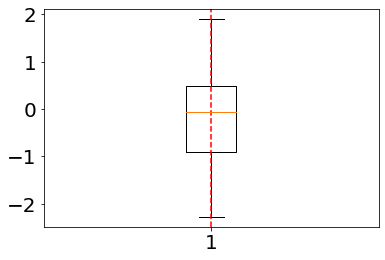

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = np.random.randn(100)

# Create a box plot
plt.boxplot(data)

# Add a red dashed line at y=2
plt.axhline(y=2, color='red', linestyle='--')

# Show the plot
plt.show()

In [203]:
pos

{0: array([-0.08236701, -0.074631  ]),
 1: array([-0.15404749, -0.19017892]),
 2: array([ 0.27769269, -0.02757236]),
 3: array([ 0.00966235, -0.15957929]),
 4: array([-0.52204376,  0.80739594]),
 5: array([ 0.19104854, -0.16537181]),
 6: array([0.44660435, 0.03806287]),
 7: array([ 0.146602, -1.      ]),
 8: array([-0.39672025,  0.8054743 ]),
 9: array([ 0.08356857, -0.03359972])}

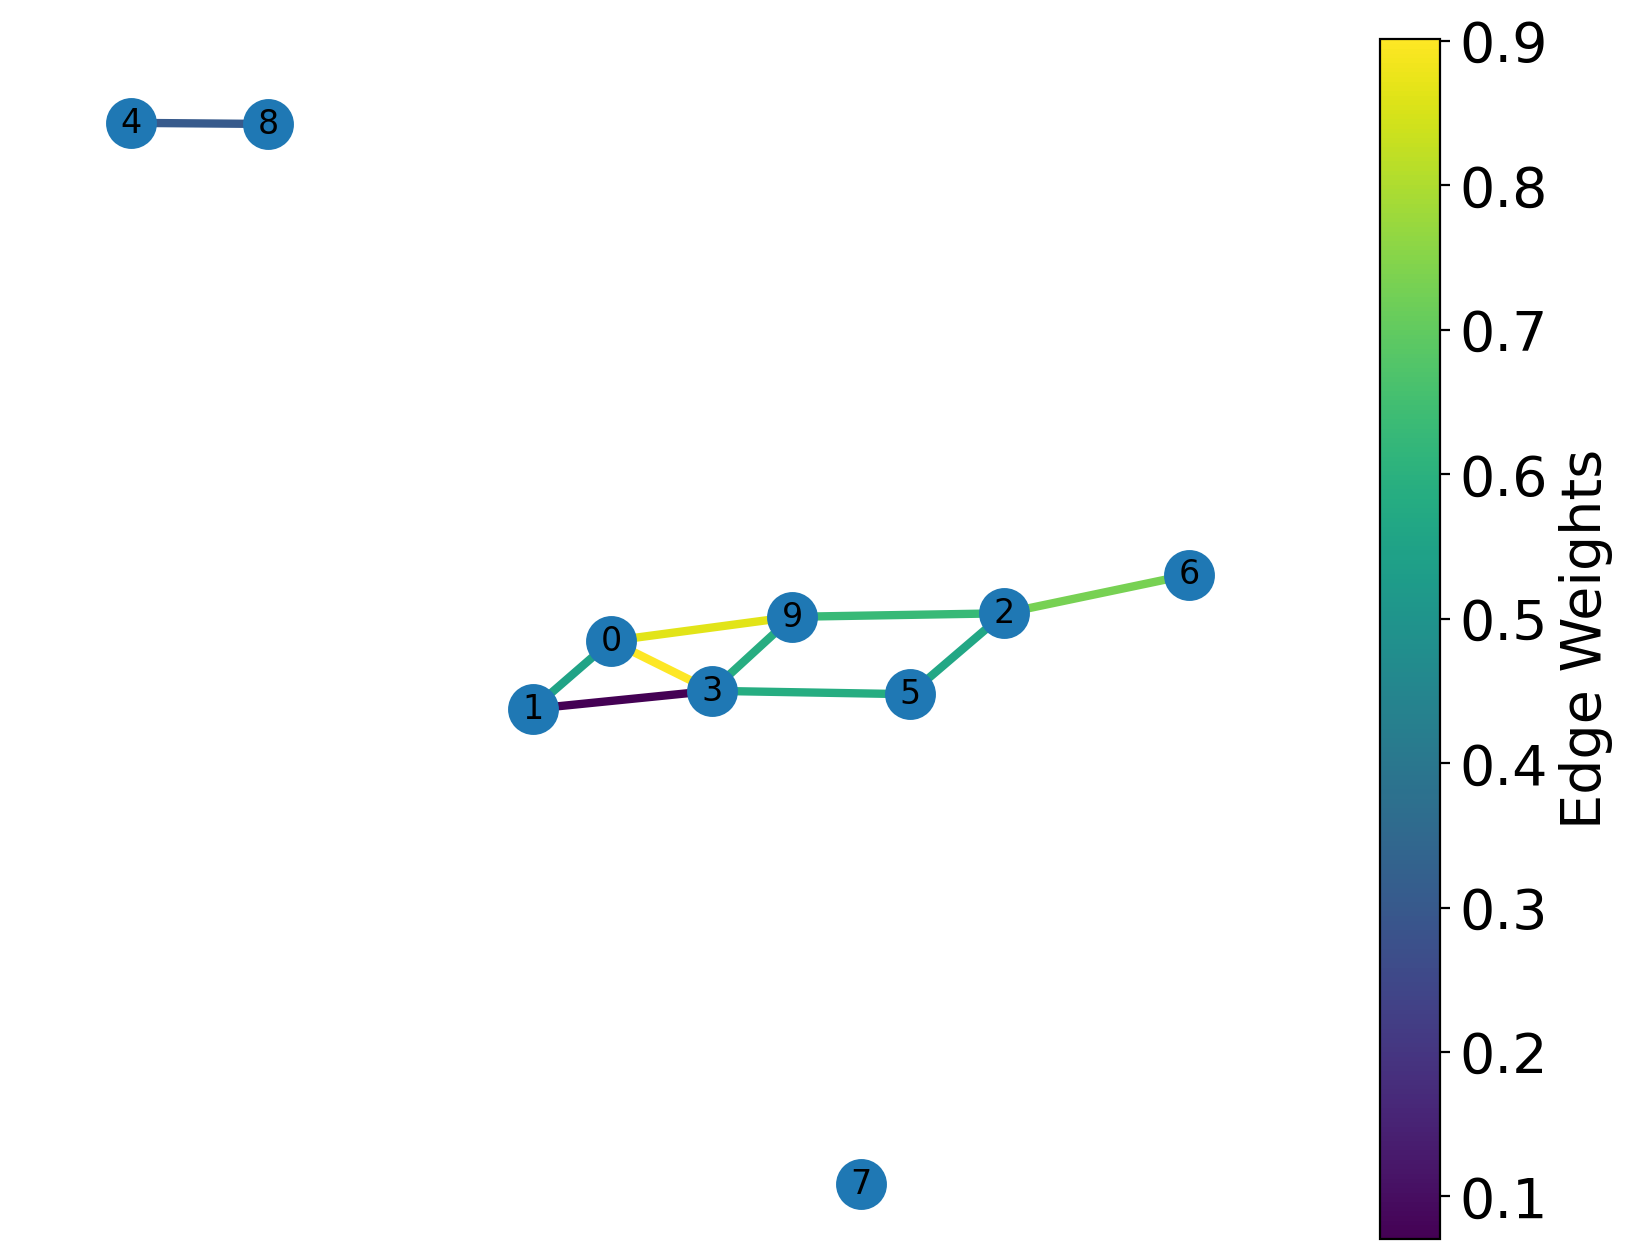

In [202]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

# Create a random graph
G = nx.gnp_random_graph(10, 0.3)

# Assign random weights to the edges
edge_weights = np.random.rand(len(G.edges()))

# Set up the positions of the nodes (spring layout for simplicity)
pos = nx.spring_layout(G)

# Create a figure and axis
plt.figure(figsize=(8, 6), dpi=200)

# Define a colormap
cmap = plt.cm.get_cmap('viridis')

# Normalize edge weights to be in the range [0, 1] for colormap
norm_edge_weights = (edge_weights - np.min(edge_weights)) / (np.max(edge_weights) - np.min(edge_weights))

# Draw the graph with colored edges
nx.draw(G, pos, with_labels=True, width=3, node_size=300, edge_color=norm_edge_weights, edge_cmap=cmap)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(edge_weights), vmax=np.max(edge_weights)))
sm.set_array([])
cbar = plt.colorbar(sm, label='Edge Weights')

# Show the plot
plt.show()

In [279]:
A[409]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,